# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
from operator import itemgetter
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


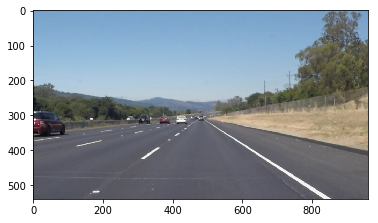

In [4]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [5]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image                

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, filtering=1):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, filtering)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    if (initial_img.shape[2] == 4):
        initial_img = initial_img[:,:,0:3] 
    assert(initial_img.shape == img.shape)
    return cv2.addWeighted(initial_img, α, img, β, λ)

### Global Variable
I decide to use global variables for the coordinates of the 2 lines. By having this information available at each iteration, it enables me to do some filtering and discard the wrong detections.

In [6]:
global_left_x1 = 0
global_left_y1 = 0
global_left_x2 = 0
global_left_y2 = 0

global_right_x1 = 0
global_right_y1 = 0
global_right_x2 = 0
global_right_y2 = 0

def initialize_global_var():
    global global_left_x1 
    global global_left_y1 
    global global_left_x2 
    global global_left_y2 
    global global_right_x1
    global global_right_y1
    global global_right_x2
    global global_right_y2
    
    global_left_x1 =0
    global_left_y1 =0
    global_left_x2 =0
    global_left_y2 =0
    global_right_x1 =0
    global_right_y1 =0
    global_right_x2 =0
    global_right_y2 =0

### Draw Lines Function

The output I first obtained was flickering a lot. I wasn't doing any averaging of the lines.
My first idea was to average every x1, y1, x2, y2 for both lines, one labelled left and the other right. The problem is that for each image I was receiving about 10 lines. Some were much smaller than the others. Th basic average on that shifted the result way off. 

I thought I would keep the highest (x, y) position (lowest in x) in for the bottom corners and average the top corner of the trapeze over the 3 highest positions in y (highest . In my view, x1 and y1 are the bottom corners.


                   ______   <- (right_x2, right_y2)
                  /      \      
                 /        \
                /          \
               /            \
              /              \
             /                \
            /__________________\    <- (right_x1, right_y1)
            
            
Extrapolating consists of continuing the line obtained to make up for the fact that some lines are doted. 
I compute the line coefficient are deduce the x position (bottom of the screen) at y being equal to the height of the image. 



In [98]:
from itertools import islice

def draw_lines(img, lines, filtering=1, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    global global_left_x1 
    global global_left_y1 
    global global_left_x2 
    global global_left_y2 
    global global_right_x1
    global global_right_y1
    global global_right_x2
    global global_right_y2
    width = image.shape[1]
    height = image.shape[0]
    left_count = 0
    right_count = 0
    left_x1 = 0
    left_y1 = 0
    left_x2 = 0
    left_y2 = 0
    left_horizon = []
    right_horizon = []
    right_x1 = 0
    right_y1 = 0
    right_x2 = 0
    right_y2 = 0
    
    try:  
        # Averaging
        for line in lines:
            for x1,y1,x2,y2 in line:
                if abs(y1-y2) < 10:
                        continue
                a = ((y2-y1)/(x2-x1))
                if (a < 0):
                    if (y1 > y2):
                        if (y1 > left_y1):
                            left_y1 = y1
                            left_x1 = x1
                        left_horizon.append((x2, y2))
                    else:
                        if (y2 > left_y1):
                            left_y1 = y2
                            left_x1 = x2
                        left_horizon.append((x1, y1))
                else:
                    if (y1 > y2):
                        if (y1 > right_y1):
                            right_y1 = y1
                            right_x1 = x1
                        right_horizon.append((x2, y2))
                    else:
                        if (y2 > right_y1):
                            right_y1 = y2
                            right_x1 = x2
                        right_horizon.append((x1, y1))

        left_sorted_horizon = sorted(left_horizon, key=itemgetter(1), reverse=False)   # Sorted by y position
        right_sorted_horizon = sorted(right_horizon, key=itemgetter(1))
        
        nb_avg_pos_left = min(3, len(left_sorted_horizon))
        for pos in islice(left_sorted_horizon, nb_avg_pos_left):
            left_x2 = left_x2 + pos[0] #x
            left_y2 = left_y2 + pos[1] #y 
        nb_avg_pos_right = min(3, len(right_sorted_horizon))
        for pos in islice(right_sorted_horizon, nb_avg_pos_right):
            right_x2 = right_x2 + pos[0] #x
            right_y2 = right_y2 + pos[1] #y

        left_x2 = left_x2 / nb_avg_pos_left
        left_y2 = left_y2 / nb_avg_pos_left
        right_x2 = right_x2 / nb_avg_pos_right
        right_y2 = right_y2 / nb_avg_pos_right

        # y = ax + b
        if (left_x2 != left_x1):
            left_a = ((left_y2-left_y1)/(left_x2-left_x1))
        else:
            left_a = ((left_y2-left_y1)/(left_x2-left_x1+0.00001))

        right_a = ((right_y2-right_y1)/(right_x2-right_x1))
        left_b = left_y1 - left_x1 * left_a
        right_b = right_y1 - right_x1 * right_a

        # Extrapolating
        if math.isclose(height, left_b, rel_tol=1e-5):
            left_x1 = 0 
        else:
            left_x1 = (height - left_b)/float(left_a)
            left_x1 = int(min(left_x1, width))
        if math.isclose(height, right_b, rel_tol=1e-5):
            right_x1 = 0 
        else:
            right_x1 = (height - right_b)/float(right_a)
            right_x1 = int(min(right_x1, width))    

        # Filtering
        if (filtering != 1):
            coeff_of_new = filtering
            if (global_right_x1 == 0): # If it is the first time, no low pass filter
                global_left_x1 = left_x1
                global_left_y1 = height
                global_left_x2 = left_x2
                global_left_y2 = left_y2
                global_right_x1 = right_x1
                global_right_y1 = height
                global_right_x2 = right_x2
                global_right_y2 = right_y2
            else:
                global_left_x1 = left_x1 * coeff_of_new + (1 - coeff_of_new) *global_left_x1
                #global_left_y1 = left_y1 * coeff_of_new + (1 - coeff_of_new) *global_left_y1
                global_left_x2 = left_x2 * coeff_of_new + (1 - coeff_of_new) *global_left_x2
                global_left_y2 = left_y2 * coeff_of_new + (1 - coeff_of_new) *global_left_y2
                global_right_x1 = right_x1 * coeff_of_new + (1 - coeff_of_new) *global_right_x1
                #global_right_y1 = right_y1 * coeff_of_new + (1 - coeff_of_new) *global_right_y1
                global_right_x2 = right_x2 * coeff_of_new + (1 - coeff_of_new) *global_right_x2
                global_right_y2 = right_y2 * coeff_of_new + (1 - coeff_of_new) *global_right_y2
            cv2.line(img, (int(global_left_x1), int(global_left_y1)), (int(global_left_x2), int(global_left_y2)), color, 15)
            cv2.line(img, (int(global_right_x1), int(global_right_y1)), (int(global_right_x2), int(global_right_y2)), color, 15)
        else:
            # No filtering
            cv2.line(img, (int(left_x1), height), (int(left_x2), int(left_y2)), color, 15)
            cv2.line(img, (int(right_x1),height), (int(right_x2),int(right_y2)), color, 15)
    except:
        # if division by 0 -> print last detected lines
        if (filtering != 1):
            cv2.line(img, (int(global_left_x1), int(global_left_y1)), (int(global_left_x2), int(global_left_y2)), color, 15)
            cv2.line(img, (int(global_right_x1), int(global_right_y1)), (int(global_right_x2), int(global_right_y2)), color, 15)
            

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [99]:
import os
dir = os.listdir("test_images/")
for file in dir:
    print(file)

.DS_Store
solidWhiteCurve.jpg
solidWhiteRight.jpg
solidYellowCurve.jpg
solidYellowCurve2.jpg
solidYellowLeft.jpg
whiteCarLaneSwitch.jpg


## Build a Lane Finding Pipeline



Here is my first pipeline. It worked fine on the "easy" videos but couldn't make the trick on the 'challenge.mp4'.

In [100]:
def process_image(image, kernel_size, low_th, high_th, vertices, threshold, min_line_len, max_line_gap, filtering=1):
    gray_image = grayscale(image)
    blur_image = gaussian_blur(gray_image, kernel_size)
    canny_image = canny(blur_image, low_th, high_th)
    masked_image = region_of_interest(canny_image, vertices)
    hough_image = hough_lines(masked_image, 1, np.pi/180, threshold, min_line_len, max_line_gap, filtering)
    weighted_image = weighted_img(hough_image, image, 0.9, 0.9)
    return weighted_image

### Pipeline understanding
For the sake of understanding what is each step of the pipeline doing. I have slightly modified my process_image() function to save and display each sub-functions result. 

In [101]:
output_folder = "test_image_output/"

def process_image_save_images(image, kernel_size, low_th, high_th, vertices, threshold, min_line_len, max_line_gap, filtering=1):
    gray_image = grayscale(image)
    mpimg.imsave(output_folder+"gray.jpg", gray_image, cmap='gray')
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    yellow_image = cv2.inRange(hsv, (20, 80, 80), (25, 255, 255))
    mpimg.imsave(output_folder+"yellow.jpg", yellow_image, cmap='gray')
    white_image = cv2.inRange(hsv, (0, 0, 180), (255, 25, 255))
    mpimg.imsave(output_folder+"white.jpg", white_image, cmap='gray')
    gray = cv2.bitwise_or(yellow_image, white_image)
    #blur_image = gaussian_blur(gray_image, kernel_size)
    blur_image = gaussian_blur(gray, kernel_size)
    mpimg.imsave(output_folder+"blur.jpg", blur_image, cmap='gray')
    canny_image = canny(blur_image, low_th, high_th)
    mpimg.imsave(output_folder+"canny.jpg", canny_image)
    masked_image = region_of_interest(canny_image, vertices)
    mpimg.imsave(output_folder+"mask.jpg", masked_image)
    hough_image = hough_lines(masked_image, 1, np.pi/180, threshold, min_line_len, max_line_gap, filtering)
    mpimg.imsave(output_folder+"hough.jpg", hough_image)
    weighted_image = weighted_img(hough_image, image, 0.9, 0.9)
    return weighted_image

Here a piece of code to call it on the "solidWhiteCurve.jpg" image.

I've run a lot of experiment to tune the range of detection for the yellow image. 

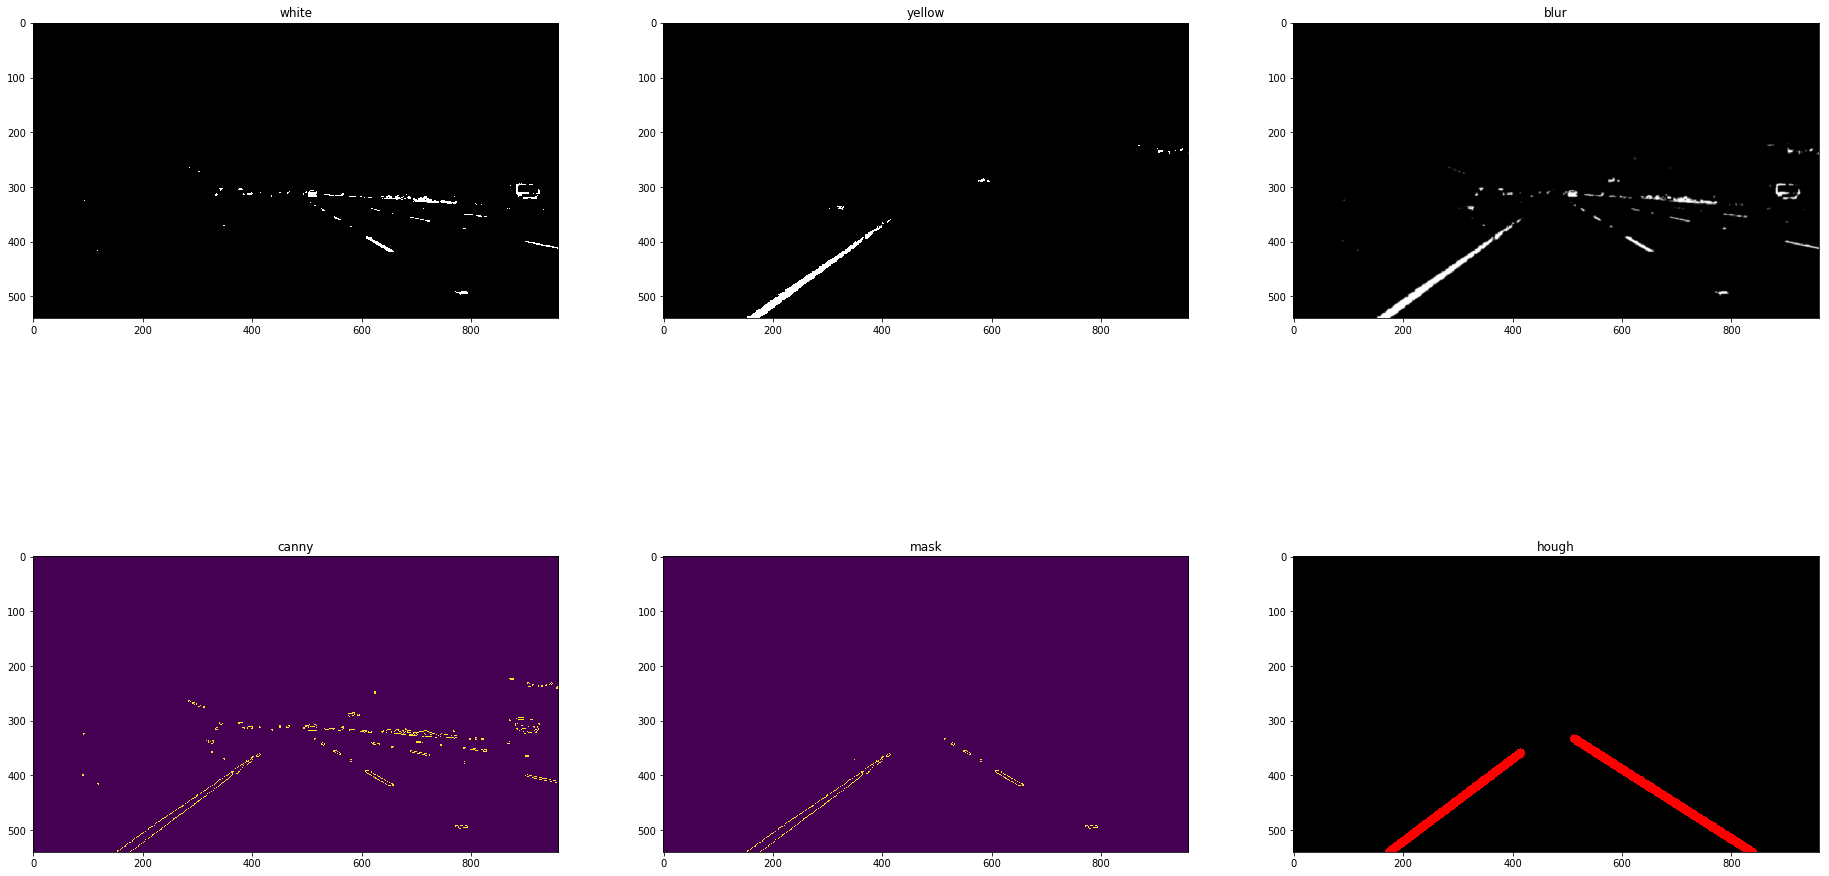

In [102]:
def showimg(subplace, title, _img):
    plt.subplot(*subplace)
    plt.title(title)
    plt.imshow(_img)

def show_pipeline(image):
    plt.figure(figsize=[32, 18])
    height = image.shape[0]
    width  = image.shape[1]
    vertices=np.array([[(50,height),(width*0.45,height*0.6),(width*0.55,height*0.6),(width-50,height)]], dtype=np.int32)
    processed_image = process_image_save_images(image, 5, 60, 170, vertices, 30, 1, 100)
    i = 1
    for file in ['white', 'yellow', 'blur', 'canny', 'mask', 'hough']:
        image = mpimg.imread(output_folder+str(file)+'.jpg')
        showimg((2, 3, i), str(file), image)
        i = i + 1 

image = mpimg.imread('test_images/solidYellowCurve.jpg')   
show_pipeline(image)

It seems to run great ! But the problem being when I tried on an image where the road color changed. Then I started to introduce the yellow detection.

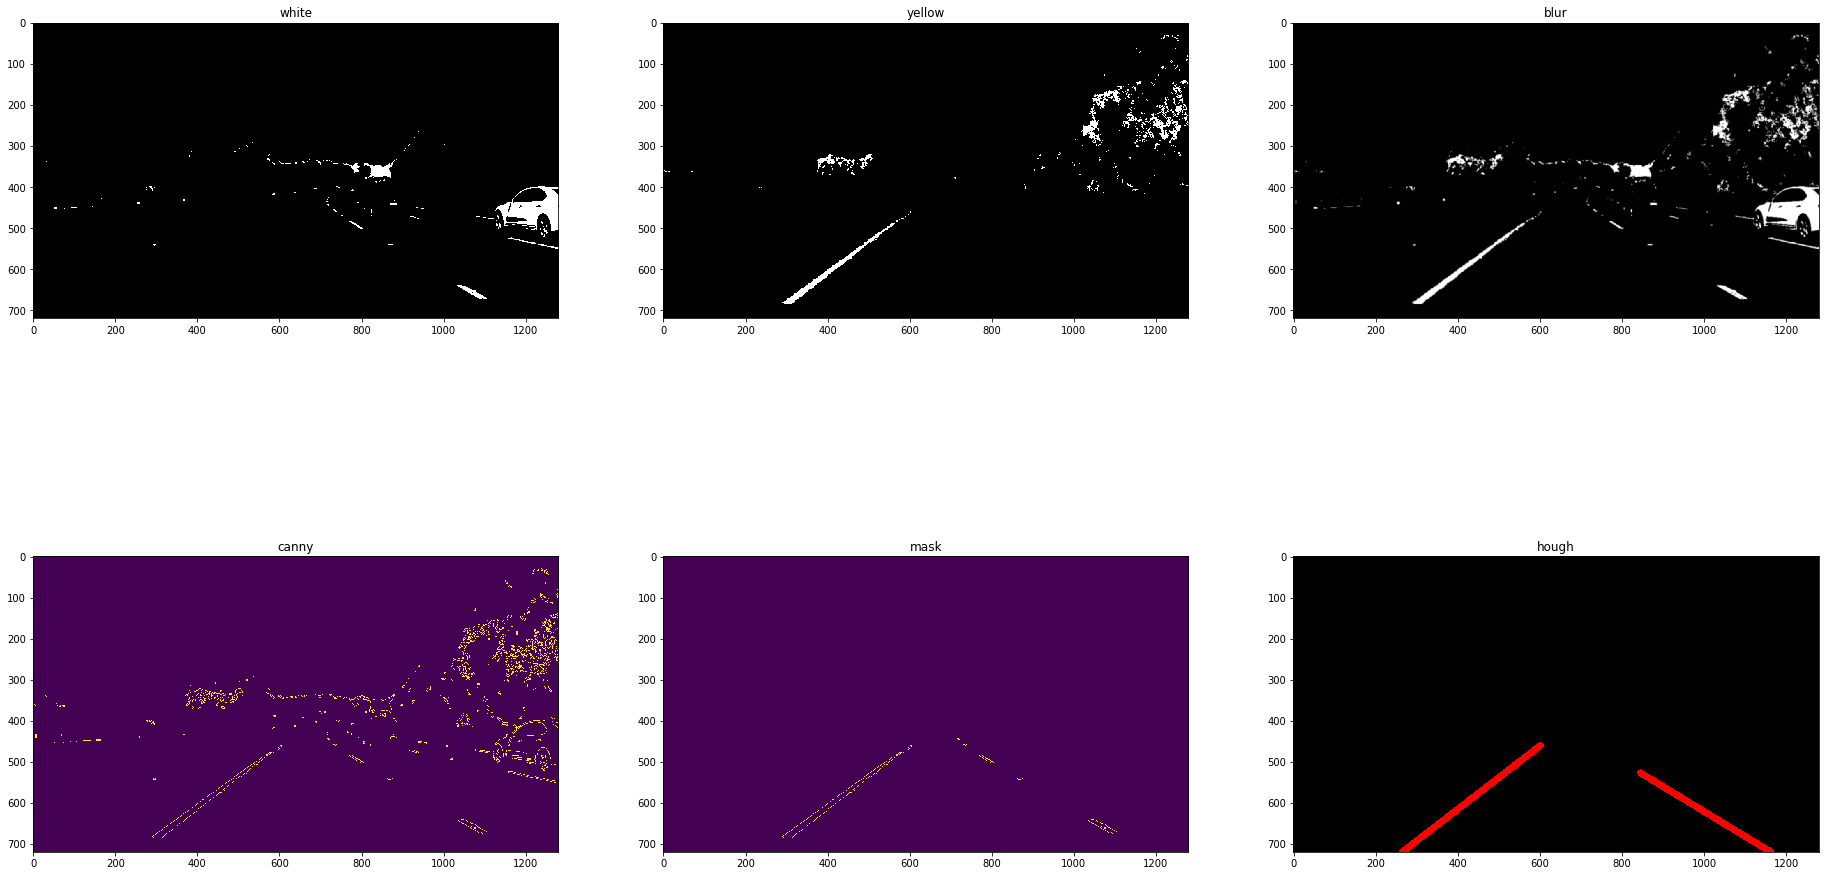

In [110]:
image = mpimg.imread('test_images_challenge/250.jpg')
show_pipeline(image)

In [104]:
def process_image(image, kernel_size, low_th, high_th, vertices, threshold, min_line_len, max_line_gap, filtering=1):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    yellow_image = cv2.inRange(hsv, (20, 80, 80), (25, 255, 255))
    white_image = cv2.inRange(hsv, (0, 0, 180), (255, 25, 255))
    gray_image = cv2.bitwise_or(yellow_image, white_image)
    blur_image = gaussian_blur(gray_image, kernel_size)
    canny_image = canny(blur_image, low_th, high_th)
    masked_image = region_of_interest(canny_image, vertices)
    hough_image = hough_lines(masked_image, 1, np.pi/180, threshold, min_line_len, max_line_gap, filtering)
    weighted_image = weighted_img(hough_image, image, 0.9, 0.9)
    return weighted_image

## Images Testing results
I am reusing the showing() function from the last cell but I'm not showing each intermediate output now that we've understood the concept. 

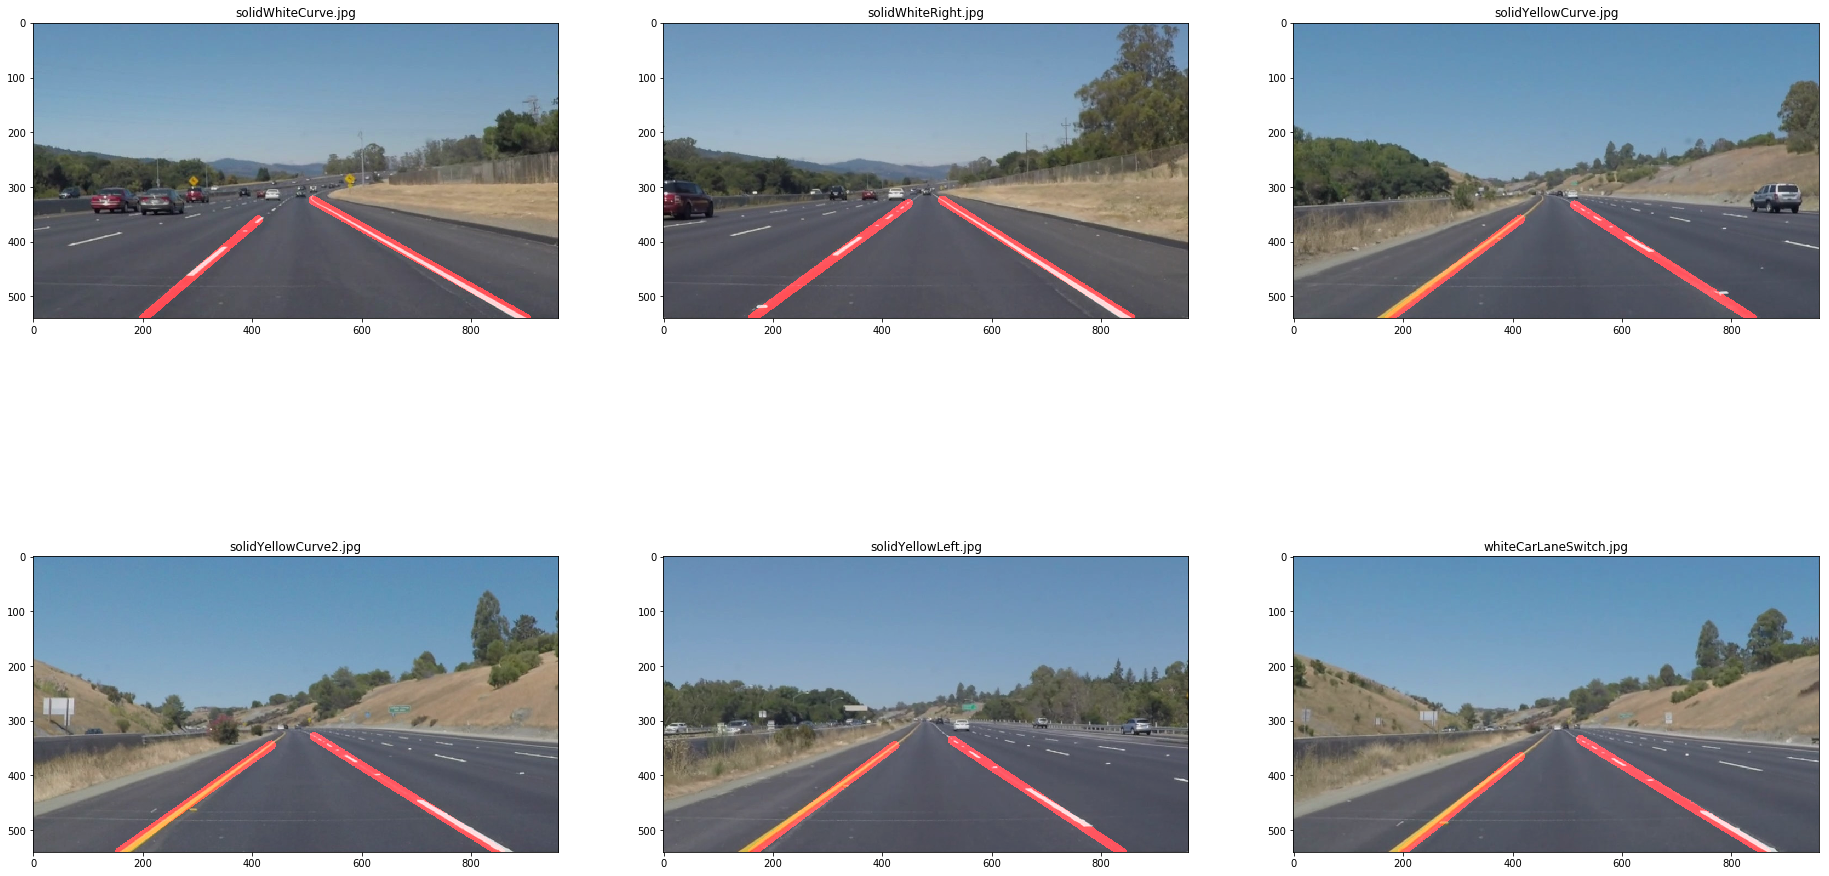

In [105]:
plt.figure(figsize=[32, 18])
output_folder = "test_image_output/"
i = 1
for file in dir:
    if (file != ".DS_Store"):
        image = mpimg.imread('test_images/'+file)
        height = image.shape[0]
        width  = image.shape[1]
        vertices=np.array([[(50,height),(width*0.45,height*0.6),(width*0.55,height*0.6),(width-50,height)]], dtype=np.int32)
        processed_image = process_image(image, 5, 60, 170, vertices, 30, 1, 100)
        mpimg.imsave(output_folder+file, processed_image)
        showimg((2, 3, i), file, processed_image)
        i = i + 1                  

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [106]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [107]:
def process_image_caller(image):
    height = image.shape[0]
    width  = image.shape[1]
    vertices=np.array([[(50,height),(width*0.45,height*0.6),(width*0.55,height*0.6),(width-50,height)]], dtype=np.int32)
    result = process_image(image, 5, 60, 170, vertices, 30, 1, 100, 0.05)
    return result

## Export images form the videos
In order to have more images, I saved several images out of the 3 videos provided with the following function.

In [96]:
interval = 50
counter = 0
output_folder = "test_images_challenge/"
index = 0

def save_images(image):
    global index
    global counter
    if (counter == 0):
        index = index + 1
        mpimg.imsave(output_folder+str(index*interval)+".jpg", image)
        counter = 50
    else:
        counter = counter - 1
    return image

In [97]:
dir = os.listdir("test_videos")
output_folder = "test_videos_output/"
for file in dir:
    if ((file != ".DS_Store") & (file != "challenge.mp4")):
        print(file)
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
        initialize_global_var()
        clip1 = VideoFileClip("test_videos/"+file)
        white_clip = clip1.fl_image(process_image_caller)                   #NOTE: this function expects color images!!
        %time white_clip.write_videofile(output_folder+file, audio=False)

solidWhiteRight.mp4
[(513, 324), (508, 324), (516, 325), (697, 443), (709, 451), (757, 482)]
[(453, 324), (453, 325), (429, 338), (400, 358)]
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



  1%|▏         | 3/222 [00:00<00:10, 21.42it/s]

[(513, 324), (508, 324), (516, 325), (697, 443), (709, 451), (757, 482)]
[(453, 324), (453, 325), (429, 338), (400, 358)]
[(514, 324), (513, 324), (508, 324), (515, 325), (510, 326), (729, 464), (760, 474)]
[(451, 324), (452, 324), (453, 325), (349, 395), (256, 474)]
[(512, 324), (508, 324), (514, 324), (509, 324), (516, 330), (784, 499), (793, 505)]
[(451, 324), (452, 324), (452, 325), (248, 468), (261, 470)]
[(513, 324), (508, 324), (512, 324), (513, 328), (786, 500)]
[(452, 327), (391, 366), (388, 367), (209, 495)]


[(514, 324), (508, 324), (509, 325), (514, 325), (719, 457)]
[(449, 325), (451, 327), (451, 328)]



  3%|▎         | 7/222 [00:00<00:11, 18.07it/s]

[(514, 324), (509, 324), (515, 324), (518, 327), (514, 328), (757, 481)]
[(450, 325), (448, 325), (450, 326)]
[(514, 324), (509, 324), (515, 325), (514, 328), (655, 408), (805, 511)]
[(448, 325), (450, 325), (450, 327), (450, 328)]


[(509, 324), (514, 324), (513, 327), (587, 369), (687, 427)]
[(447, 326), (448, 326), (449, 327)]
[(513, 324), (509, 324), (510, 325), (521, 329), (608, 388), (741, 471)]
[(455, 324), (453, 324), (447, 326), (446, 326)]



  6%|▌         | 13/222 [00:00<00:09, 21.88it/s]

[(507, 324), (507, 325), (515, 327), (521, 331), (585, 375), (597, 383), (774, 495)]
[(452, 324), (454, 324), (454, 326), (451, 326)]
[(503, 324), (504, 324), (509, 325), (508, 328), (515, 333), (621, 401), (712, 459)]
[(454, 326), (452, 326), (454, 328), (430, 343)]
[(504, 324), (509, 325), (507, 325), (505, 326), (510, 330), (514, 333), (541, 345), (715, 462), (715, 463)]
[(452, 327), (450, 327), (444, 332)]
[(503, 324), (508, 324), (512, 327), (523, 338), (748, 473)]
[(452, 326), (450, 326), (452, 328), (452, 329), (445, 335)]
[(511, 324), (507, 324), (522, 332), (520, 334), (559, 359), (607, 391)]
[(449, 325), (451, 325), (452, 327), (445, 333), (230, 490)]
[(513, 324), (508, 324), (509, 324), (526, 333), (649, 417), (670, 431), (784, 493)]
[(448, 325), (451, 326), (392, 363), (257, 468)]



  7%|▋         | 16/222 [00:00<00:09, 22.86it/s]

[(516, 324), (513, 326), (540, 342), (658, 414), (688, 441), (721, 463)]
[(451, 324), (388, 364), (210, 489), (207, 490), (221, 491), (206, 491)]
[(517, 324), (512, 324), (519, 326), (532, 338), (686, 439), (734, 471)]
[(450, 324), (448, 324)]
[(516, 324), (511, 324), (512, 325), (527, 332), (603, 385), (694, 445), (751, 483)]
[(449, 324), (447, 325), (449, 326)]
[(510, 324), (514, 324), (515, 325), (514, 328), (525, 332), (673, 432), (757, 488)]
[(449, 326), (449, 328), (447, 328)]



  9%|▊         | 19/222 [00:00<00:08, 23.18it/s]

[(512, 324), (508, 324), (508, 325), (516, 327), (530, 340), (768, 496)]
[(447, 327), (448, 328), (448, 330)]
[(505, 324), (506, 324), (512, 325), (639, 412)]
[(448, 330), (448, 331), (362, 394)]



 10%|▉         | 22/222 [00:00<00:08, 23.86it/s]

[(510, 324), (505, 324), (506, 325), (642, 414)]
[(445, 329), (447, 330), (447, 332), (446, 332)]
[(506, 324), (512, 325), (519, 333), (673, 434), (709, 458)]
[(447, 330), (447, 332), (437, 338), (437, 340)]



 11%|█▏        | 25/222 [00:01<00:09, 21.30it/s]

[(512, 324), (507, 324), (525, 333), (657, 423), (702, 453)]
[(446, 329), (446, 331), (446, 332), (430, 343)]
[(512, 324), (509, 325), (529, 335), (535, 343), (718, 463)]
[(453, 325), (453, 326), (445, 332), (434, 341)]



 13%|█▎        | 28/222 [00:01<00:08, 22.59it/s]

[(513, 324), (508, 324), (512, 327), (526, 333), (652, 419), (747, 482)]
[(445, 332), (432, 342), (430, 344), (399, 361), (403, 363)]
[(513, 324), (507, 324), (527, 334), (532, 341), (796, 514)]
[(451, 325), (431, 343), (428, 346), (398, 367), (257, 464), (261, 468)]
[(507, 324), (508, 324), (514, 325), (532, 337), (668, 430)]
[(452, 325), (429, 345), (213, 491), (210, 492), (225, 494)]
[(513, 324), (507, 324), (511, 325), (535, 343), (776, 501)]
[(451, 325), (451, 326), (427, 346)]



 14%|█▍        | 31/222 [00:01<00:07, 24.11it/s]

[(508, 324), (518, 327), (537, 340), (548, 351), (672, 423)]
[(450, 325), (450, 326), (448, 327)]
[(510, 324), (509, 324), (516, 325), (516, 329), (526, 332), (550, 352)]
[(449, 325), (423, 348)]



 15%|█▌        | 34/222 [00:01<00:07, 25.23it/s]

[(511, 324), (509, 324), (534, 337), (537, 343), (660, 415)]
[(449, 325), (449, 326)]
[(515, 324), (511, 324), (516, 324), (515, 328), (533, 336), (552, 353)]
[(446, 325), (449, 327), (419, 350)]
[(510, 324), (509, 324), (520, 328), (540, 345), (556, 356), (706, 444)]
[(447, 326), (447, 328), (417, 352)]
[(509, 324), (507, 324), (517, 327), (534, 338), (543, 348), (704, 444)]
[(447, 328), (446, 328), (444, 329)]



 17%|█▋        | 37/222 [00:01<00:07, 25.22it/s]

[(508, 324), (506, 324), (508, 325), (516, 327), (561, 361), (787, 496)]
[(453, 324), (454, 324), (411, 358), (409, 360)]
[(508, 324), (507, 324), (514, 326), (511, 326), (550, 353), (582, 375), (765, 483)]
[(445, 330), (408, 361), (311, 433)]



 18%|█▊        | 40/222 [00:01<00:06, 26.32it/s]

[(513, 324), (510, 325), (513, 325), (511, 326), (511, 327), (534, 342), (591, 381)]
[(445, 330), (358, 398)]
[(508, 324), (509, 324), (513, 324), (556, 352), (560, 359), (597, 384), (774, 488)]
[(453, 324), (451, 324), (451, 326), (347, 406), (264, 467)]
[(511, 324), (509, 324), (515, 324), (536, 338), (542, 346), (574, 368), (592, 380), (705, 455)]
[(449, 324), (449, 325), (426, 340), (215, 489)]
[(511, 324), (515, 324), (513, 325), (543, 342), (567, 358), (574, 367), (647, 416), (665, 428)]
[(451, 325), (440, 330), (163, 524)]



 19%|█▉        | 43/222 [00:01<00:07, 25.54it/s]

[(511, 324), (510, 324), (516, 324), (517, 324), (522, 331), (676, 434)]
[(451, 324), (439, 330)]
[(511, 324), (517, 324), (515, 324), (519, 330), (539, 343), (577, 369), (641, 412), (664, 420), (696, 449)]
[(450, 324), (447, 327), (418, 344)]


[(511, 324), (512, 324), (515, 324), (516, 324), (523, 332), (550, 349)]
[(447, 324), (449, 324), (449, 325), (449, 326)]
[(511, 324), (510, 324), (515, 324), (520, 331), (531, 337), (546, 344), (667, 422), (734, 473)]
[(448, 325), (433, 333), (411, 348)]



 21%|██        | 46/222 [00:02<00:08, 21.08it/s]

[(510, 324), (516, 324), (518, 325), (524, 332), (676, 426), (754, 475), (777, 501), (810, 510)]
[(447, 325), (447, 326), (445, 328), (410, 349)]
[(511, 324), (515, 324), (512, 325), (544, 345), (562, 354), (612, 385), (720, 463)]
[(445, 325), (446, 326), (444, 328)]



 22%|██▏       | 49/222 [00:02<00:11, 15.18it/s]

[(514, 324), (512, 325), (525, 333), (572, 361), (710, 449), (719, 463)]
[(443, 326), (443, 327), (442, 329)]
[(514, 324), (515, 324), (521, 331), (537, 341), (625, 395), (689, 436)]
[(443, 327), (431, 337), (403, 356)]
[(510, 324), (514, 324), (515, 325), (516, 326), (529, 336)]
[(452, 324), (441, 328), (443, 330), (426, 338), (292, 442), (208, 504)]
[(513, 324), (508, 324), (514, 324), (516, 325), (532, 338), (652, 412), (721, 456)]
[(451, 324), (440, 329), (423, 340), (266, 459), (266, 461)]



 24%|██▍       | 53/222 [00:02<00:14, 11.93it/s]

[(508, 324), (515, 325), (517, 326), (521, 331), (530, 333), (684, 432)]
[(451, 324), (448, 324), (222, 481), (218, 482), (232, 484)]
[(513, 324), (514, 324), (509, 324), (530, 337), (589, 372), (693, 438)]
[(447, 324), (449, 324), (450, 325), (170, 515), (185, 516), (185, 517)]



 25%|██▍       | 55/222 [00:03<00:16, 10.14it/s]

[(512, 324), (513, 324), (509, 324), (515, 325), (590, 373), (726, 459), (754, 477)]
[(449, 324), (448, 324), (449, 325), (449, 327)]
[(512, 324), (508, 324), (513, 325), (519, 328), (526, 335), (764, 483)]
[(448, 325), (446, 325)]
[(511, 324), (506, 324), (512, 325), (522, 331), (535, 342), (615, 390), (688, 443)]
[(447, 326), (446, 326), (445, 326)]



 27%|██▋       | 59/222 [00:03<00:13, 12.18it/s]

[(509, 324), (505, 324), (506, 324), (512, 325), (511, 329), (623, 396), (650, 420)]
[(444, 328), (447, 329)]
[(508, 324), (505, 324), (509, 324), (505, 325), (633, 403), (625, 404), (665, 431)]
[(444, 329), (445, 329), (445, 331)]
[(509, 324), (505, 324), (504, 324), (511, 326), (519, 331), (672, 428), (675, 438)]
[(443, 329), (433, 340), (410, 355)]



 27%|██▋       | 61/222 [00:03<00:13, 12.16it/s]

[(504, 324), (509, 324), (510, 325), (507, 325), (547, 351), (553, 351), (596, 378), (771, 490), (774, 503)]
[(443, 329), (444, 331), (444, 332)]
[(505, 324), (508, 324), (546, 351), (560, 356), (732, 466)]
[(449, 325), (452, 326), (452, 327), (441, 330)]
[(505, 324), (504, 324), (509, 324), (511, 326), (563, 358), (560, 360), (620, 394)]
[(450, 325), (451, 325), (439, 331), (280, 446), (280, 447)]
[(504, 324), (508, 324), (505, 324), (556, 358), (562, 358), (567, 361), (627, 399), (727, 463)]
[(447, 326), (448, 326), (451, 327), (252, 467), (233, 481)]



 29%|██▉       | 65/222 [00:04<00:17,  9.20it/s]

[(504, 324), (508, 324), (509, 324), (505, 324), (626, 399), (644, 410)]
[(447, 326), (448, 326), (449, 328), (204, 490), (205, 490), (215, 493)]
[(503, 324), (509, 324), (505, 324), (508, 324), (510, 326), (675, 430), (683, 435)]
[(448, 327), (449, 327), (449, 328), (380, 371)]



 30%|███       | 67/222 [00:04<00:17,  9.08it/s]

[(504, 324), (508, 324), (510, 324), (505, 324), (509, 324), (510, 329), (673, 429), (713, 454)]
[(447, 327), (448, 329), (402, 361)]
[(506, 324), (512, 324), (510, 324), (714, 454), (749, 476)]
[(448, 326), (445, 326), (448, 328)]
[(507, 324), (511, 324), (507, 325), (513, 326), (594, 377), (741, 471)]
[(447, 326), (432, 337)]



 31%|███       | 69/222 [00:04<00:17,  8.92it/s]

[(511, 324), (510, 324), (506, 324), (507, 325), (515, 328), (732, 466), (773, 492)]
[(452, 324), (450, 324)]
[(510, 324), (511, 324), (508, 326), (512, 326), (731, 466)]
[(445, 328), (445, 329), (445, 331)]
[(511, 324), (512, 325), (508, 326), (520, 331), (716, 456)]
[(452, 324), (449, 325), (444, 328)]



 33%|███▎      | 73/222 [00:04<00:13, 11.38it/s]

[(506, 324), (513, 326), (510, 327), (624, 397)]
[(451, 324), (449, 324), (450, 325), (441, 331)]
[(510, 324), (508, 326), (513, 330), (518, 330), (658, 419)]
[(451, 324), (448, 324), (451, 325), (448, 325), (402, 358), (355, 386)]
[(505, 324), (517, 330), (515, 332), (639, 408), (647, 413)]
[(450, 324), (449, 324), (450, 326), (398, 362)]



 34%|███▍      | 75/222 [00:04<00:13, 10.67it/s]

[(511, 325), (508, 325), (509, 327), (588, 382), (678, 433), (711, 454)]
[(449, 324), (449, 325), (449, 327), (389, 363)]
[(512, 325), (509, 325), (511, 328), (523, 337), (534, 345), (731, 467)]
[(448, 324), (449, 326), (208, 482), (206, 483), (220, 484)]
[(508, 324), (507, 324), (512, 325), (514, 330), (520, 331), (533, 344), (610, 397), (671, 439)]
[(446, 324), (439, 333), (156, 514), (158, 514), (172, 516)]



 36%|███▌      | 79/222 [00:05<00:12, 11.30it/s]

[(506, 324), (507, 324), (509, 325), (508, 325), (512, 325), (645, 421), (771, 494)]
[(447, 324), (447, 326)]
[(506, 324), (507, 325), (512, 329), (522, 333), (641, 412), (690, 452)]
[(446, 325), (446, 328)]
[(506, 324), (507, 325), (508, 326), (522, 333), (601, 386), (729, 480)]
[(445, 325), (445, 326), (435, 336)]



 37%|███▋      | 83/222 [00:05<00:11, 12.27it/s]

[(506, 324), (507, 324), (509, 325), (511, 328), (517, 329), (598, 384)]
[(444, 326), (442, 328), (445, 328)]
[(507, 324), (506, 324), (507, 325), (511, 328), (695, 448)]
[(443, 326), (444, 329)]
[(506, 324), (509, 325), (510, 326), (511, 328), (556, 357), (724, 466)]
[(443, 327), (444, 329), (428, 339)]
[(506, 324), (508, 324), (513, 329), (517, 332), (526, 338), (704, 454)]


 38%|███▊      | 85/222 [00:05<00:10, 12.77it/s]


[(442, 327), (430, 339)]
[(506, 324), (510, 327), (523, 333), (523, 337), (525, 338), (740, 478)]
[(440, 328), (442, 328), (442, 330), (429, 340)]
[(507, 324), (513, 325), (521, 335), (522, 336), (782, 506)]
[(440, 328), (442, 331), (425, 339), (279, 442)]



 39%|███▉      | 87/222 [00:05<00:10, 12.49it/s]

[(507, 324), (509, 326), (520, 334), (525, 338), (558, 362), (682, 440)]
[(448, 324), (450, 325), (427, 342)]
[(506, 324), (509, 325), (519, 330), (525, 338), (555, 360), (656, 422), (742, 479)]
[(440, 333), (383, 366), (205, 482), (219, 483)]
[(506, 324), (512, 324), (537, 343), (532, 343), (554, 359), (684, 441), (770, 498)]
[(447, 325), (450, 326), (450, 327), (377, 371), (156, 514), (171, 515)]



 41%|████      | 91/222 [00:06<00:11, 11.28it/s]

[(508, 324), (507, 324), (523, 332), (545, 352), (560, 363), (713, 460), (754, 487)]
[(447, 325), (449, 325), (449, 327), (449, 328)]
[(511, 324), (507, 324), (527, 339), (539, 348), (561, 364), (588, 384), (683, 442), (703, 456)]
[(448, 326), (449, 328)]
[(508, 324), (507, 324), (506, 324), (514, 326), (530, 341), (583, 380), (587, 383), (767, 497), (810, 525)]
[(445, 327), (448, 327), (449, 328), (434, 334), (417, 351)]
[(508, 324), (507, 324), (513, 324), (536, 341), (555, 359), (596, 389), (709, 469)]
[(447, 327), (445, 327), (446, 327), (448, 329), (447, 330)]



 43%|████▎     | 95/222 [00:06<00:11, 11.28it/s]

[(509, 324), (508, 324), (514, 324), (509, 325), (534, 339), (679, 438), (673, 442), (692, 455)]
[(447, 327), (448, 329), (434, 339)]
[(510, 324), (514, 324), (509, 324), (519, 326), (521, 331), (569, 367), (744, 491), (772, 500)]
[(452, 324), (454, 325), (445, 327), (447, 330), (326, 405)]
[(512, 324), (517, 324), (511, 324), (516, 324), (721, 466), (716, 471), (744, 490)]


 44%|████▎     | 97/222 [00:06<00:10, 11.89it/s]


[(446, 327), (445, 327), (446, 330)]
[(512, 324), (513, 324), (518, 324), (525, 330), (528, 334), (545, 344), (567, 360), (751, 495)]
[(451, 324), (454, 324), (444, 327), (404, 359)]
[(513, 324), (522, 326), (521, 329), (547, 345), (687, 449), (778, 514)]
[(454, 324), (444, 327), (442, 329)]
[(514, 324), (518, 324), (518, 327), (543, 344), (548, 345), (747, 491)]
[(454, 324), (453, 325), (443, 327), (444, 328)]



 45%|████▌     | 101/222 [00:07<00:09, 12.15it/s]

[(518, 324), (515, 324), (519, 324), (521, 328), (536, 338), (690, 442), (725, 475)]
[(441, 328), (444, 330), (423, 339), (371, 374), (213, 476)]
[(518, 324), (514, 324), (523, 330), (525, 331), (558, 352), (665, 432)]
[(453, 324), (443, 331), (163, 508), (178, 510), (177, 511)]
[(516, 324), (517, 325), (514, 325), (523, 331), (530, 332), (643, 417), (712, 466)]
[(452, 325), (451, 325), (452, 327)]



 46%|████▋     | 103/222 [00:07<00:10, 11.03it/s]

[(515, 324), (510, 324), (516, 325), (514, 326), (580, 369), (576, 371), (701, 460)]
[(452, 327), (452, 328), (377, 380)]
[(514, 324), (510, 324), (515, 325), (514, 328), (522, 332), (647, 422), (739, 475)]
[(449, 327), (448, 327), (451, 328), (451, 329)]
[(515, 324), (510, 324), (511, 324), (516, 325), (610, 395)]
[(448, 327), (450, 328), (451, 329), (438, 334)]



 48%|████▊     | 106/222 [00:07<00:09, 11.94it/s]

[(517, 324), (511, 324), (512, 325), (520, 327), (517, 327)]
[(447, 327), (449, 327), (450, 329), (413, 349)]
[(517, 324), (511, 324), (512, 324), (516, 324), (537, 336), (755, 483), (774, 496)]
[(454, 325), (447, 327), (447, 330)]



 49%|████▊     | 108/222 [00:07<00:09, 12.53it/s]

[(517, 324), (513, 325), (520, 325), (515, 325)]
[(446, 327), (447, 327), (449, 329)]
[(517, 324), (512, 324), (520, 329), (532, 333), (754, 482)]
[(447, 330), (447, 331), (312, 425), (312, 426)]
[(512, 324), (516, 324), (536, 336), (532, 337), (661, 429)]
[(454, 324), (455, 325), (427, 340), (397, 365)]



 50%|█████     | 112/222 [00:08<00:09, 12.15it/s]

[(511, 324), (519, 326), (535, 336), (531, 337), (560, 352), (758, 485)]
[(451, 325), (454, 326), (393, 362), (396, 366), (254, 457)]
[(515, 324), (517, 328), (537, 341), (547, 344), (558, 351), (783, 501)]
[(452, 325), (454, 325), (454, 327), (387, 366), (220, 480)]
[(511, 324), (516, 324), (532, 338), (543, 345), (549, 345), (588, 370), (796, 509)]
[(452, 325), (424, 343), (385, 368), (174, 511), (189, 513)]



 52%|█████▏    | 116/222 [00:08<00:08, 12.29it/s]

[(515, 324), (516, 324), (513, 325), (534, 339), (555, 349), (562, 353), (605, 381), (773, 493)]
[(423, 344), (378, 372)]
[(517, 324), (516, 324), (519, 325), (524, 328), (529, 335), (537, 340), (659, 417), (713, 453)]
[(449, 325), (373, 375)]
[(517, 324), (518, 324), (516, 324), (516, 326), (557, 349), (573, 359), (627, 394), (784, 498)]
[(451, 325), (451, 326)]



 53%|█████▎    | 118/222 [00:08<00:08, 11.74it/s]

[(517, 324), (516, 324), (511, 324), (518, 325), (526, 333), (541, 340), (563, 353), (558, 354), (707, 448)]
[(435, 335), (418, 347), (389, 365)]
[(517, 324), (511, 324), (517, 325), (520, 326), (540, 339), (574, 360), (741, 470)]
[(415, 349), (347, 392)]
[(512, 324), (517, 324), (519, 325), (512, 325), (526, 330), (557, 350), (585, 367), (760, 492)]
[(447, 328), (412, 351), (335, 400)]



 55%|█████▍    | 122/222 [00:08<00:08, 12.30it/s]

[(511, 324), (516, 324), (517, 325), (552, 351), (579, 364), (680, 429), (676, 436), (768, 499)]
[(447, 329), (448, 329), (408, 354), (285, 434)]
[(510, 324), (513, 324), (511, 326), (579, 365), (733, 463)]
[(448, 330), (448, 331), (445, 331), (435, 340)]
[(513, 324), (514, 327), (518, 331), (526, 333), (549, 348), (746, 473), (799, 506)]
[(455, 326), (454, 326), (456, 326), (445, 331), (287, 435), (284, 436)]



 56%|█████▌    | 124/222 [00:09<00:08, 12.17it/s]

[(513, 324), (511, 325), (528, 334), (563, 359), (670, 424), (726, 460)]
[(445, 331), (444, 332), (446, 332), (446, 334), (261, 452), (259, 453)]
[(513, 324), (511, 324), (509, 324), (527, 333), (707, 447)]
[(445, 332), (445, 333), (445, 334), (431, 345)]
[(511, 324), (521, 328), (545, 344), (578, 368), (737, 465)]
[(444, 332), (445, 334), (182, 504), (196, 506)]
[(515, 324), (511, 324), (518, 328), (524, 332), (531, 335), (701, 449)]
[(452, 326), (454, 327), (454, 328)]



 58%|█████▊    | 128/222 [00:09<00:06, 13.47it/s]

[(515, 324), (511, 324), (516, 324), (537, 342), (553, 349), (700, 449)]
[(452, 326), (454, 327), (454, 328), (405, 363)]
[(509, 324), (513, 324), (510, 324), (516, 325), (761, 489)]
[(453, 327), (453, 329), (453, 330), (439, 338)]
[(509, 324), (513, 324), (516, 325), (510, 325), (517, 325)]
[(453, 328), (453, 330)]



 59%|█████▉    | 132/222 [00:09<00:07, 12.41it/s]

[(513, 324), (510, 324), (514, 324), (518, 326), (566, 362)]
[(452, 328), (452, 329), (412, 354)]
[(510, 325), (513, 325), (517, 326), (512, 326), (573, 367), (728, 457)]
[(451, 329), (451, 330), (349, 405)]
[(513, 324), (512, 324), (509, 324), (509, 325), (516, 325), (750, 471)]
[(448, 330), (450, 332), (328, 413)]



 60%|██████    | 134/222 [00:09<00:07, 11.38it/s]

[(508, 324), (515, 324), (511, 325), (540, 341), (791, 496)]
[(448, 330), (450, 332), (437, 340)]
[(515, 324), (516, 324), (511, 324), (511, 325), (520, 329)]
[(454, 325), (457, 326), (456, 327), (446, 330), (293, 436)]



 61%|██████▏   | 136/222 [00:10<00:07, 12.11it/s]

[(518, 324), (513, 324), (512, 324), (513, 325), (541, 339), (800, 513)]
[(454, 324), (456, 324), (456, 326), (268, 452), (227, 480)]
[(513, 324), (519, 324), (520, 324), (515, 324), (529, 332)]
[(454, 325), (456, 325), (429, 339), (395, 363)]
[(514, 324), (520, 324), (519, 324), (513, 324), (515, 324), (524, 329)]
[(455, 324), (452, 324), (444, 329), (196, 501), (208, 504)]
[(513, 324), (519, 324), (520, 324), (516, 325), (526, 327), (559, 350), (732, 456)]
[(451, 324), (454, 325), (454, 326)]



 63%|██████▎   | 140/222 [00:10<00:06, 12.36it/s]

[(511, 324), (517, 324), (513, 324), (738, 461)]
[(451, 325), (454, 326)]
[(510, 324), (515, 324), (516, 324), (516, 327), (651, 416), (767, 480), (795, 497), (801, 512)]
[(451, 326), (453, 326), (453, 327), (453, 328)]
[(514, 324), (509, 324), (513, 324), (523, 332), (748, 469)]
[(451, 328), (453, 329), (453, 330)]



 64%|██████▍   | 142/222 [00:10<00:07, 11.19it/s]

[(514, 324), (513, 324), (510, 324), (510, 325), (681, 437), (807, 506)]
[(450, 329), (449, 329), (452, 331)]
[(513, 324), (509, 324), (509, 325), (689, 442)]
[(450, 330), (451, 333)]
[(515, 324), (513, 324), (510, 325), (526, 334), (532, 334)]
[(449, 330), (451, 330), (451, 332), (314, 433)]



 66%|██████▌   | 147/222 [00:10<00:06, 11.40it/s]

[(515, 324), (510, 324), (513, 324), (510, 325), (532, 334), (531, 337)]
[(449, 330), (438, 339), (314, 424)]
[(512, 324), (517, 324), (510, 324), (515, 324), (534, 334), (674, 421)]
[(448, 330), (449, 330), (449, 331), (436, 343)]
[(513, 324), (518, 324), (532, 332), (531, 335), (692, 431)]
[(455, 324), (457, 324), (456, 324), (450, 332)]
[(514, 324), (517, 324), (513, 324), (524, 327), (697, 433)]
[(449, 330), (446, 330), (447, 330), (448, 330)]



 68%|██████▊   | 151/222 [00:11<00:05, 12.92it/s]

[(513, 324), (519, 324), (518, 324), (527, 330), (536, 338), (543, 341), (751, 476), (804, 499)]
[(455, 324), (448, 333), (393, 368), (205, 501), (216, 504), (198, 506)]
[(514, 324), (518, 324), (521, 325), (522, 327), (531, 331), (535, 337), (552, 347), (714, 451), (757, 478)]
[(455, 325), (456, 326)]
[(518, 324), (514, 324), (514, 325), (518, 328), (606, 378), (639, 405), (695, 441)]
[(455, 326), (455, 327)]



 69%|██████▉   | 153/222 [00:11<00:05, 12.64it/s]

[(511, 324), (516, 324), (520, 330), (536, 335), (529, 336), (669, 425), (717, 456)]
[(455, 327), (455, 328)]
[(517, 324), (512, 324), (516, 325), (543, 339), (728, 453), (797, 495), (791, 502)]
[(452, 327), (454, 329), (367, 387)]
[(518, 324), (514, 324), (522, 327), (551, 343), (746, 463), (764, 474)]
[(452, 326), (454, 328), (451, 329)]



 71%|███████   | 157/222 [00:11<00:05, 11.71it/s]

[(518, 324), (513, 324), (521, 325), (545, 343), (558, 347), (584, 362), (768, 476)]
[(452, 327), (452, 328), (452, 330), (422, 353)]
[(519, 324), (515, 324), (522, 325), (526, 329), (561, 348), (578, 358), (671, 415), (804, 497)]
[(457, 324), (459, 324), (335, 409), (334, 409)]
[(519, 324), (520, 324), (514, 324), (526, 329), (559, 347), (590, 365), (678, 419), (753, 465)]
[(452, 329), (448, 329), (451, 330), (437, 340)]



 72%|███████▏  | 159/222 [00:12<00:05, 11.28it/s]

[(519, 324), (515, 324), (523, 327), (564, 350), (653, 411), (678, 427), (684, 431), (756, 477)]
[(448, 328), (451, 330), (450, 330), (439, 340), (437, 341)]
[(519, 324), (515, 324), (522, 325), (548, 344), (565, 354), (739, 465)]
[(449, 328), (450, 329), (450, 331), (438, 341), (278, 450), (286, 455)]



 73%|███████▎  | 161/222 [00:12<00:05, 12.02it/s]

[(516, 324), (519, 324), (517, 325), (528, 330), (566, 351), (601, 371), (688, 432)]
[(447, 329), (450, 332), (435, 344), (341, 406)]
[(518, 324), (520, 324), (513, 324), (514, 324), (518, 325), (585, 362), (608, 375), (821, 502)]
[(457, 325), (446, 331), (403, 369), (210, 503), (221, 505), (221, 506)]
[(518, 324), (512, 324), (526, 328), (529, 335), (575, 357), (593, 367), (645, 397), (805, 492)]
[(457, 326), (457, 327)]



 73%|███████▎  | 163/222 [00:12<00:05, 10.12it/s]

[(519, 324), (525, 332), (563, 350), (586, 363), (630, 388), (665, 408), (755, 461)]
[(457, 326), (457, 327)]
[(518, 325), (520, 325), (518, 327), (699, 437), (722, 443), (720, 450), (733, 458)]
[(455, 326), (456, 327), (456, 329)]



 75%|███████▌  | 167/222 [00:12<00:05, 10.51it/s]

[(517, 324), (513, 324), (516, 325), (513, 325), (741, 463)]
[(453, 327), (455, 328), (455, 330), (454, 330)]
[(515, 324), (516, 324), (512, 325), (515, 325), (536, 340)]
[(454, 328), (454, 330), (454, 331)]
[(513, 324), (512, 324), (517, 325), (512, 326), (513, 326), (805, 503)]
[(451, 330), (454, 331), (363, 404)]



 76%|███████▌  | 169/222 [00:12<00:04, 11.02it/s]

[(513, 324), (512, 324), (516, 325), (512, 326), (541, 344)]
[(452, 330), (452, 333), (421, 358)]
[(516, 325), (515, 328), (534, 336), (541, 344)]
[(451, 330), (451, 331), (439, 343)]
[(515, 325), (516, 325), (515, 327), (515, 328), (552, 351)]
[(449, 331), (414, 363), (409, 367), (320, 437)]



 77%|███████▋  | 171/222 [00:13<00:04, 10.60it/s]

[(514, 325), (516, 325), (515, 326), (514, 327), (515, 327), (554, 352)]
[(456, 325), (457, 326), (455, 328), (300, 453), (300, 454)]
[(515, 325), (516, 325), (515, 327), (515, 328), (562, 357), (576, 366)]
[(457, 326), (456, 326), (457, 327), (454, 328)]



 78%|███████▊  | 173/222 [00:13<00:04, 10.44it/s]

[(515, 325), (517, 325), (517, 327), (515, 327), (568, 360)]
[(456, 325), (456, 327), (455, 328), (225, 502), (236, 505)]
[(517, 325), (515, 326), (514, 326), (573, 363)]
[(455, 325), (431, 344)]
[(519, 325), (517, 326), (517, 327), (517, 328), (554, 351), (589, 373), (762, 467)]
[(454, 326), (456, 326), (456, 328)]



 80%|███████▉  | 177/222 [00:13<00:03, 11.38it/s]

[(515, 325), (517, 325), (517, 327), (515, 327), (575, 364), (595, 377), (819, 500)]
[(453, 327), (456, 328)]
[(517, 325), (516, 326), (516, 327), (515, 327), (586, 371)]
[(452, 328), (455, 330)]
[(512, 324), (516, 324), (515, 325), (512, 325), (587, 371), (612, 387)]
[(453, 328), (454, 329), (454, 330)]
[(517, 324), (516, 325), (518, 325), (516, 326), (582, 367), (593, 374), (623, 393)]
[(454, 328), (452, 328), (451, 329), (422, 352)]



 82%|████████▏ | 181/222 [00:13<00:03, 12.20it/s]

[(514, 324), (518, 324), (514, 325), (518, 326), (569, 354), (632, 397)]
[(452, 327), (453, 327), (453, 328)]
[(513, 324), (518, 324), (518, 326), (574, 357), (605, 380)]
[(451, 328), (452, 328), (453, 328)]
[(513, 324), (521, 325), (523, 327), (527, 331), (610, 383), (625, 387), (776, 473)]
[(451, 329), (452, 330), (439, 338), (441, 338)]



 82%|████████▏ | 183/222 [00:14<00:03, 12.03it/s]

[(518, 324), (519, 324), (515, 325), (522, 325), (520, 326), (561, 352), (672, 414), (668, 418)]
[(456, 324), (456, 325), (437, 339)]
[(518, 324), (515, 324), (519, 324), (515, 325), (585, 367), (637, 399), (653, 403), (699, 437), (789, 481)]
[(450, 329), (450, 330), (447, 330), (437, 343), (409, 366)]
[(516, 324), (518, 324), (516, 326), (525, 327), (529, 329), (525, 330), (679, 423), (784, 489)]
[(455, 324), (456, 324), (404, 369), (230, 499), (244, 501)]



 84%|████████▍ | 187/222 [00:14<00:03, 10.77it/s]

[(518, 324), (517, 324), (514, 324), (517, 325), (523, 326), (533, 331), (637, 392), (725, 451), (785, 480)]
[(454, 324), (456, 325)]
[(517, 324), (513, 324), (512, 324), (518, 325), (526, 328), (536, 337), (707, 442), (709, 443)]
[(452, 325), (455, 326), (452, 328)]
[(514, 324), (518, 324), (525, 327), (532, 334)]
[(452, 325), (454, 327)]



 85%|████████▌ | 189/222 [00:14<00:02, 11.16it/s]

[(520, 324), (521, 324), (527, 330), (535, 331), (712, 432)]
[(451, 324), (453, 327)]
[(524, 324), (526, 324), (535, 332), (586, 357), (724, 436)]
[(453, 324), (450, 324), (450, 325), (440, 330)]



 87%|████████▋ | 193/222 [00:15<00:02, 11.70it/s]

[(517, 324), (529, 330), (537, 331), (557, 342), (663, 409), (685, 416), (789, 483)]
[(452, 324), (451, 324), (452, 325)]
[(515, 324), (526, 327), (539, 337), (654, 399), (646, 400), (694, 422), (694, 429)]
[(451, 326), (452, 328), (414, 354)]
[(518, 325), (517, 325), (518, 326), (526, 334), (705, 431), (710, 441)]
[(450, 330), (449, 330), (452, 331)]



 88%|████████▊ | 195/222 [00:15<00:02, 10.06it/s]

[(505, 324), (517, 326), (518, 327), (527, 331), (536, 336), (571, 355), (832, 504)]
[(448, 331), (451, 332), (451, 333), (440, 341)]
[(509, 324), (516, 326), (517, 326), (523, 329), (542, 339), (565, 352), (617, 381)]
[(457, 327), (458, 328), (446, 332), (434, 341), (408, 362)]



 89%|████████▊ | 197/222 [00:15<00:02, 10.48it/s]

[(517, 327), (515, 328), (517, 328), (528, 333), (541, 340), (577, 360)]
[(457, 328), (456, 328), (457, 329), (457, 330), (447, 336)]
[(516, 326), (517, 326), (515, 327), (515, 328), (537, 337), (582, 362)]
[(456, 327), (456, 329), (444, 333), (430, 343), (229, 500), (227, 501)]
[(509, 325), (514, 326), (516, 326), (534, 335), (538, 337), (646, 398)]
[(453, 327), (446, 333)]



 90%|████████▉ | 199/222 [00:15<00:02, 10.32it/s]

[(511, 324), (511, 325), (516, 326), (520, 327), (542, 339), (659, 411), (675, 414)]
[(452, 326), (454, 327)]
[(509, 324), (517, 327), (515, 327), (519, 327), (537, 337), (680, 418), (693, 432)]
[(453, 328), (454, 329)]
[(511, 325), (518, 326), (515, 326), (519, 326), (566, 352), (712, 435)]
[(453, 327), (452, 327), (441, 334)]



 91%|█████████▏| 203/222 [00:16<00:01, 10.65it/s]

[(508, 324), (511, 324), (509, 324), (516, 325), (515, 325), (520, 326), (533, 333), (677, 416), (677, 421), (762, 471), (805, 488)]
[(452, 327), (450, 327), (453, 327), (440, 334)]
[(508, 324), (516, 326), (519, 326), (531, 332), (554, 345), (711, 434), (729, 452), (748, 455), (827, 499)]
[(451, 328), (452, 329), (453, 330)]
[(509, 324), (514, 324), (512, 324), (519, 325), (518, 325), (543, 338), (655, 402), (727, 443), (767, 473), (854, 524)]
[(450, 328), (452, 330), (439, 335), (355, 410)]



 92%|█████████▏| 205/222 [00:16<00:01, 10.90it/s]

[(511, 324), (514, 324), (519, 325), (521, 325), (517, 325), (518, 325), (534, 332), (773, 468), (782, 481)]
[(449, 327), (450, 327), (451, 328), (449, 328)]
[(511, 324), (514, 325), (518, 325), (520, 325), (517, 325), (719, 437), (733, 453), (775, 478)]
[(451, 330), (451, 331), (327, 432), (327, 433)]



 93%|█████████▎| 207/222 [00:16<00:01, 11.18it/s]

[(517, 324), (511, 324), (513, 324), (521, 325), (523, 326), (533, 331), (591, 363), (756, 464), (829, 498)]
[(450, 330), (450, 331), (406, 365), (306, 448), (304, 451)]
[(513, 324), (516, 324), (519, 325), (521, 325), (739, 455)]
[(449, 328), (446, 329), (447, 329), (434, 338)]
[(514, 324), (520, 325), (531, 330), (528, 332)]
[(448, 329), (432, 340), (428, 342), (434, 342), (230, 498)]



 95%|█████████▌| 211/222 [00:16<00:00, 11.88it/s]

[(516, 324), (515, 324), (519, 328), (527, 329)]
[(455, 325), (456, 325), (445, 331)]
[(515, 324), (518, 325), (526, 329), (522, 330), (526, 332), (768, 462)]
[(455, 326), (453, 326)]
[(513, 324), (514, 324), (510, 324), (534, 334)]
[(454, 328), (424, 347)]
[(509, 324), (513, 324), (513, 325), (519, 327), (537, 336)]
[(453, 329), (422, 349)]



 97%|█████████▋| 215/222 [00:17<00:00, 11.85it/s]

[(507, 324), (511, 324), (525, 331), (531, 337), (539, 338)]
[(441, 337), (439, 338), (419, 352)]
[(511, 324), (507, 324), (515, 327), (527, 332), (746, 462)]
[(450, 330), (453, 333), (357, 400)]
[(511, 324), (507, 324), (512, 324), (508, 325)]
[(436, 341), (420, 358), (343, 411), (328, 433)]
[(511, 324), (507, 324), (512, 325), (508, 325)]


 99%|█████████▊| 219/222 [00:17<00:00, 12.82it/s]


[(437, 340), (434, 342), (413, 358), (330, 421)]
[(507, 324), (511, 324), (512, 325), (509, 326), (510, 327)]
[(450, 334), (436, 341), (433, 343), (409, 360), (410, 360), (411, 360), (312, 434), (313, 434)]
[(508, 324), (513, 324), (513, 325), (509, 325), (510, 326), (515, 330)]
[(408, 362), (404, 363), (406, 363), (358, 398), (289, 451)]
[(509, 324), (513, 324), (511, 326), (512, 326), (635, 399)]
[(455, 326), (456, 326), (456, 327), (454, 328), (347, 406)]
[(510, 324), (509, 324), (514, 325), (512, 327), (516, 330)]
[(454, 326), (456, 327), (225, 500), (239, 502)]



100%|█████████▉| 221/222 [00:17<00:00, 12.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 7.75 s, sys: 790 ms, total: 8.54 s
Wall time: 19.9 s
solidYellowLeft.mp4
[(518, 324), (516, 324), (524, 332), (658, 428)]
[(415, 351), (418, 351), (417, 351), (418, 352), (418, 353), (391, 364)]
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



  0%|          | 2/682 [00:00<00:40, 16.95it/s]

[(518, 324), (516, 324), (524, 332), (658, 428)]
[(415, 351), (418, 351), (417, 351), (418, 352), (418, 353), (391, 364)]
[(515, 324), (523, 332), (524, 332), (540, 343), (567, 362), (575, 369)]
[(423, 346), (424, 347), (422, 349), (421, 349), (422, 350), (424, 350)]
[(515, 324), (515, 325), (516, 325), (539, 343), (541, 344)]
[(421, 349), (422, 350), (423, 351), (418, 352), (384, 370)]
[(516, 325), (516, 326), (520, 327), (749, 480), (753, 481), (739, 483)]


[(422, 348), (424, 349), (424, 350), (424, 351), (424, 352), (423, 353), (321, 408)]
[(517, 325), (518, 327), (527, 334), (528, 334), (797, 510), (784, 512)]
[(424, 350), (422, 350), (424, 351), (424, 352), (421, 352), (411, 353), (422, 354), (410, 363)]



  1%|          | 8/682 [00:00<00:32, 20.68it/s]

[(518, 326), (518, 327), (519, 328)]
[(422, 354), (416, 354), (410, 356), (408, 356), (410, 363), (393, 375)]
[(519, 325), (518, 327), (529, 335)]
[(420, 354), (418, 354), (414, 354), (415, 355), (420, 356), (399, 364), (287, 432)]
[(523, 328), (533, 338)]
[(412, 356), (415, 356), (416, 356), (413, 356), (407, 357), (416, 358), (415, 359), (406, 361)]
[(520, 325), (520, 326), (531, 336)]
[(422, 350), (421, 350), (424, 352), (409, 356), (399, 363), (406, 365), (376, 386), (301, 436)]
[(521, 325), (521, 326), (524, 326), (521, 327)]
[(422, 350), (419, 350), (423, 350), (424, 352), (400, 369), (234, 478)]



  2%|▏         | 11/682 [00:00<00:30, 22.12it/s]

[(521, 327), (534, 336), (533, 337)]
[(424, 348), (424, 349), (424, 350), (412, 360), (411, 361), (408, 364)]



  2%|▏         | 14/682 [00:00<00:28, 23.20it/s]

[(523, 325), (522, 326), (522, 328)]
[(421, 349), (422, 350), (423, 351), (423, 352), (411, 361), (399, 370)]
[(522, 328), (524, 330), (571, 357)]
[(420, 349), (421, 349), (423, 352), (415, 359), (403, 359), (349, 405)]
[(523, 328), (522, 329), (527, 330), (539, 340), (538, 340)]
[(422, 350), (417, 352), (424, 352), (401, 361), (413, 361), (367, 393), (353, 403)]
[(524, 329), (572, 364), (703, 450)]
[(421, 348), (420, 350), (423, 350), (422, 350), (424, 351), (424, 352)]
[(517, 324), (524, 330), (542, 344), (734, 470), (758, 474)]
[(435, 341), (433, 341), (435, 342), (435, 344), (433, 344), (430, 348), (428, 348)]



  2%|▏         | 17/682 [00:00<00:27, 24.06it/s]

[(519, 324), (518, 324), (542, 344), (787, 494), (789, 494), (775, 496)]
[(433, 342), (434, 342), (434, 343), (434, 344), (432, 346), (428, 350)]



  3%|▎         | 20/682 [00:00<00:26, 24.99it/s]

[(519, 324), (526, 332), (529, 334)]
[(435, 339), (433, 345), (421, 347), (419, 347), (424, 352), (404, 367)]
[(517, 324), (527, 331), (527, 332)]
[(436, 338), (438, 338), (437, 341), (430, 347), (419, 347), (419, 348), (403, 367), (366, 394)]
[(518, 325), (529, 329), (527, 332), (548, 347)]
[(434, 339), (436, 339), (435, 341), (435, 342), (431, 343), (386, 369), (193, 514)]
[(518, 324), (552, 349)]
[(426, 343), (424, 345), (428, 346), (421, 352), (399, 360), (407, 363), (353, 402), (319, 412)]
[(530, 332), (553, 348), (553, 349)]
[(438, 336), (438, 338), (417, 354), (375, 385), (375, 386), (230, 474), (181, 507)]


[(518, 324), (531, 334), (556, 352), (629, 400)]
[(436, 338), (436, 339), (428, 342), (432, 343), (431, 344), (422, 351), (367, 391)]



  4%|▍         | 26/682 [00:01<00:26, 24.92it/s]

[(520, 324), (520, 325), (521, 326), (535, 337)]
[(440, 335), (440, 336), (439, 336), (432, 343), (428, 347), (427, 347), (408, 363)]
[(520, 325), (520, 326), (563, 357)]
[(440, 336), (433, 342), (428, 347), (427, 348), (424, 351), (395, 372), (377, 386)]
[(522, 327), (526, 329), (536, 339), (540, 341)]
[(439, 336), (440, 336), (437, 336), (431, 345), (411, 361), (399, 371), (392, 377)]
[(538, 338), (538, 339), (571, 362), (699, 444), (731, 465)]
[(437, 336), (436, 338), (437, 338), (425, 349), (411, 360), (349, 407), (243, 466)]


[(523, 327), (540, 339), (541, 340), (577, 365), (728, 461), (729, 462)]
[(432, 341), (432, 342), (432, 343), (426, 344), (420, 353), (406, 364)]



  4%|▍         | 29/682 [00:01<00:27, 24.01it/s]

[(525, 327), (542, 338), (581, 366), (583, 368), (775, 480), (779, 481), (766, 483)]
[(438, 336), (436, 337), (435, 339), (428, 346), (422, 350), (407, 363)]
[(525, 327), (544, 340), (587, 370), (834, 512), (817, 514)]
[(442, 332), (442, 333), (442, 334), (440, 336), (430, 344), (421, 352), (415, 357), (372, 389)]
[(531, 329), (547, 342)]
[(436, 333), (438, 336), (437, 337), (431, 342), (428, 345), (421, 351), (399, 369)]
[(529, 326), (528, 326), (533, 327)]
[(438, 336), (431, 342), (428, 345), (405, 364), (376, 387), (173, 519)]



  5%|▍         | 32/682 [00:01<00:26, 24.82it/s]

[(530, 327), (529, 328), (531, 329), (529, 329)]


[(439, 332), (439, 333), (440, 334), (403, 365), (395, 372), (393, 375)]
[(530, 329), (530, 330), (555, 347), (616, 387)]
[(438, 334), (437, 334), (434, 335), (438, 336), (437, 336), (420, 351), (402, 368), (350, 407)]



  5%|▌         | 35/682 [00:01<00:26, 24.03it/s]

[(532, 328), (531, 329), (556, 347)]
[(429, 340), (427, 340), (429, 341), (415, 355), (408, 361), (357, 401)]
[(536, 329), (532, 331), (533, 331), (534, 332)]
[(433, 338), (431, 338), (434, 338), (430, 338), (430, 342), (429, 344), (387, 377), (372, 389)]
[(536, 330), (534, 332), (536, 334), (652, 409)]
[(436, 333), (436, 334), (436, 335), (430, 341), (425, 346), (399, 367), (367, 393)]



  6%|▌         | 38/682 [00:01<00:29, 21.88it/s]

[(523, 324), (535, 332), (669, 420)]
[(436, 334), (435, 334), (434, 334), (436, 335), (436, 336), (417, 352), (381, 381)]



  6%|▌         | 41/682 [00:01<00:28, 22.72it/s]

[(524, 324), (525, 324), (537, 333), (568, 355), (689, 432)]
[(436, 333), (435, 333), (436, 334), (436, 336), (401, 364), (360, 396), (222, 486)]
[(526, 324), (524, 324), (574, 358), (715, 448), (772, 471), (792, 494)]
[(435, 332), (436, 334), (432, 336), (398, 365), (390, 372), (369, 389)]
[(527, 325), (539, 336), (580, 363), (753, 465), (760, 466), (747, 467), (747, 468)]
[(436, 332), (435, 334), (436, 334), (423, 346), (381, 379)]
[(527, 324), (523, 324), (804, 493), (790, 494)]
[(434, 334), (432, 334), (434, 336), (433, 336), (412, 355), (412, 356), (370, 388), (368, 390)]
[(523, 325), (526, 326), (543, 339), (587, 367), (587, 368)]


  6%|▋         | 44/682 [00:01<00:27, 23.56it/s]


[(434, 334), (432, 334), (434, 336), (412, 354), (395, 368)]
[(525, 326), (524, 327)]
[(431, 336), (430, 336), (433, 336), (429, 336), (419, 348), (406, 359), (383, 377)]


[(527, 326), (525, 328), (525, 329)]
[(434, 336), (431, 336), (433, 336), (434, 337), (395, 369), (382, 379)]
[(528, 327), (527, 328), (526, 330)]
[(431, 336), (428, 339), (433, 339), (432, 339), (423, 344), (383, 378)]
[(517, 324), (528, 331), (551, 348), (626, 396)]
[(432, 338), (429, 338), (432, 340), (431, 340), (417, 342), (384, 378)]



  7%|▋         | 50/682 [00:02<00:34, 18.13it/s]

[(518, 324), (529, 332), (557, 352)]
[(429, 338), (431, 338), (432, 339), (432, 340), (427, 344), (418, 348), (398, 367), (383, 379)]
[(518, 324), (517, 324), (533, 331), (559, 353)]
[(429, 338), (428, 338), (430, 339), (430, 340), (430, 341), (425, 346), (410, 349), (351, 403)]
[(518, 324), (521, 325), (560, 353), (561, 354)]
[(436, 334), (434, 334), (432, 334), (436, 335), (436, 336), (383, 377), (337, 413)]
[(519, 324), (518, 324), (534, 336), (564, 356)]
[(422, 343), (421, 343), (424, 343), (417, 344), (423, 345), (405, 360)]



  8%|▊         | 52/682 [00:02<00:41, 15.12it/s]

[(521, 327), (534, 336), (536, 338), (568, 358), (568, 359), (589, 369)]
[(421, 344), (420, 344), (423, 344), (421, 348), (410, 350)]
[(521, 324), (520, 327), (536, 338), (572, 362), (594, 374), (723, 456)]
[(425, 342), (422, 343), (425, 344), (418, 344), (419, 344), (423, 347)]
[(521, 327), (538, 340), (775, 478), (758, 478), (772, 478), (758, 479)]
[(430, 337), (432, 337), (431, 337), (432, 339), (431, 341), (411, 357), (387, 365)]



  8%|▊         | 56/682 [00:02<00:43, 14.33it/s]

[(522, 327), (582, 369), (807, 508), (824, 508), (807, 509)]
[(428, 342), (424, 342), (428, 343), (418, 344), (418, 345), (419, 345)]
[(522, 327), (522, 329)]
[(430, 337), (432, 337), (432, 339), (423, 342), (428, 344), (418, 344)]
[(523, 328), (523, 329), (523, 330)]
[(425, 342), (426, 343), (426, 344), (417, 344), (425, 345), (417, 345), (416, 347)]



  9%|▉         | 60/682 [00:03<00:44, 13.87it/s]

[(517, 324), (514, 324), (525, 332)]
[(428, 341), (427, 341), (428, 342), (428, 343), (414, 349), (402, 355), (400, 357)]
[(515, 324), (548, 347), (548, 348), (611, 389)]
[(432, 337), (431, 337), (432, 338), (432, 339), (432, 340), (417, 344), (396, 360)]
[(514, 324), (550, 349), (552, 351), (621, 395)]
[(432, 337), (431, 337), (432, 338), (430, 338), (432, 340), (411, 349), (403, 353)]
[(515, 325), (519, 325), (527, 333), (527, 334)]
[(429, 338), (427, 338), (430, 339), (425, 340), (430, 341), (421, 342), (408, 359), (313, 416)]



  9%|▉         | 62/682 [00:03<00:50, 12.19it/s]

[(516, 325), (529, 335), (556, 353), (644, 410)]
[(428, 338), (428, 339), (428, 341), (426, 343), (425, 344), (407, 359), (386, 375)]
[(517, 326), (530, 335), (559, 355), (660, 420)]
[(427, 339), (427, 340), (428, 341), (427, 341), (426, 343), (414, 353), (404, 361)]



  9%|▉         | 64/682 [00:03<01:01, 10.10it/s]

[(517, 326), (518, 327), (563, 358), (679, 431)]
[(427, 340), (424, 340), (427, 341), (428, 342), (428, 343), (404, 361)]
[(520, 325), (518, 327), (533, 338), (703, 447), (704, 448)]
[(431, 338), (432, 339), (432, 340), (431, 340), (424, 341), (421, 349)]



 10%|▉         | 66/682 [00:03<00:54, 11.38it/s]

[(524, 329), (571, 364), (743, 464), (746, 465), (748, 465), (733, 466)]
[(425, 342), (422, 342), (426, 343), (426, 344), (426, 345), (415, 354)]
[(521, 327), (523, 328), (576, 368), (773, 490), (787, 490), (783, 497)]
[(422, 344), (423, 345), (422, 345), (424, 346), (424, 347), (424, 348), (410, 359)]
[(522, 330), (538, 342), (581, 371), (582, 372), (842, 523), (828, 526)]
[(427, 341), (427, 342), (427, 343), (427, 344), (424, 347), (420, 351), (383, 379)]



 10%|█         | 70/682 [00:04<00:57, 10.57it/s]

[(514, 324), (514, 325), (523, 331), (523, 332)]
[(431, 339), (430, 339), (431, 341), (431, 342), (422, 349), (418, 353)]
[(543, 346), (544, 347), (567, 362)]
[(435, 336), (436, 336), (436, 337), (436, 338), (430, 344), (409, 360)]



 11%|█         | 72/682 [00:04<00:53, 11.37it/s]

[(517, 324), (525, 333), (602, 385)]
[(430, 339), (430, 340), (430, 341), (430, 342), (429, 343), (422, 349), (418, 353)]
[(515, 325), (547, 349), (610, 391)]
[(435, 336), (433, 336), (436, 337), (436, 338), (424, 347), (422, 349), (410, 359)]
[(516, 325), (516, 326), (528, 336), (550, 351)]
[(434, 336), (434, 338), (434, 340), (420, 351), (410, 359)]
[(517, 327), (528, 336), (530, 338)]


 11%|█         | 76/682 [00:04<00:50, 11.96it/s]


[(431, 339), (430, 339), (431, 340), (432, 341), (432, 342), (409, 360)]
[(517, 326), (529, 337), (533, 339), (543, 346), (555, 355), (556, 356)]
[(432, 339), (431, 339), (432, 341), (431, 342), (419, 352), (410, 359), (377, 384)]
[(518, 327), (520, 327), (517, 329), (532, 340), (560, 359), (731, 469)]
[(427, 343), (426, 343), (427, 344), (427, 345), (421, 351), (407, 362)]



 11%|█▏        | 78/682 [00:04<00:56, 10.73it/s]

[(513, 324), (535, 342), (562, 360), (681, 438), (681, 439)]
[(427, 343), (425, 343), (427, 345), (427, 346), (411, 359)]
[(512, 324), (511, 324), (537, 343), (707, 454), (707, 455)]
[(433, 338), (431, 338), (434, 339), (434, 340), (420, 351), (367, 391)]



 12%|█▏        | 80/682 [00:04<00:49, 12.09it/s]

[(511, 324), (522, 328), (754, 474), (752, 474), (739, 475)]
[(426, 343), (426, 344), (421, 345), (426, 345), (426, 346), (420, 351), (395, 370)]
[(511, 324), (521, 328), (575, 368), (783, 502), (800, 502), (798, 502)]
[(419, 346), (419, 347), (419, 348), (420, 349), (417, 352), (393, 371), (370, 389)]
[(516, 324), (512, 325), (525, 330)]
[(433, 338), (434, 340), (430, 344), (418, 347)]



 12%|█▏        | 84/682 [00:05<00:47, 12.56it/s]

[(513, 324), (516, 325), (513, 325)]
[(430, 339), (428, 340), (431, 340), (431, 341), (431, 342), (418, 345), (381, 379)]
[(513, 324), (516, 324), (524, 333)]
[(431, 339), (430, 339), (433, 340), (431, 340), (426, 341), (432, 342), (417, 346)]
[(514, 324), (514, 325), (514, 326), (548, 350)]
[(426, 341), (430, 341), (428, 341), (427, 341), (429, 341), (430, 342), (419, 343), (414, 348), (406, 361)]



 13%|█▎        | 86/682 [00:05<00:51, 11.47it/s]

[(516, 324), (514, 326), (531, 336)]
[(427, 341), (426, 341), (429, 342), (428, 342), (428, 344), (414, 348), (412, 348)]
[(516, 324), (519, 325), (526, 335), (549, 350), (549, 351)]
[(429, 342), (428, 342), (430, 343), (419, 344), (420, 345), (411, 349)]



 13%|█▎        | 88/682 [00:05<00:50, 11.73it/s]

[(516, 326), (516, 327), (552, 353)]
[(430, 335), (430, 337), (426, 341), (429, 342), (428, 344), (405, 361), (360, 394)]
[(517, 327), (530, 336), (555, 355)]
[(427, 342), (428, 342), (422, 343), (428, 344), (418, 352), (418, 353), (376, 372)]
[(517, 326), (519, 326), (517, 327), (532, 336)]
[(430, 338), (434, 338), (434, 340), (413, 348), (421, 350), (395, 358), (367, 389)]



 13%|█▎        | 90/682 [00:05<00:53, 11.04it/s]

[(511, 324), (518, 327), (533, 340), (679, 436)]
[(424, 343), (425, 344), (423, 344), (426, 344), (422, 344), (426, 345), (409, 351), (405, 353), (399, 356)]
[(513, 324), (511, 324), (519, 331), (536, 343), (566, 364)]
[(431, 343), (422, 344), (423, 344), (402, 356), (389, 374), (365, 380)]
[(511, 324), (571, 366), (570, 367), (750, 476), (755, 477), (757, 479)]
[(429, 343), (430, 343), (427, 343), (430, 344), (430, 345), (430, 346), (360, 396)]



 14%|█▍        | 94/682 [00:06<00:54, 10.82it/s]

[(512, 326), (538, 347), (778, 503), (781, 504), (801, 507)]
[(426, 343), (424, 343), (428, 344), (428, 347), (427, 349), (364, 394), (319, 427)]
[(507, 324), (512, 328), (516, 328)]
[(425, 346), (418, 349), (417, 349), (426, 350), (406, 365), (360, 398), (303, 424)]



 14%|█▍        | 96/682 [00:06<00:51, 11.33it/s]

[(507, 324), (507, 325), (515, 327)]
[(425, 348), (424, 348), (425, 349), (426, 350), (425, 351), (414, 352), (404, 357), (404, 358), (242, 480)]
[(507, 325), (514, 330), (513, 330)]
[(426, 350), (419, 356), (404, 359), (405, 359), (413, 361), (343, 399), (343, 411)]
[(511, 324), (508, 325), (526, 338), (527, 338)]
[(425, 343), (425, 344), (432, 345), (424, 346), (432, 346), (414, 360), (396, 372)]



 15%|█▍        | 100/682 [00:06<00:47, 12.15it/s]

[(511, 324), (509, 324), (529, 340)]
[(426, 343), (423, 343), (429, 343), (430, 344), (425, 344), (430, 345), (430, 346)]
[(509, 324), (516, 329), (516, 330)]
[(430, 345), (429, 345), (424, 345), (427, 345), (426, 345), (430, 346), (418, 347), (416, 349)]
[(509, 324), (510, 324), (517, 330), (554, 356), (632, 408)]
[(426, 346), (426, 347), (422, 347), (427, 348), (426, 348), (414, 351), (415, 351), (369, 380)]
[(510, 324), (513, 324), (510, 325), (513, 325), (512, 325), (518, 331)]
[(430, 342), (432, 342), (432, 343), (432, 344), (429, 347), (401, 360), (399, 360), (336, 402)]



 15%|█▌        | 104/682 [00:06<00:48, 11.97it/s]

[(510, 324), (563, 362), (663, 428)]
[(428, 343), (430, 344), (430, 345), (430, 346), (417, 349), (418, 352), (302, 436)]
[(511, 324), (511, 325), (535, 343), (683, 441)]
[(428, 343), (430, 346), (419, 347), (417, 347), (409, 362), (364, 394), (273, 459)]
[(511, 324), (511, 325), (512, 326), (709, 457), (709, 458)]
[(433, 340), (427, 341), (430, 341), (433, 343), (425, 343), (407, 363), (359, 398), (297, 427)]



 16%|█▌        | 106/682 [00:07<00:50, 11.48it/s]

[(512, 325), (512, 326), (752, 476), (743, 480), (752, 486)]
[(430, 340), (432, 341), (432, 342), (424, 350), (404, 365), (355, 401), (275, 445)]
[(515, 324), (512, 325), (540, 346), (800, 505), (786, 507), (786, 508)]
[(432, 340), (432, 341), (432, 342), (432, 343), (420, 353), (399, 369)]
[(523, 334), (525, 336)]


 16%|█▌        | 110/682 [00:07<00:46, 12.27it/s]


[(432, 341), (430, 341), (432, 342), (432, 343), (423, 350), (422, 351), (381, 381), (349, 405)]
[(514, 326), (514, 327), (514, 328), (525, 335)]
[(430, 343), (428, 343), (429, 343), (430, 344), (429, 346), (420, 353), (418, 355), (335, 415)]
[(509, 324), (546, 351)]
[(422, 345), (421, 345), (423, 346), (423, 351), (410, 361), (355, 401)]
[(510, 325), (516, 330)]
[(419, 347), (421, 348), (420, 348), (421, 352), (419, 355), (389, 377), (351, 392), (361, 397)]



 16%|█▋        | 112/682 [00:07<00:45, 12.63it/s]

[(510, 324), (511, 326), (529, 340), (554, 357), (812, 522)]
[(437, 338), (416, 351), (424, 352), (412, 352), (405, 366), (385, 381), (280, 440)]
[(510, 324), (513, 324), (510, 325)]
[(425, 344), (426, 345), (426, 346), (427, 346), (428, 347), (428, 348), (399, 371), (315, 431)]
[(511, 324), (512, 326), (557, 358)]
[(425, 344), (424, 346), (408, 363), (387, 379), (367, 394)]



 17%|█▋        | 116/682 [00:07<00:46, 12.27it/s]

[(512, 325), (519, 331), (560, 360)]
[(432, 345), (424, 346), (421, 347), (417, 348), (419, 355), (393, 375), (391, 376), (366, 395)]
[(513, 325), (520, 331), (564, 361), (564, 362)]
[(432, 343), (425, 343), (430, 343), (431, 343), (425, 344), (432, 345), (424, 346), (411, 361)]
[(514, 325), (536, 343), (569, 364), (569, 365), (571, 366)]
[(429, 343), (431, 343), (421, 347), (420, 347), (381, 383), (365, 396)]


[(515, 326), (538, 344), (539, 345), (734, 463), (802, 505)]
[(428, 343), (426, 344), (431, 344), (430, 344), (431, 345), (409, 354), (395, 373), (243, 479)]
[(515, 325), (518, 325), (539, 345), (559, 358), (768, 486), (776, 488), (761, 488), (761, 490)]
[(433, 337), (432, 340), (433, 340), (438, 340), (435, 340), (432, 345), (381, 383)]



 18%|█▊        | 120/682 [00:08<00:47, 11.76it/s]

[(516, 327), (541, 346), (826, 519), (812, 521)]
[(436, 337), (440, 337), (439, 337), (439, 339), (439, 340), (419, 348)]
[(511, 324), (516, 328), (545, 349)]
[(430, 343), (431, 344), (431, 345), (425, 345), (411, 353), (178, 527)]
[(514, 324), (527, 335), (528, 337), (551, 353)]
[(434, 339), (432, 339), (434, 340), (425, 347), (427, 348), (427, 350), (262, 466)]



 18%|█▊        | 124/682 [00:08<00:51, 10.75it/s]

[(512, 324), (511, 324), (549, 351)]
[(432, 339), (434, 339), (434, 340), (434, 342), (432, 344), (432, 345), (432, 346)]
[(512, 324), (512, 325), (513, 325), (531, 339), (552, 353)]
[(423, 347), (423, 348), (419, 348), (423, 351), (422, 353)]
[(512, 324), (512, 325), (532, 340)]
[(433, 341), (435, 341), (435, 343), (435, 344), (416, 350), (417, 350), (401, 370)]



 18%|█▊        | 126/682 [00:08<00:56,  9.78it/s]

[(513, 325), (521, 332), (534, 341), (557, 357)]
[(424, 343), (425, 343), (427, 343), (431, 345), (431, 347), (418, 357), (361, 386), (207, 492)]
[(514, 325), (514, 326), (525, 332), (534, 341)]
[(424, 343), (425, 343), (425, 344), (432, 345), (432, 346), (397, 373), (344, 398)]



 19%|█▉        | 128/682 [00:09<00:52, 10.56it/s]

[(515, 325), (515, 326), (515, 328), (536, 343), (565, 363), (734, 461)]
[(442, 337), (441, 337), (442, 339), (423, 345), (424, 345), (420, 350), (413, 354)]
[(515, 326), (515, 327), (515, 329), (536, 343), (568, 365), (703, 443), (736, 462)]
[(433, 341), (435, 341), (432, 341), (435, 343), (435, 344), (424, 345), (428, 350)]
[(516, 327), (524, 335), (539, 345), (556, 356), (716, 461)]
[(433, 341), (435, 341), (432, 341), (435, 342), (435, 344)]



 19%|█▉        | 132/682 [00:09<00:49, 11.11it/s]

[(516, 326), (516, 327), (559, 358), (751, 481), (750, 482), (767, 482), (766, 482)]
[(432, 342), (433, 343), (434, 344), (428, 350), (409, 356)]
[(510, 324), (513, 325), (517, 330), (798, 513), (818, 513)]
[(425, 350), (425, 352), (417, 352), (419, 352), (426, 352), (409, 356)]
[(518, 329), (518, 331)]
[(434, 342), (436, 342), (430, 343), (436, 343), (436, 344), (420, 349)]



 20%|█▉        | 134/682 [00:09<00:50, 10.75it/s]

[(518, 328), (518, 329), (518, 331)]
[(434, 341), (436, 343), (436, 344), (419, 350), (407, 356)]
[(519, 329), (518, 331)]
[(425, 345), (432, 346), (427, 346), (432, 347)]



 20%|█▉        | 136/682 [00:09<00:48, 11.36it/s]

[(511, 326), (511, 327), (551, 353)]
[(422, 347), (426, 347), (423, 347), (430, 348), (430, 349), (422, 349), (413, 362)]
[(513, 326), (512, 327), (512, 328)]
[(429, 345), (431, 345), (432, 346), (432, 347), (422, 348), (432, 348)]
[(514, 326), (512, 326), (512, 328), (557, 358)]
[(428, 346), (429, 346), (432, 346), (432, 348), (422, 349)]



 21%|██        | 140/682 [00:10<00:46, 11.60it/s]

[(515, 326), (514, 326), (514, 329)]
[(430, 345), (425, 345), (432, 346), (432, 347), (430, 348), (422, 349), (418, 359)]
[(515, 326), (513, 328), (524, 332), (717, 451)]
[(430, 348), (427, 348), (429, 349), (418, 350), (420, 351)]
[(516, 326), (513, 328), (514, 329), (526, 332), (539, 345)]
[(430, 346), (429, 346), (427, 346), (430, 348), (420, 350), (428, 350), (417, 351), (414, 352)]



 21%|██        | 142/682 [00:10<00:48, 11.23it/s]

[(514, 327), (514, 328), (514, 329), (514, 330), (526, 335)]
[(430, 347), (423, 348), (430, 348), (424, 348), (421, 348), (428, 350), (416, 351)]
[(515, 328), (517, 328), (515, 330), (515, 331), (581, 368), (731, 470)]
[(426, 348), (428, 349), (420, 350), (428, 350), (421, 350), (365, 397)]
[(515, 330), (527, 334), (541, 347), (788, 494), (771, 495), (792, 496), (771, 496)]
[(434, 341), (432, 341), (434, 342), (435, 344), (431, 348)]



 21%|██▏       | 146/682 [00:10<00:47, 11.25it/s]

[(517, 328), (516, 328), (515, 330), (845, 528)]
[(433, 342), (436, 342), (436, 344), (418, 351), (416, 351), (417, 358)]
[(511, 325), (508, 326), (509, 328)]
[(431, 344), (432, 344), (428, 345), (425, 345), (433, 346), (430, 349), (183, 513)]
[(509, 325), (509, 326), (516, 330)]
[(431, 344), (434, 344), (434, 345), (433, 346), (421, 347), (423, 348), (422, 348)]



 22%|██▏       | 148/682 [00:10<00:44, 11.98it/s]

[(509, 325), (510, 325), (509, 326), (520, 330)]
[(426, 347), (430, 348), (420, 350), (426, 350), (417, 351)]
[(509, 326), (511, 326), (520, 333)]
[(438, 342), (437, 342), (438, 343), (418, 351), (420, 351), (415, 352)]
[(510, 326), (511, 326), (510, 327), (535, 339)]
[(440, 341), (438, 341), (434, 342), (440, 342), (418, 351), (407, 357)]



 22%|██▏       | 152/682 [00:11<00:45, 11.62it/s]

[(511, 326), (511, 327), (523, 333), (540, 344)]
[(439, 341), (438, 341), (440, 341), (434, 342), (416, 352), (417, 352), (412, 353)]
[(513, 328), (515, 328), (511, 328), (535, 341)]
[(441, 337), (442, 338), (444, 339), (435, 339), (440, 340), (435, 340), (435, 342)]
[(514, 328), (513, 329), (513, 330), (668, 429)]
[(442, 339), (439, 339), (442, 340), (416, 353), (402, 361)]



 23%|██▎       | 154/682 [00:11<00:49, 10.73it/s]

[(515, 328), (513, 328), (514, 328), (516, 329), (541, 343)]
[(438, 343), (436, 343), (439, 344), (432, 345), (420, 351), (402, 361), (403, 362)]
[(516, 329), (514, 329), (514, 331), (528, 335), (718, 460), (721, 462)]
[(445, 338), (446, 338), (446, 339), (440, 340), (425, 349), (407, 360), (399, 364)]



 23%|██▎       | 156/682 [00:11<00:43, 12.02it/s]

[(515, 333), (528, 336), (763, 479), (761, 479), (767, 480), (753, 482), (754, 483), (808, 517)]
[(441, 342), (442, 342), (434, 344), (436, 345), (434, 345), (416, 355), (413, 356), (394, 368)]
[(518, 331), (568, 360), (585, 376), (813, 509), (800, 512)]
[(435, 348), (433, 348), (432, 348), (435, 349), (424, 352), (419, 353), (417, 354), (416, 357)]
[(516, 333), (517, 333), (533, 340)]
[(437, 346), (436, 346), (438, 347), (438, 348), (430, 350), (363, 390), (327, 414)]



 23%|██▎       | 160/682 [00:11<00:42, 12.19it/s]

[(509, 329), (511, 329), (520, 333), (532, 340)]
[(440, 345), (440, 346), (440, 347), (415, 358), (417, 358), (389, 374), (272, 456)]
[(519, 334), (518, 335)]
[(440, 346), (439, 346), (437, 346), (440, 348), (399, 370), (394, 372), (202, 504)]
[(521, 334), (519, 335), (537, 343)]
[(440, 346), (439, 346), (439, 348), (440, 348), (423, 357), (356, 397), (354, 398), (289, 442)]



 24%|██▍       | 162/682 [00:12<00:44, 11.75it/s]

[(520, 335), (519, 335), (522, 335), (521, 335)]
[(440, 348), (434, 348), (439, 348), (435, 348), (438, 350), (422, 355), (350, 402)]
[(520, 335), (522, 335), (535, 343)]
[(440, 348), (436, 348), (437, 348), (433, 354), (383, 380), (353, 400), (314, 426)]
[(514, 330), (513, 330), (516, 330), (513, 331)]
[(433, 349), (436, 350), (436, 351), (433, 354), (415, 360), (178, 523)]



 24%|██▍       | 166/682 [00:12<00:42, 12.07it/s]

[(514, 330), (517, 330), (513, 331), (513, 332), (668, 426), (697, 444)]
[(438, 346), (440, 347), (440, 348), (428, 351), (427, 358), (330, 416)]
[(514, 330), (517, 330), (515, 330), (514, 331), (689, 438), (690, 439)]
[(439, 346), (440, 346), (440, 348), (438, 348), (431, 350), (425, 352), (426, 359)]
[(515, 330), (517, 330), (515, 332), (527, 335), (714, 452), (714, 453)]
[(437, 346), (438, 346), (439, 348), (439, 349), (422, 354), (423, 354), (427, 358)]



 25%|██▍       | 168/682 [00:12<00:40, 12.76it/s]

[(518, 330), (516, 331), (530, 336), (756, 469), (759, 470), (746, 471), (747, 471)]
[(443, 341), (443, 342), (443, 344), (437, 350), (424, 360), (422, 363), (319, 427)]
[(519, 330), (517, 331), (548, 347), (802, 495), (789, 497), (812, 499)]
[(441, 344), (442, 345), (442, 346), (429, 350), (425, 360), (405, 376)]
[(519, 331), (521, 331), (517, 332)]
[(434, 349), (436, 349), (432, 349), (436, 351), (423, 362), (370, 402), (262, 467)]



 25%|██▌       | 172/682 [00:12<00:41, 12.44it/s]

[(521, 331), (521, 334)]
[(441, 339), (439, 342), (440, 342), (442, 342), (444, 343), (444, 344), (431, 355), (392, 386)]
[(521, 331), (519, 331), (519, 333), (536, 339)]
[(438, 343), (438, 344), (442, 344), (439, 345), (440, 347), (436, 351), (393, 374), (293, 456)]
[(522, 331), (519, 332)]
[(442, 341), (439, 342), (442, 342), (440, 346), (440, 347), (436, 351), (413, 370)]



 26%|██▌       | 174/682 [00:13<00:44, 11.47it/s]

[(520, 332), (522, 332), (538, 340)]
[(442, 341), (442, 342), (442, 344), (440, 347), (436, 351), (424, 361)]
[(521, 332), (523, 332), (521, 333)]
[(442, 342), (440, 342), (441, 342), (442, 344), (437, 349), (427, 358)]
[(521, 332), (523, 332), (541, 341), (539, 341)]


 26%|██▌       | 176/682 [00:13<00:40, 12.40it/s]


[(439, 339), (440, 340), (437, 341), (442, 344), (434, 346), (420, 363), (388, 388)]
[(525, 332), (525, 333), (523, 333), (575, 360), (618, 383)]
[(438, 344), (437, 344), (438, 345), (438, 346), (435, 350), (369, 403), (284, 454), (252, 490)]
[(524, 333), (526, 333), (626, 388)]
[(435, 346), (438, 347), (438, 348), (430, 349), (422, 354), (430, 355), (409, 362)]



 26%|██▋       | 180/682 [00:13<00:40, 12.55it/s]

[(518, 329), (515, 331), (543, 343), (637, 395), (723, 443)]
[(447, 338), (444, 339), (441, 340), (446, 342), (437, 350), (270, 478)]
[(528, 335), (526, 338), (550, 347), (566, 355), (653, 403), (757, 462)]
[(435, 346), (432, 346), (435, 347), (435, 351), (435, 352)]
[(519, 331), (517, 332), (790, 483), (796, 484), (781, 486), (803, 487)]
[(442, 341), (443, 342), (443, 344), (440, 348), (413, 360), (424, 361)]
[(511, 326), (510, 327), (509, 328), (845, 512), (832, 513), (841, 520)]
[(441, 342), (440, 342), (442, 343), (441, 346), (441, 347), (413, 360), (401, 379)]



 27%|██▋       | 184/682 [00:13<00:38, 12.88it/s]

[(512, 326), (510, 327)]
[(439, 342), (441, 342), (442, 342), (440, 347), (427, 350), (418, 365)]
[(513, 327), (510, 327), (510, 328)]
[(433, 347), (432, 347), (434, 348), (435, 350), (430, 355), (416, 367)]
[(511, 327), (510, 328), (558, 352)]
[(434, 347), (430, 349), (436, 350), (426, 351), (428, 357), (396, 383), (279, 475)]
[(512, 328), (511, 329), (511, 330), (511, 331)]
[(442, 341), (441, 341), (443, 342), (436, 344), (435, 351), (413, 370), (377, 399)]



 28%|██▊       | 188/682 [00:14<00:38, 12.69it/s]

[(511, 329), (514, 329), (512, 329), (522, 333)]
[(442, 341), (441, 342), (443, 342), (443, 344), (436, 344), (430, 356), (423, 362), (381, 396)]
[(511, 330), (514, 331), (511, 331)]
[(444, 342), (440, 342), (443, 342), (441, 342), (433, 346), (435, 347)]
[(514, 329), (511, 330), (520, 337), (661, 417)]
[(441, 342), (442, 342), (438, 343), (442, 344), (430, 348), (433, 349), (433, 352)]



 28%|██▊       | 190/682 [00:14<00:40, 12.02it/s]

[(512, 329), (512, 330), (512, 331), (521, 337)]
[(434, 343), (434, 344), (434, 345), (432, 348), (433, 350), (417, 365), (383, 393)]
[(512, 330), (515, 330), (512, 331), (545, 346), (742, 454)]
[(440, 341), (442, 341), (441, 341), (442, 342), (433, 343), (442, 343), (442, 344)]



 28%|██▊       | 192/682 [00:14<00:39, 12.33it/s]

[(514, 331), (512, 333), (575, 368), (585, 369), (733, 453)]
[(441, 341), (439, 341), (441, 342), (441, 343), (442, 343), (434, 347), (434, 350)]
[(514, 331), (513, 332), (513, 333), (527, 337), (762, 474), (777, 474)]
[(442, 342), (442, 343), (428, 345), (429, 345), (429, 346), (424, 352)]
[(516, 331), (513, 332), (567, 358), (821, 499), (807, 501)]
[(433, 343), (434, 343), (436, 345), (436, 346), (426, 347), (431, 351)]



 28%|██▊       | 194/682 [00:14<00:43, 11.15it/s]

[(516, 331), (515, 331), (514, 332)]
[(438, 342), (440, 342), (438, 344), (440, 344), (432, 345), (431, 345), (407, 372)]
[(516, 331), (515, 331), (553, 350)]
[(430, 345), (432, 346), (432, 348), (429, 351), (414, 355), (396, 368)]
[(516, 331), (515, 331), (515, 333)]
[(438, 344), (434, 344), (435, 344), (434, 346), (425, 349), (415, 355), (399, 366)]



 29%|██▉       | 198/682 [00:15<00:40, 12.01it/s]

[(518, 332), (517, 332), (515, 333)]
[(428, 350), (426, 350), (424, 350), (428, 351), (428, 352), (424, 353)]
[(517, 333), (516, 334), (624, 398)]
[(433, 346), (434, 347), (434, 348), (429, 348), (433, 349), (421, 352), (251, 493)]
[(518, 333), (516, 333), (516, 334)]
[(438, 342), (440, 342), (439, 342), (432, 346), (428, 348), (423, 351), (420, 352), (250, 492)]



 29%|██▉       | 200/682 [00:15<00:37, 12.85it/s]

[(508, 329), (507, 330), (520, 334), (647, 412)]
[(428, 349), (429, 349), (426, 350), (429, 350), (422, 351), (428, 352), (291, 449), (281, 457)]
[(508, 329), (507, 329), (507, 330), (520, 334), (663, 421)]
[(425, 354), (424, 354), (412, 357), (409, 358), (418, 361), (362, 392), (348, 417), (289, 446)]
[(507, 329), (511, 329), (509, 329), (521, 334), (518, 336), (542, 346), (568, 361)]
[(435, 343), (434, 343), (429, 343), (436, 343), (433, 344), (429, 345), (436, 345), (428, 345), (299, 441)]



 30%|██▉       | 204/682 [00:15<00:37, 12.82it/s]

[(510, 329), (509, 329), (508, 330), (508, 331), (519, 338), (706, 447), (736, 465)]
[(431, 343), (432, 343), (427, 343), (433, 344), (434, 345), (429, 346), (434, 346), (430, 346), (375, 381)]
[(511, 330), (509, 332), (541, 347), (575, 371), (753, 465)]
[(438, 343), (438, 344), (438, 345), (404, 361), (402, 361)]
[(511, 331), (509, 332), (509, 333), (786, 487), (775, 487), (789, 488), (775, 489)]
[(430, 347), (432, 348), (432, 350), (403, 363), (405, 363), (245, 481)]



 30%|███       | 208/682 [00:15<00:36, 12.90it/s]

[(511, 332), (510, 334), (510, 335), (523, 338), (843, 519), (828, 521)]
[(426, 347), (431, 348), (429, 348), (426, 348), (432, 350), (401, 363), (402, 363), (392, 368), (318, 423)]
[(511, 332), (510, 334), (510, 335)]
[(427, 348), (424, 349), (430, 350), (429, 351), (427, 351), (402, 363), (243, 482)]
[(512, 332), (511, 334), (523, 342), (544, 353)]
[(432, 348), (431, 348), (425, 349), (428, 352), (408, 360), (406, 360)]
[(511, 332), (511, 334), (511, 335)]


 31%|███       | 210/682 [00:16<00:37, 12.73it/s]


[(429, 349), (428, 349), (427, 349), (429, 351), (406, 362), (400, 364)]
[(503, 328), (506, 328), (506, 329), (503, 329)]
[(429, 349), (422, 351), (429, 352), (402, 364), (400, 364), (327, 431)]
[(513, 332), (512, 333), (516, 335), (543, 351)]
[(429, 347), (427, 347), (430, 347), (431, 348), (431, 350), (429, 350), (426, 354), (411, 366), (364, 403)]



 31%|███▏      | 214/682 [00:16<00:37, 12.37it/s]

[(505, 329), (504, 329), (504, 330), (517, 334)]
[(428, 348), (429, 348), (430, 350), (430, 351), (422, 351), (409, 368), (223, 493)]
[(504, 329), (505, 329), (534, 344)]
[(428, 348), (430, 348), (426, 350), (430, 350), (391, 372), (364, 390)]
[(504, 330), (507, 330), (504, 331), (614, 390)]
[(428, 349), (425, 350), (430, 350), (417, 354), (424, 356)]



 32%|███▏      | 216/682 [00:16<00:36, 12.74it/s]

[(505, 330), (508, 330), (519, 336), (689, 442)]
[(428, 348), (432, 348), (432, 349), (424, 350), (420, 352), (408, 359), (341, 419)]
[(508, 330), (505, 331), (518, 335), (716, 458)]
[(434, 343), (432, 344), (436, 344), (436, 346), (407, 360), (405, 370), (387, 373)]
[(506, 332), (580, 371), (761, 476), (750, 478)]
[(433, 344), (434, 345), (434, 346), (419, 352), (415, 354), (410, 356), (418, 359)]



 32%|███▏      | 218/682 [00:16<00:36, 12.69it/s]

[(507, 330), (506, 331), (506, 332), (812, 505), (796, 506)]
[(432, 344), (430, 344), (432, 346), (432, 348), (417, 352)]
[(509, 330), (507, 330), (507, 332)]
[(431, 344), (432, 346), (432, 347), (422, 349), (421, 349), (427, 352), (207, 501)]
[(509, 331), (511, 331), (508, 333)]
[(428, 346), (431, 348), (431, 349), (420, 349), (421, 350), (425, 354), (280, 460)]



 32%|███▏      | 220/682 [00:17<00:49,  9.31it/s]

[(511, 331), (509, 331), (509, 332)]
[(429, 343), (428, 346), (424, 347), (431, 348), (427, 349), (383, 386)]
[(511, 331), (510, 332), (510, 333)]
[(431, 346), (428, 346), (429, 346), (431, 348), (430, 348), (419, 351), (407, 358), (248, 483)]



 33%|███▎      | 224/682 [00:17<00:49,  9.19it/s]

[(511, 331), (513, 331), (524, 339)]
[(429, 346), (428, 346), (430, 347), (431, 348), (430, 349), (421, 350), (406, 359)]
[(512, 331), (512, 332), (515, 332), (512, 334)]
[(430, 346), (431, 346), (428, 346), (431, 347), (429, 350), (420, 351), (407, 359)]
[(513, 332), (513, 333), (548, 350), (547, 350)]
[(429, 343), (432, 344), (433, 344), (427, 345), (434, 346)]



 33%|███▎      | 226/682 [00:17<00:45,  9.98it/s]

[(506, 328), (506, 329), (506, 330), (570, 369), (676, 434), (682, 438)]
[(439, 340), (438, 340), (440, 342), (431, 344), (418, 352), (424, 355), (412, 355)]
[(507, 327), (509, 327), (622, 392), (696, 436)]
[(433, 342), (436, 342), (436, 343), (436, 344), (433, 347), (419, 350), (378, 379)]
[(508, 327), (507, 327), (507, 329), (508, 330), (518, 332), (535, 343), (754, 480)]
[(434, 342), (436, 343), (432, 348), (422, 349)]



 34%|███▎      | 230/682 [00:18<00:44, 10.11it/s]

[(508, 327), (508, 329), (534, 345), (736, 469), (738, 471)]
[(430, 347), (429, 347), (427, 347), (430, 348), (422, 349), (413, 354)]
[(510, 327), (509, 327), (512, 327), (792, 492), (778, 495), (782, 498)]
[(431, 341), (433, 341), (434, 343), (434, 344), (430, 348), (408, 356)]
[(510, 327), (510, 328), (849, 526)]
[(439, 340), (439, 341), (424, 343), (426, 344), (424, 344), (426, 345), (431, 348), (398, 373), (235, 493)]



 34%|███▍      | 232/682 [00:18<00:38, 11.59it/s]

[(512, 328), (511, 329), (511, 330), (546, 347)]
[(435, 340), (436, 341), (437, 343), (425, 343), (425, 344), (424, 346), (394, 376)]
[(513, 328), (511, 328), (511, 330), (513, 331)]
[(435, 341), (438, 342), (437, 343), (433, 344), (436, 344), (423, 348), (391, 378)]
[(511, 330), (511, 332), (546, 349), (547, 349)]
[(434, 343), (431, 344), (436, 345), (435, 346), (393, 367), (386, 384), (383, 385)]



 35%|███▍      | 236/682 [00:18<00:37, 11.85it/s]

[(515, 330), (514, 330), (512, 332), (557, 355)]
[(433, 342), (435, 342), (436, 343), (436, 344), (424, 345), (431, 348), (419, 358), (379, 389)]
[(513, 331), (527, 336), (524, 339)]
[(434, 341), (432, 342), (436, 342), (436, 343), (431, 348), (420, 357)]
[(505, 325), (507, 325), (505, 326), (517, 329), (555, 352)]
[(434, 341), (432, 341), (434, 342), (434, 343), (434, 344), (421, 347), (428, 349), (425, 352), (180, 514)]



 35%|███▌      | 240/682 [00:18<00:35, 12.52it/s]

[(506, 325), (505, 327), (517, 330), (566, 358)]
[(436, 340), (432, 341), (436, 342), (431, 347), (418, 347), (424, 353)]
[(506, 325), (508, 325), (518, 330), (576, 364), (618, 388)]
[(432, 339), (434, 340), (434, 341), (434, 342), (431, 345), (431, 346), (427, 350)]
[(508, 326), (507, 328), (531, 343), (629, 395), (695, 443), (696, 444)]
[(438, 339), (435, 339), (438, 340), (438, 342), (428, 350), (406, 367)]
[(508, 327), (510, 327), (508, 328), (520, 332), (641, 402), (723, 460)]
[(430, 341), (432, 341), (428, 341), (430, 348), (428, 349), (418, 358), (363, 386), (281, 442)]



 36%|███▌      | 244/682 [00:19<00:34, 12.66it/s]

[(509, 328), (511, 328), (508, 329), (508, 330), (769, 480), (773, 481), (760, 482), (762, 484), (788, 488)]
[(430, 343), (429, 343), (431, 344), (428, 350), (427, 350), (417, 359)]
[(509, 328), (510, 328), (509, 329), (823, 511), (826, 512), (811, 514)]
[(430, 343), (431, 344), (432, 346), (422, 347), (423, 354)]
[(512, 329), (510, 329)]
[(433, 342), (430, 348), (426, 348), (429, 349), (416, 352), (412, 363)]
[(512, 330), (510, 332), (540, 350)]
[(431, 344), (430, 348), (422, 355), (411, 356)]



 36%|███▋      | 248/682 [00:19<00:34, 12.69it/s]

[(512, 331), (511, 331)]
[(423, 349), (421, 350), (423, 350), (423, 351), (422, 355), (408, 367), (407, 367)]
[(511, 331), (512, 331), (523, 339)]
[(423, 347), (426, 348), (428, 350), (427, 351), (418, 352), (421, 356)]
[(512, 332), (515, 333), (529, 339)]
[(424, 348), (424, 349), (425, 349), (419, 357), (404, 369)]



 37%|███▋      | 250/682 [00:19<00:33, 12.82it/s]

[(513, 332), (512, 332), (515, 332), (539, 348)]
[(423, 348), (424, 349), (422, 350), (425, 351), (424, 353), (423, 353), (405, 368), (285, 440)]
[(506, 328), (504, 328), (507, 328), (527, 340)]
[(422, 347), (423, 348), (422, 348), (424, 349), (424, 351), (413, 361), (401, 371), (235, 489)]
[(505, 328), (515, 332), (516, 332), (528, 341)]
[(422, 348), (423, 349), (424, 350), (424, 353), (422, 355)]



 37%|███▋      | 252/682 [00:19<00:33, 12.88it/s]

[(508, 329), (506, 329), (517, 333), (536, 343)]
[(435, 342), (436, 342), (436, 343), (422, 349), (422, 355), (407, 367), (361, 401)]
[(508, 329), (506, 329), (505, 329), (505, 330), (507, 332), (537, 344)]
[(433, 344), (431, 344), (434, 344), (434, 346), (422, 349), (404, 369), (365, 399)]
[(508, 330), (506, 331), (506, 332), (519, 335), (706, 454)]
[(423, 350), (425, 350), (421, 351), (426, 352), (421, 356), (360, 402)]



 38%|███▊      | 256/682 [00:20<00:33, 12.83it/s]

[(508, 330), (507, 331), (507, 332), (520, 335)]
[(424, 351), (422, 351), (423, 353), (415, 354), (423, 354), (421, 356), (371, 394), (351, 409)]
[(507, 331), (521, 335), (760, 478), (761, 478), (748, 479), (749, 480)]
[(429, 345), (431, 346), (432, 347), (430, 348), (418, 352), (413, 353), (413, 354), (240, 488)]
[(508, 332), (521, 336), (811, 507), (809, 507), (794, 508)]
[(429, 348), (429, 350), (421, 350), (412, 355), (410, 355)]



 38%|███▊      | 260/682 [00:20<00:34, 12.36it/s]

[(502, 329), (511, 331), (523, 336)]
[(431, 345), (430, 345), (431, 347), (422, 347), (422, 348), (423, 348)]
[(510, 331), (512, 331), (544, 348)]
[(429, 346), (430, 347), (422, 347), (422, 348), (423, 348), (429, 349)]
[(505, 328), (529, 339)]
[(427, 348), (427, 349), (428, 350), (416, 353), (405, 360), (392, 368)]



 38%|███▊      | 262/682 [00:20<00:33, 12.48it/s]

[(505, 328), (513, 332), (527, 338), (550, 351)]
[(426, 349), (426, 350), (419, 351), (426, 352), (405, 359)]
[(507, 329), (506, 329), (554, 354)]
[(423, 347), (422, 347), (423, 348), (426, 350), (425, 350), (426, 351), (426, 352)]
[(508, 329), (507, 329), (533, 344), (543, 347)]
[(428, 348), (428, 349), (428, 350), (418, 351), (417, 351), (419, 351)]
[(508, 329), (516, 333), (532, 341), (546, 348)]
[(417, 350), (419, 350), (424, 351), (423, 351), (425, 353), (406, 357), (343, 415)]



 39%|███▉      | 266/682 [00:20<00:34, 12.22it/s]

[(510, 329), (518, 333), (549, 349), (576, 364)]
[(423, 350), (422, 350), (424, 351), (404, 360), (401, 361), (375, 378)]
[(510, 329), (520, 334), (551, 350), (571, 361)]
[(420, 348), (418, 348), (420, 350), (423, 353), (423, 354), (390, 379), (302, 444)]
[(521, 335), (557, 353), (632, 397), (699, 447)]
[(420, 349), (424, 351), (424, 352), (418, 353), (417, 353), (399, 362), (227, 498)]
[(522, 336), (538, 345), (582, 368), (797, 495)]
[(418, 351), (421, 352), (416, 353), (421, 354), (419, 356), (391, 369), (328, 412)]



 40%|███▉      | 270/682 [00:21<00:32, 12.58it/s]

[(511, 332), (512, 332), (563, 357), (582, 369), (586, 371), (768, 487), (783, 488), (769, 490)]
[(417, 354), (416, 354), (417, 355), (418, 356), (419, 358), (418, 358), (416, 361), (357, 405)]
[(513, 332), (513, 333), (544, 347), (839, 520), (822, 522)]
[(417, 355), (419, 358), (413, 363), (400, 365), (402, 372), (358, 405), (245, 473)]
[(514, 332), (548, 349), (545, 349)]
[(432, 346), (432, 347), (432, 348), (432, 349), (413, 357), (415, 360), (407, 368), (392, 380)]



 40%|███▉      | 272/682 [00:21<00:36, 11.21it/s]

[(515, 335), (547, 350), (549, 350)]
[(415, 357), (418, 357), (411, 358), (418, 358), (418, 359), (395, 368), (405, 370)]
[(515, 333), (553, 352), (552, 352)]
[(411, 360), (416, 362), (394, 370), (384, 375), (383, 387), (339, 406)]



 40%|████      | 276/682 [00:21<00:34, 11.87it/s]

[(507, 330), (553, 353), (557, 354), (627, 393)]
[(416, 361), (403, 361), (400, 366), (401, 366), (402, 373), (371, 385), (384, 387)]
[(518, 334), (519, 335), (560, 356)]
[(410, 362), (414, 362), (412, 362), (411, 362), (404, 364), (403, 368), (278, 452)]
[(511, 330), (520, 334), (521, 336), (562, 357), (597, 381)]
[(412, 359), (414, 359), (414, 360), (414, 362), (399, 374), (387, 384), (232, 494)]



 41%|████      | 278/682 [00:21<00:32, 12.45it/s]

[(511, 329), (509, 331), (551, 350), (610, 382), (678, 430)]
[(415, 358), (413, 358), (416, 359), (407, 359), (398, 371)]
[(509, 330), (511, 330), (521, 335), (570, 361), (699, 443)]
[(410, 359), (401, 364), (409, 365), (388, 372), (386, 383), (375, 392)]
[(510, 332), (574, 364), (628, 394), (697, 441), (697, 442), (730, 463)]
[(414, 359), (413, 359), (415, 360), (401, 363), (401, 365)]



 41%|████      | 280/682 [00:22<00:35, 11.46it/s]

[(512, 332), (510, 333), (510, 335), (579, 368), (578, 368), (725, 458)]
[(401, 363), (401, 364), (413, 364), (401, 365), (398, 367), (402, 373), (354, 409)]
[(503, 330), (503, 331), (524, 339), (766, 479), (773, 480), (771, 480), (764, 484), (765, 485)]
[(416, 360), (414, 360), (412, 360), (416, 361), (403, 365), (398, 367), (395, 368)]



 42%|████▏     | 284/682 [00:22<00:33, 11.85it/s]

[(505, 330), (504, 330), (503, 331), (514, 334), (826, 511), (811, 512), (813, 514)]
[(420, 356), (422, 356), (422, 358), (414, 359), (392, 371), (394, 371), (391, 371), (361, 404)]
[(506, 331), (504, 332), (504, 333)]
[(424, 354), (426, 354), (428, 354), (400, 368), (401, 368), (388, 375), (385, 376)]
[(506, 331), (504, 332)]
[(402, 367), (404, 368), (403, 370), (384, 378), (305, 446)]



 42%|████▏     | 286/682 [00:22<00:33, 11.99it/s]

[(504, 330), (506, 330), (504, 331), (504, 332)]
[(403, 368), (404, 368), (404, 369), (404, 370), (390, 374), (386, 375), (385, 375)]
[(516, 335), (514, 336), (517, 337), (547, 357)]
[(413, 359), (415, 360), (412, 361), (399, 366), (392, 369)]
[(505, 330), (508, 330), (505, 331), (506, 332)]
[(423, 353), (422, 353), (419, 354), (424, 354), (407, 359), (410, 359), (408, 359), (407, 362)]



 42%|████▏     | 288/682 [00:22<00:32, 12.12it/s]

[(505, 333), (505, 334), (518, 337)]
[(421, 356), (420, 356), (422, 356), (402, 368), (396, 372), (388, 375), (367, 389), (355, 396)]
[(509, 333), (506, 333), (506, 334), (535, 348), (532, 351)]
[(419, 359), (417, 359), (389, 376), (379, 382), (363, 392), (342, 405)]



 43%|████▎     | 292/682 [00:23<00:31, 12.35it/s]

[(508, 334), (506, 335), (506, 336), (518, 339)]
[(414, 362), (412, 362), (415, 362), (410, 364), (411, 368), (410, 369), (315, 424)]
[(509, 333), (508, 333), (509, 334), (507, 334), (507, 335), (507, 336), (717, 463)]
[(418, 358), (419, 358), (420, 358), (422, 358), (411, 361), (410, 364), (401, 370), (391, 374)]
[(509, 333), (508, 334), (508, 336), (714, 460), (75, 528)]
[(418, 357), (417, 357), (419, 358), (418, 360), (419, 360), (408, 362), (385, 376), (307, 430)]



 43%|████▎     | 294/682 [00:23<00:32, 12.07it/s]

[(509, 333), (508, 334), (510, 335), (754, 476), (762, 478), (747, 479)]
[(416, 357), (418, 358), (416, 358), (417, 358), (418, 360), (407, 362), (385, 376), (349, 400)]
[(509, 332), (509, 333), (509, 334), (578, 377), (578, 378), (806, 504), (793, 507)]
[(414, 359), (415, 360), (416, 360), (416, 361), (410, 361), (391, 374), (385, 376), (386, 376)]
[(510, 335), (583, 380)]
[(417, 357), (419, 357), (418, 357), (419, 358), (417, 360), (419, 360), (395, 370), (398, 372)]
[(513, 332), (511, 334)]
[(419, 355), (422, 356), (420, 356), (413, 358), (420, 358), (391, 372)]



 44%|████▎     | 298/682 [00:23<00:28, 13.66it/s]

[(514, 331), (514, 332), (511, 334), (598, 388)]
[(421, 352), (423, 352), (422, 352), (423, 353), (424, 354), (420, 358), (384, 377), (378, 380)]
[(515, 332), (515, 335), (606, 393)]
[(433, 346), (431, 346), (434, 346), (434, 347), (433, 348), (414, 357), (402, 363), (401, 365)]
[(506, 328), (505, 329), (505, 330), (528, 340)]
[(422, 352), (424, 353), (424, 354), (424, 355), (408, 361), (408, 364)]
[(508, 329), (505, 329), (507, 329), (505, 330)]
[(422, 354), (424, 354), (424, 355), (422, 358), (397, 370), (388, 375), (367, 401), (250, 484)]



 44%|████▍     | 302/682 [00:23<00:27, 13.91it/s]

[(509, 329), (506, 330), (515, 337), (640, 416), (641, 417)]
[(426, 350), (428, 350), (428, 351), (428, 352), (423, 354), (414, 357), (415, 357)]
[(507, 329), (506, 331), (516, 337), (561, 364), (656, 426)]
[(424, 354), (421, 354), (422, 354), (424, 355), (409, 361), (407, 361)]
[(507, 329), (507, 331), (537, 349), (569, 369), (675, 437), (700, 453)]
[(415, 358), (414, 358), (416, 358), (416, 359), (416, 360), (416, 361), (416, 362), (397, 369), (393, 370), (391, 370)]
[(509, 328), (508, 331), (571, 369), (583, 377), (701, 453), (717, 463)]
[(416, 358), (414, 358), (416, 359), (410, 360), (415, 361), (395, 369), (382, 377)]



 45%|████▍     | 306/682 [00:24<00:28, 13.20it/s]

[(509, 328), (508, 330), (523, 336), (729, 471), (730, 471), (753, 474)]
[(424, 352), (422, 352), (420, 352), (423, 352), (424, 353), (424, 354), (412, 357), (409, 357)]
[(512, 328), (509, 329), (783, 494), (787, 495), (770, 495)]
[(419, 349), (420, 351), (424, 351), (423, 351), (422, 351), (421, 351), (424, 353), (409, 357)]
[(505, 324), (502, 325)]
[(424, 352), (420, 352), (417, 353), (418, 355), (409, 356), (407, 359)]
[(503, 325), (512, 328)]
[(420, 351), (419, 351), (421, 353), (423, 353), (416, 355), (390, 374), (246, 469), (229, 485)]



 45%|████▌     | 310/682 [00:24<00:28, 13.00it/s]

[(505, 324), (503, 324), (503, 325)]
[(417, 349), (417, 350), (419, 351), (422, 351), (422, 352), (416, 352), (418, 352), (422, 353)]
[(506, 324), (504, 324), (504, 326)]
[(421, 348), (423, 348), (416, 349), (418, 349), (424, 351), (421, 352)]
[(504, 324), (504, 325), (516, 330), (555, 352)]
[(422, 347), (422, 348), (423, 348), (424, 349), (424, 350), (413, 354), (363, 386)]



 46%|████▌     | 312/682 [00:24<00:28, 12.77it/s]

[(505, 325), (505, 326), (530, 338)]
[(423, 348), (420, 349), (424, 350), (420, 351), (423, 351), (414, 359), (399, 371), (364, 398)]
[(505, 326), (517, 331), (562, 357)]
[(423, 348), (422, 348), (424, 348), (423, 350), (422, 351), (409, 362), (407, 364), (399, 371)]
[(502, 324), (502, 325), (508, 326), (519, 332), (574, 364)]



 46%|████▌     | 314/682 [00:24<00:30, 12.15it/s]

[(423, 349), (424, 349), (422, 349), (423, 352), (415, 352), (407, 364), (396, 373)]
[(507, 327), (508, 327), (507, 328), (570, 362), (619, 391)]
[(421, 350), (416, 351), (422, 352), (410, 354), (409, 354), (406, 365), (380, 385), (361, 400)]
[(500, 324), (501, 324), (510, 328), (574, 365), (632, 398), (631, 398)]
[(421, 350), (422, 351), (422, 352), (414, 353), (407, 364), (402, 369), (350, 408)]



 47%|████▋     | 318/682 [00:25<00:32, 11.31it/s]

[(503, 325), (500, 325), (510, 328), (539, 345), (579, 368), (644, 406), (731, 468)]
[(430, 344), (429, 344), (430, 345), (430, 346), (406, 365), (391, 377), (343, 413)]
[(502, 325), (501, 326), (504, 327), (781, 489), (785, 490), (770, 491), (770, 492)]
[(421, 350), (422, 350), (422, 351), (422, 352), (419, 355), (397, 372), (393, 376), (384, 383)]
[(504, 326), (501, 327), (842, 523), (824, 524)]
[(430, 343), (431, 344), (432, 345), (430, 346), (424, 352), (391, 377), (365, 397), (352, 407)]
[(503, 325), (504, 325), (502, 326), (502, 327)]
[(421, 350), (422, 351), (422, 352), (414, 352), (414, 353), (421, 353), (258, 472)]



 47%|████▋     | 322/682 [00:25<00:31, 11.41it/s]

[(503, 325), (502, 326), (502, 327), (512, 329)]
[(413, 351), (420, 352), (419, 352), (413, 353), (414, 353), (420, 354), (208, 509)]
[(504, 325), (503, 327)]
[(424, 348), (422, 348), (424, 350), (419, 350), (413, 351), (413, 352), (412, 354)]



 48%|████▊     | 324/682 [00:25<00:30, 11.79it/s]

[(506, 326), (505, 326), (503, 327), (626, 402)]
[(424, 350), (413, 352), (414, 352), (421, 353), (391, 366), (386, 379), (366, 396), (221, 500)]
[(506, 327), (504, 328), (504, 329)]
[(413, 352), (422, 352), (421, 352), (414, 353), (392, 366), (399, 370), (359, 401)]
[(506, 328), (505, 328), (505, 330)]
[(412, 355), (417, 357), (414, 358), (405, 359), (388, 370), (369, 382), (347, 409)]



 48%|████▊     | 326/682 [00:25<00:31, 11.45it/s]

[(507, 328), (506, 329), (505, 329)]
[(421, 350), (424, 351), (419, 356), (418, 357), (396, 364), (397, 364), (359, 388)]
[(507, 329), (508, 329), (506, 330), (615, 391), (683, 431)]
[(415, 355), (416, 356), (410, 357), (416, 357), (403, 359), (402, 359), (403, 360), (406, 360), (273, 461)]
[(508, 329), (506, 329), (519, 335), (708, 446), (695, 449), (744, 467)]
[(431, 344), (432, 344), (429, 344), (397, 363), (396, 363), (399, 363)]



 48%|████▊     | 330/682 [00:26<00:32, 10.76it/s]

[(509, 330), (507, 330), (508, 330), (507, 331), (507, 332), (519, 335)]
[(418, 352), (419, 352), (420, 352), (422, 353), (420, 354), (408, 357), (396, 373)]
[(500, 326), (510, 329), (509, 329), (776, 486), (765, 489), (764, 490), (765, 490)]
[(433, 342), (434, 344), (430, 345), (432, 346), (404, 359), (281, 440)]



 49%|████▊     | 332/682 [00:26<00:29, 11.92it/s]

[(508, 328), (508, 330), (508, 331), (834, 518), (818, 520)]
[(430, 341), (432, 342), (431, 342), (432, 344), (409, 354), (412, 359)]
[(500, 325), (503, 325), (500, 326), (512, 329)]
[(420, 349), (419, 349), (421, 350), (420, 350), (421, 351), (421, 352), (337, 401)]
[(502, 325), (501, 326), (513, 330), (526, 337)]
[(424, 349), (423, 349), (420, 349), (422, 349), (424, 350), (401, 360), (392, 365)]



 49%|████▉     | 334/682 [00:26<00:31, 11.08it/s]

[(502, 327), (503, 327), (512, 331), (524, 337)]
[(422, 348), (424, 349), (423, 349), (422, 349), (424, 350), (415, 351), (416, 351), (414, 351)]
[(503, 328), (502, 328), (526, 339)]
[(423, 350), (422, 350), (419, 351), (424, 352), (421, 353), (406, 357), (407, 357), (361, 386)]
[(503, 328), (515, 333), (587, 375)]
[(424, 350), (422, 350), (423, 352), (424, 352), (392, 367), (393, 367), (393, 368), (341, 400), (208, 504)]



 50%|████▉     | 338/682 [00:26<00:30, 11.12it/s]

[(504, 329), (506, 329), (516, 333)]
[(415, 354), (419, 355), (419, 356), (416, 359), (393, 367), (386, 371), (354, 404), (326, 410)]
[(504, 329), (506, 329), (504, 330), (516, 333), (532, 342)]
[(424, 352), (418, 352), (421, 353), (403, 359), (406, 359), (401, 359), (379, 376), (355, 402)]
[(504, 329), (505, 329), (518, 334), (612, 389), (702, 443)]
[(417, 349), (418, 351), (417, 353), (419, 355), (419, 356), (402, 369)]



 50%|████▉     | 340/682 [00:27<00:31, 10.90it/s]

[(505, 329), (505, 330), (521, 336), (623, 396), (689, 446)]
[(420, 351), (421, 352), (422, 353), (417, 358), (386, 371)]
[(506, 330), (521, 336), (556, 356), (716, 462)]
[(423, 350), (425, 350), (426, 351), (426, 352), (425, 352), (416, 354), (400, 371)]



 50%|█████     | 342/682 [00:27<00:30, 11.21it/s]

[(507, 330), (509, 330), (507, 331), (764, 482), (754, 487)]
[(416, 354), (415, 354), (418, 354), (418, 355), (409, 355), (416, 358), (394, 371)]
[(508, 330), (522, 336), (817, 513), (803, 515), (804, 516)]
[(417, 354), (418, 355), (418, 356), (416, 359), (398, 365), (389, 378)]
[(509, 331), (522, 336)]
[(430, 344), (432, 345), (432, 346), (432, 347), (432, 348), (406, 357)]
[(509, 330), (513, 331), (524, 337)]
[(428, 346), (430, 346), (431, 346), (431, 347), (431, 348), (429, 349), (409, 357)]



 51%|█████     | 348/682 [00:27<00:28, 11.64it/s]

[(502, 327), (500, 327), (526, 338)]
[(429, 347), (430, 349), (428, 350), (430, 350), (420, 352), (197, 499)]
[(511, 332), (511, 333), (513, 335), (527, 339)]
[(421, 352), (423, 352), (424, 353), (418, 353), (410, 357), (398, 373)]
[(501, 328), (526, 339), (529, 340), (621, 402)]
[(425, 350), (424, 350), (428, 350), (427, 350), (426, 352), (416, 353), (421, 356), (409, 365), (365, 397), (363, 399)]



 51%|█████▏    | 350/682 [00:27<00:29, 11.31it/s]

[(503, 328), (516, 333), (515, 333)]
[(434, 341), (431, 342), (434, 342), (426, 353), (425, 353), (413, 353), (396, 375)]
[(504, 329), (517, 334), (530, 341), (663, 429), (688, 445)]
[(433, 342), (435, 342), (436, 342), (431, 349), (399, 364), (383, 384)]
[(503, 329), (503, 331), (530, 342), (532, 342), (538, 345), (612, 388)]
[(436, 342), (434, 342), (435, 344), (433, 346), (430, 350), (410, 365), (253, 464)]



 52%|█████▏    | 352/682 [00:28<00:27, 11.87it/s]

[(507, 329), (505, 329), (518, 334), (536, 344), (539, 345), (540, 348)]
[(431, 344), (429, 349), (426, 352), (412, 355), (411, 355), (361, 388), (337, 416)]
[(508, 329), (504, 329), (536, 344), (539, 345), (710, 458), (744, 480)]
[(432, 342), (434, 342), (427, 343), (434, 344), (425, 346), (424, 353), (421, 356), (384, 383)]
[(505, 331), (505, 332), (521, 336), (755, 477), (746, 480), (761, 491)]
[(434, 342), (429, 343), (426, 343), (433, 344), (434, 344), (423, 354)]



 52%|█████▏    | 356/682 [00:28<00:27, 11.88it/s]

[(498, 326), (523, 337), (542, 347), (559, 359), (805, 507), (806, 507), (790, 508)]
[(432, 342), (434, 343), (427, 344), (424, 345), (424, 352), (416, 359), (314, 433)]
[(507, 330), (509, 330), (520, 336)]
[(434, 342), (432, 342), (433, 342), (431, 343), (434, 343), (427, 344), (434, 344), (424, 345)]
[(508, 331), (543, 349)]
[(434, 342), (433, 342), (434, 343), (434, 344), (431, 347), (422, 354), (407, 366), (380, 386), (211, 491)]



 53%|█████▎    | 360/682 [00:28<00:27, 11.72it/s]

[(509, 331), (507, 331), (536, 344)]
[(432, 342), (432, 344), (430, 346), (423, 352), (422, 353), (417, 358), (416, 358), (392, 377)]
[(500, 327), (510, 332), (548, 352)]
[(432, 343), (432, 344), (432, 345), (419, 355), (413, 360), (399, 371), (386, 381)]
[(500, 327), (499, 328), (523, 338), (539, 346)]
[(432, 342), (432, 343), (432, 344), (415, 357), (415, 358), (414, 359), (371, 391)]



 53%|█████▎    | 362/682 [00:28<00:26, 11.88it/s]

[(502, 328), (500, 328), (499, 330), (527, 340), (526, 340)]
[(426, 345), (422, 346), (421, 346), (417, 352), (411, 360), (407, 364), (389, 378)]
[(500, 329), (528, 341), (527, 341), (542, 349), (543, 349)]
[(424, 346), (426, 346), (426, 348), (424, 350), (416, 350), (412, 352), (416, 357), (246, 478)]
[(493, 325), (530, 342), (534, 344), (610, 387)]
[(421, 348), (424, 348), (422, 348), (424, 349), (424, 350), (416, 350), (415, 358), (251, 460)]



 54%|█████▎    | 366/682 [00:29<00:27, 11.56it/s]

[(496, 325), (493, 327), (531, 343), (548, 352), (567, 363), (581, 375)]
[(432, 341), (430, 341), (432, 342), (432, 343), (432, 344), (422, 352), (403, 367)]
[(504, 329), (533, 344), (552, 354), (567, 365), (589, 378)]
[(432, 341), (431, 341), (432, 342), (432, 343), (430, 344), (402, 369), (376, 389), (332, 421)]
[(503, 329), (539, 347), (752, 474), (739, 476), (757, 476), (757, 488)]
[(432, 341), (431, 341), (432, 342), (432, 343), (432, 344), (431, 345), (399, 370), (399, 371)]



 54%|█████▍    | 368/682 [00:29<00:27, 11.49it/s]

[(504, 331), (538, 347), (558, 358), (795, 501), (794, 501), (783, 504)]
[(424, 348), (422, 348), (423, 348), (424, 350), (416, 357), (401, 369), (375, 389)]
[(507, 330), (504, 331)]
[(426, 346), (425, 346), (426, 348), (422, 352), (400, 369), (377, 387)]
[(496, 326), (499, 326), (518, 336)]
[(431, 340), (432, 341), (432, 342), (430, 343), (422, 351), (397, 371), (364, 396)]



 55%|█████▍    | 372/682 [00:29<00:26, 11.55it/s]

[(496, 326), (500, 326), (499, 326), (531, 343)]
[(430, 341), (430, 342), (430, 343), (424, 349), (412, 359), (380, 385), (378, 386)]
[(499, 326), (498, 327), (501, 327), (509, 331), (522, 338)]
[(421, 349), (420, 349), (422, 349), (417, 350), (422, 351), (393, 373), (381, 383), (357, 401)]
[(500, 327), (508, 331), (536, 346)]
[(424, 348), (417, 349), (414, 350), (416, 355), (390, 366), (250, 478), (243, 482)]



 55%|█████▍    | 374/682 [00:30<00:30,  9.96it/s]

[(500, 327), (501, 328), (502, 329), (510, 332), (508, 333)]
[(428, 342), (430, 343), (415, 349), (414, 349), (411, 359), (401, 366), (361, 398)]
[(500, 328), (501, 328), (511, 333), (555, 358)]
[(426, 342), (430, 342), (429, 342), (430, 344), (415, 347), (415, 348), (421, 351), (225, 496)]
[(510, 337), (529, 343), (543, 351)]
[(413, 350), (413, 351), (414, 351), (420, 352), (404, 365), (347, 408)]



 55%|█████▌    | 376/682 [00:30<00:29, 10.39it/s]

[(493, 325), (494, 325), (529, 343), (564, 363), (673, 437)]
[(414, 349), (416, 349), (415, 349), (417, 354), (368, 380), (371, 389), (356, 401)]
[(495, 325), (497, 325), (494, 326), (532, 344), (697, 451)]
[(417, 345), (417, 346), (418, 347), (416, 353), (412, 357), (385, 378)]
[(496, 325), (533, 344), (553, 355), (552, 356), (569, 366)]
[(423, 344), (424, 344), (422, 344), (424, 346), (416, 353), (413, 356), (388, 375)]



 56%|█████▌    | 380/682 [00:30<00:26, 11.58it/s]

[(496, 325), (495, 326), (504, 328), (538, 347), (770, 497), (793, 499)]
[(417, 349), (415, 349), (415, 354), (412, 357), (403, 359), (391, 373)]
[(499, 325), (496, 325), (496, 326), (496, 327)]
[(422, 343), (423, 344), (424, 345), (424, 347), (424, 348), (401, 366)]
[(497, 326), (499, 326)]
[(422, 346), (420, 346), (422, 348), (422, 350)]



 56%|█████▌    | 382/682 [00:30<00:27, 10.91it/s]

[(498, 327), (500, 327), (498, 328), (501, 329)]
[(417, 347), (420, 348), (415, 350), (420, 350), (419, 352), (410, 359)]
[(499, 327), (499, 328), (509, 331), (550, 355)]
[(416, 351), (413, 352), (419, 353), (418, 353), (398, 369), (362, 385)]
[(501, 327), (500, 328), (499, 329), (525, 340)]
[(416, 349), (418, 349), (415, 349), (421, 350), (422, 350), (418, 350), (415, 356), (405, 364)]



 57%|█████▋    | 386/682 [00:31<00:25, 11.80it/s]

[(503, 327), (501, 328), (511, 332), (538, 347)]
[(415, 348), (416, 350), (413, 351), (421, 351), (419, 351), (409, 360)]
[(501, 329), (501, 330), (514, 333)]
[(415, 348), (417, 349), (420, 350), (420, 351), (421, 351), (409, 353)]
[(503, 327), (505, 327), (502, 328), (502, 329), (650, 422)]
[(418, 348), (421, 348), (419, 348), (421, 350), (421, 351), (408, 353)]
[(504, 327), (506, 327), (503, 328), (503, 330), (669, 434)]
[(429, 342), (431, 342), (427, 342), (430, 342), (403, 355), (396, 361)]



 57%|█████▋    | 390/682 [00:31<00:22, 12.71it/s]

[(505, 328), (504, 329), (504, 330), (692, 449), (723, 469)]
[(421, 348), (420, 348), (421, 349), (414, 351), (421, 351), (393, 363), (204, 504)]
[(507, 328), (506, 328), (505, 329), (508, 330), (505, 330), (566, 369)]
[(426, 341), (424, 341), (430, 341), (426, 342), (434, 342), (427, 348), (398, 369), (347, 406)]
[(499, 325), (498, 326), (772, 490), (771, 490), (759, 493)]
[(431, 342), (428, 342), (430, 342), (425, 343), (432, 343), (431, 344), (396, 361), (384, 368), (268, 460), (252, 470)]
[(499, 326), (501, 326), (499, 327), (502, 327), (827, 524)]



 58%|█████▊    | 394/682 [00:31<00:22, 12.71it/s]

[(430, 341), (432, 342), (431, 342), (432, 343), (420, 346), (396, 361), (260, 465), (178, 506), (192, 512)]
[(500, 325), (499, 326), (499, 327)]
[(422, 348), (419, 348), (422, 350), (412, 352), (406, 355), (389, 365), (386, 377)]
[(500, 326), (502, 326), (520, 336)]
[(419, 345), (419, 346), (425, 346), (423, 346), (422, 346), (425, 347), (419, 348)]
[(503, 326), (500, 326), (512, 331), (525, 339)]
[(423, 346), (428, 346), (428, 348), (401, 360), (387, 368), (382, 370), (313, 429), (284, 450)]
[(503, 326), (501, 327), (503, 329), (524, 338)]
[(423, 347), (426, 348), (425, 348), (414, 351), (403, 355), (307, 433)]



 58%|█████▊    | 398/682 [00:32<00:26, 10.76it/s]

[(513, 332), (510, 332), (510, 333), (510, 334)]
[(426, 347), (426, 348), (424, 350), (417, 350), (406, 364), (389, 365), (390, 365), (388, 365), (388, 367)]
[(502, 329), (513, 332), (515, 333)]
[(415, 347), (426, 348), (417, 348), (424, 350), (412, 353), (418, 355), (353, 388)]



 59%|█████▊    | 400/682 [00:32<00:25, 11.13it/s]

[(506, 328), (503, 329), (514, 333), (530, 342)]
[(422, 348), (424, 349), (424, 350), (417, 356), (403, 359), (400, 360), (183, 505)]
[(505, 328), (504, 328), (504, 330), (516, 334), (661, 433)]
[(424, 348), (424, 349), (424, 350), (414, 352), (415, 352), (376, 375), (181, 505)]
[(506, 329), (504, 329), (504, 330), (533, 344), (694, 445), (682, 447)]
[(418, 349), (424, 349), (417, 349), (420, 349), (424, 350), (181, 504)]



 59%|█████▉    | 402/682 [00:32<00:24, 11.50it/s]

[(508, 330), (505, 330), (709, 465), (743, 488)]
[(420, 350), (414, 351), (422, 351), (417, 351), (422, 352)]
[(505, 330), (506, 330), (759, 487), (745, 488), (761, 488)]
[(431, 344), (432, 344), (432, 346), (417, 348), (418, 349), (420, 349)]
[(501, 326), (499, 327), (581, 381), (808, 519)]
[(446, 330), (445, 330), (446, 332), (420, 352), (420, 353), (420, 354)]



 60%|█████▉    | 406/682 [00:32<00:26, 10.49it/s]

[(501, 326), (500, 327), (500, 328), (520, 337)]
[(420, 352), (417, 352), (420, 353), (420, 354), (409, 356), (389, 368), (363, 384)]
[(510, 331), (508, 333)]
[(415, 352), (413, 352), (421, 352), (416, 352), (420, 353), (420, 354)]
[(504, 327), (501, 328)]
[(419, 350), (414, 351), (421, 352), (410, 361), (240, 478)]



 60%|█████▉    | 408/682 [00:33<00:26, 10.45it/s]

[(511, 331), (512, 332), (510, 332)]
[(422, 349), (424, 349), (417, 351), (415, 351), (423, 351), (423, 352), (422, 353)]
[(506, 328), (504, 328), (515, 333), (524, 339)]
[(428, 345), (430, 346), (430, 347), (419, 350), (417, 350), (425, 351), (419, 353)]



 60%|██████    | 410/682 [00:33<00:24, 10.88it/s]

[(504, 327), (506, 327), (504, 328), (504, 330)]
[(428, 345), (425, 346), (430, 346), (431, 347), (401, 359), (402, 359)]
[(506, 327), (505, 327), (505, 328), (513, 332), (517, 333)]
[(427, 345), (429, 345), (430, 346), (430, 347), (415, 351), (416, 351), (387, 378)]
[(507, 327), (506, 327), (505, 328), (516, 332)]
[(428, 344), (430, 345), (426, 345), (430, 346), (429, 348), (409, 353), (400, 360), (270, 448)]



 61%|██████    | 414/682 [00:33<00:23, 11.20it/s]

[(509, 327), (507, 327), (506, 328), (518, 332), (619, 396), (680, 441)]
[(428, 343), (429, 344), (430, 345), (430, 346), (422, 352), (410, 354), (208, 488)]
[(510, 327), (507, 328), (707, 460), (791, 515)]
[(427, 344), (426, 344), (428, 344), (426, 348), (417, 356), (204, 491)]
[(510, 327), (508, 328), (508, 329), (754, 478), (742, 482)]
[(421, 349), (422, 349), (423, 351), (423, 352), (408, 356), (408, 363)]



 61%|██████▏   | 418/682 [00:33<00:21, 12.06it/s]

[(503, 324), (504, 324), (502, 325), (542, 352), (799, 508), (804, 509), (789, 512)]
[(421, 349), (423, 349), (424, 350), (424, 351), (421, 354), (408, 356)]
[(503, 326), (513, 329)]
[(418, 352), (420, 352), (414, 353), (421, 353), (421, 354), (399, 371)]
[(507, 326), (504, 326), (504, 327)]
[(424, 352), (418, 353), (412, 355), (419, 355), (417, 358)]



 62%|██████▏   | 420/682 [00:34<00:21, 11.93it/s]

[(506, 326), (504, 327), (551, 353)]
[(420, 351), (421, 352), (415, 352), (418, 357), (359, 400)]
[(506, 326), (507, 326), (505, 328)]
[(422, 351), (424, 351), (417, 353), (424, 353), (410, 356), (415, 360)]
[(506, 327), (505, 328), (505, 329), (525, 341)]
[(421, 352), (422, 352), (422, 354), (422, 355), (409, 358), (404, 361), (366, 395)]



 62%|██████▏   | 424/682 [00:34<00:22, 11.51it/s]

[(508, 326), (507, 326), (506, 328), (506, 329), (559, 357)]
[(417, 350), (418, 352), (420, 354), (420, 355), (419, 357), (407, 358), (320, 414), (295, 430)]
[(508, 326), (506, 328), (519, 332)]
[(417, 352), (417, 353), (417, 356), (393, 366), (399, 370), (370, 391), (289, 438)]
[(509, 326), (507, 327), (518, 331), (531, 340), (546, 349), (689, 437)]
[(436, 340), (435, 340), (436, 341), (436, 342), (434, 344), (423, 346), (413, 360), (360, 398)]



 62%|██████▏   | 426/682 [00:34<00:21, 12.18it/s]

[(508, 328), (508, 330), (519, 332), (516, 335), (685, 436)]
[(421, 350), (424, 350), (420, 350), (424, 352), (420, 355), (395, 374)]
[(510, 327), (508, 329), (508, 330), (567, 367), (697, 452)]
[(433, 342), (432, 342), (434, 343), (419, 347), (420, 348), (421, 348), (411, 362), (235, 470)]
[(509, 329), (509, 330), (518, 337), (743, 473), (744, 473)]
[(423, 349), (422, 349), (423, 350), (423, 351), (423, 353), (416, 359), (400, 371)]
[(513, 329), (510, 329), (509, 329), (509, 330), (769, 499), (787, 500), (769, 501), (780, 507)]
[(438, 342), (424, 347), (407, 358), (399, 371), (381, 374), (386, 381), (347, 396), (287, 451)]



 63%|██████▎   | 430/682 [00:34<00:20, 12.22it/s]

[(510, 329), (510, 330), (511, 331)]
[(425, 349), (423, 349), (426, 349), (420, 350), (425, 351), (418, 357), (366, 394), (329, 421), (215, 487)]
[(513, 329), (510, 330)]
[(413, 352), (423, 353), (413, 353), (401, 359), (400, 359), (404, 367)]
[(512, 329), (511, 329), (511, 330)]
[(432, 345), (421, 348), (414, 352), (423, 353), (369, 381), (352, 404), (333, 404)]



 63%|██████▎   | 432/682 [00:35<00:18, 13.23it/s]

[(504, 325), (504, 326), (504, 327), (513, 329)]
[(424, 350), (413, 352), (415, 352), (422, 353), (400, 359), (364, 395)]
[(504, 325), (505, 325), (504, 326), (515, 330)]
[(422, 349), (424, 350), (412, 352), (414, 352), (400, 359), (400, 369), (370, 391)]
[(505, 326), (505, 327), (517, 331), (552, 353), (636, 404)]
[(423, 349), (424, 349), (420, 349), (421, 349), (424, 350), (415, 351), (406, 364), (378, 385)]



 64%|██████▍   | 436/682 [00:35<00:21, 11.55it/s]

[(506, 326), (508, 326), (505, 328), (516, 330), (639, 406)]
[(428, 344), (427, 344), (430, 345), (429, 346), (419, 348), (409, 362), (373, 388)]
[(506, 328), (517, 331), (533, 341), (558, 357), (554, 359)]
[(429, 344), (430, 344), (430, 346), (429, 347), (415, 352), (404, 366), (328, 421)]
[(506, 328), (519, 332), (537, 343), (686, 435), (697, 441)]
[(422, 348), (420, 349), (424, 349), (424, 350), (424, 351), (412, 356), (396, 372)]



 64%|██████▍   | 439/682 [00:35<00:18, 13.45it/s]

[(506, 327), (506, 328), (518, 331), (566, 362), (619, 393)]
[(430, 345), (429, 347), (413, 352), (409, 354), (391, 365), (380, 383), (361, 384)]
[(510, 327), (507, 328), (576, 367), (747, 472)]
[(428, 344), (426, 344), (429, 345), (430, 346), (429, 346), (414, 351)]
[(509, 327), (508, 328), (510, 329), (520, 332), (519, 332), (741, 478), (741, 479), (790, 498)]
[(428, 346), (428, 347), (428, 348), (418, 349), (415, 350), (368, 380), (312, 416)]



 65%|██████▍   | 441/682 [00:35<00:20, 11.86it/s]

[(502, 324), (505, 324), (510, 326), (521, 332), (522, 334)]
[(422, 344), (424, 345), (424, 346), (425, 346), (425, 348), (424, 348), (399, 367)]
[(505, 324), (502, 324), (509, 330)]
[(431, 341), (428, 341), (429, 341), (432, 342), (432, 343), (396, 369)]



 65%|██████▌   | 446/682 [00:36<00:17, 13.15it/s]

[(504, 324), (502, 324), (503, 324)]
[(426, 343), (428, 343), (428, 344), (428, 345), (427, 346), (383, 379)]
[(503, 324), (504, 324), (503, 325), (504, 327)]
[(429, 341), (428, 341), (429, 342), (432, 342), (425, 342), (430, 344), (421, 348)]
[(504, 325), (503, 325), (505, 325), (503, 326)]
[(429, 341), (432, 341), (431, 343), (429, 345), (402, 365), (204, 490)]
[(504, 326), (504, 327), (504, 328), (524, 339)]
[(431, 342), (432, 344), (428, 344), (410, 354), (419, 354)]
[(504, 327), (504, 328), (507, 328)]



 66%|██████▌   | 448/682 [00:36<00:19, 12.19it/s]

[(431, 342), (432, 343), (426, 344), (432, 344), (430, 346), (406, 356)]
[(505, 326), (506, 326), (505, 327), (517, 331)]
[(426, 344), (424, 348), (419, 349), (408, 351), (405, 356), (394, 371)]
[(506, 325), (505, 326), (506, 326), (532, 339)]
[(426, 344), (426, 346), (420, 346), (425, 347), (413, 347), (348, 402)]



 66%|██████▋   | 452/682 [00:36<00:17, 12.95it/s]

[(506, 325), (508, 325), (506, 326), (506, 327), (507, 328)]
[(413, 347), (411, 347), (413, 348), (416, 349), (417, 349), (418, 350), (184, 516)]
[(507, 325), (507, 326), (507, 327), (507, 328), (534, 339)]
[(421, 341), (419, 341), (421, 342), (426, 342), (428, 342), (428, 343), (418, 345), (396, 367), (312, 427)]
[(510, 326), (508, 327), (508, 328), (520, 331), (535, 345), (749, 473)]
[(422, 346), (420, 346), (419, 346), (422, 347), (410, 351), (411, 351), (389, 363), (348, 390), (255, 465)]



 67%|██████▋   | 454/682 [00:36<00:17, 12.97it/s]

[(510, 325), (511, 327), (581, 368), (772, 486), (770, 486), (758, 488), (758, 489), (774, 498)]
[(424, 346), (424, 348), (410, 351), (396, 359), (393, 370), (375, 372), (343, 392), (277, 436)]
[(509, 326), (509, 327), (509, 328), (541, 343), (827, 519)]
[(423, 346), (423, 348), (405, 351), (406, 351), (407, 352), (330, 400)]
[(505, 324), (511, 326), (525, 333)]
[(420, 348), (420, 349), (414, 349), (408, 352), (405, 353), (275, 440)]
[(511, 327), (511, 328), (527, 334)]
[(417, 348), (419, 348), (414, 349), (419, 350), (410, 351), (414, 352), (402, 354), (176, 504)]



 67%|██████▋   | 458/682 [00:37<00:17, 12.97it/s]

[(504, 324), (506, 324), (512, 331)]
[(408, 352), (411, 352), (413, 355), (412, 356), (379, 380), (337, 410), (168, 510)]
[(506, 325), (516, 330), (526, 337)]
[(430, 344), (427, 344), (429, 346), (430, 346), (410, 351), (411, 352), (411, 353)]
[(505, 326), (505, 327), (506, 328)]
[(428, 347), (407, 353), (409, 354), (409, 355), (412, 359), (371, 388), (346, 406)]
[(507, 325), (506, 326), (506, 327), (631, 408)]
[(415, 351), (410, 352), (411, 352), (416, 352), (416, 353), (416, 354), (414, 354)]



 67%|██████▋   | 460/682 [00:37<00:16, 13.06it/s]

[(509, 325), (507, 326), (546, 347)]
[(425, 341), (425, 342), (429, 344), (428, 344), (426, 344), (423, 344), (427, 344), (430, 345)]



 68%|██████▊   | 464/682 [00:37<00:20, 10.64it/s]

[(507, 326), (507, 327), (536, 341), (571, 362)]
[(419, 345), (426, 346), (425, 346), (419, 346), (418, 347), (425, 348), (418, 348)]
[(508, 328), (508, 329), (517, 335), (540, 344), (685, 443)]
[(423, 347), (426, 348), (420, 348), (425, 348), (401, 359), (391, 364)]
[(509, 328), (509, 329), (509, 330), (574, 365), (713, 462), (751, 487)]
[(433, 342), (432, 342), (434, 342), (434, 343), (411, 354), (401, 358)]



 68%|██████▊   | 466/682 [00:37<00:21, 10.08it/s]

[(511, 328), (510, 331), (761, 482), (763, 482), (748, 484)]
[(431, 342), (433, 342), (434, 344), (419, 347), (426, 348), (411, 353), (259, 454)]
[(505, 325), (503, 326), (505, 327), (810, 512), (795, 513)]
[(428, 344), (431, 344), (429, 344), (430, 344), (432, 345), (431, 346), (416, 349), (413, 352)]



 69%|██████▊   | 468/682 [00:38<00:20, 10.40it/s]

[(512, 329), (510, 330)]
[(434, 342), (432, 342), (434, 343), (428, 344), (434, 344), (419, 347), (416, 350)]
[(511, 330), (511, 331), (546, 348)]
[(430, 342), (432, 342), (432, 343), (432, 344), (432, 346), (418, 347), (419, 348)]
[(512, 329), (512, 332)]


 69%|██████▉   | 470/682 [00:38<00:20, 10.53it/s]


[(432, 342), (434, 342), (434, 343), (434, 344), (415, 351), (415, 352), (410, 353)]
[(505, 326), (507, 326), (505, 327), (506, 329)]
[(436, 340), (436, 341), (436, 342), (411, 353), (407, 357)]
[(507, 328), (506, 328), (530, 340)]
[(431, 346), (428, 346), (430, 346), (432, 347), (421, 348), (419, 350)]



 70%|██████▉   | 474/682 [00:38<00:18, 11.28it/s]

[(506, 328), (506, 329), (527, 341)]
[(431, 344), (432, 344), (426, 346), (432, 346), (430, 346), (432, 347), (432, 348), (420, 349)]
[(507, 329), (509, 329), (557, 358)]
[(430, 344), (432, 344), (432, 345), (432, 346), (423, 346), (432, 348)]
[(509, 329), (507, 329), (507, 330), (516, 334)]
[(437, 340), (438, 340), (434, 341), (437, 342), (437, 343), (431, 348), (235, 468)]



 70%|██████▉   | 476/682 [00:38<00:19, 10.55it/s]

[(508, 330), (565, 363), (568, 364), (580, 371), (619, 394), (746, 483)]
[(432, 343), (434, 343), (434, 345), (434, 346), (429, 350), (402, 361)]
[(508, 330), (510, 330), (511, 330), (508, 332), (535, 349), (703, 456)]
[(438, 339), (440, 339), (440, 340), (440, 341), (440, 342)]



 70%|███████   | 478/682 [00:38<00:17, 11.34it/s]

[(510, 330), (511, 330), (510, 331), (576, 370), (747, 475)]
[(426, 348), (428, 348), (427, 350), (427, 351), (416, 353)]
[(510, 331), (512, 331), (510, 332), (511, 334), (577, 376), (792, 503), (780, 506)]
[(425, 350), (421, 351), (427, 352), (426, 352), (398, 373), (288, 440)]
[(512, 331), (511, 332), (513, 333)]
[(431, 346), (429, 346), (432, 347), (432, 348), (431, 348), (398, 373)]



 71%|███████   | 482/682 [00:39<00:16, 12.46it/s]

[(513, 331), (512, 332), (511, 333)]
[(425, 348), (426, 349), (425, 349), (426, 351), (426, 352), (425, 352), (425, 353), (404, 369), (344, 412)]
[(505, 327), (505, 328)]
[(432, 344), (432, 346), (432, 347), (423, 354), (420, 358), (396, 375)]
[(505, 328), (508, 328), (516, 332), (530, 340)]
[(430, 346), (430, 347), (430, 348), (430, 349), (429, 350), (417, 360), (395, 376)]
[(508, 328), (506, 329), (529, 340)]
[(428, 346), (432, 347), (428, 347), (422, 349), (408, 357), (418, 359), (418, 360), (385, 384)]



 71%|███████▏  | 486/682 [00:39<00:15, 12.51it/s]

[(510, 329), (517, 333), (530, 341), (531, 341), (553, 360)]
[(428, 349), (427, 349), (425, 349), (428, 350), (428, 351), (419, 359), (413, 360), (345, 413)]
[(507, 328), (507, 330), (519, 333)]
[(426, 347), (427, 349), (427, 350), (426, 350), (419, 353), (418, 357), (388, 376), (249, 478)]
[(511, 326), (508, 327), (508, 328)]
[(421, 348), (420, 348), (426, 348), (417, 349), (423, 349), (409, 362), (404, 367), (307, 422)]



 72%|███████▏  | 488/682 [00:39<00:16, 11.87it/s]

[(511, 326), (509, 327), (509, 328), (509, 329), (520, 331)]
[(430, 342), (432, 342), (431, 343), (432, 344), (431, 345), (416, 350), (223, 478)]
[(510, 327), (510, 328), (510, 329), (537, 341), (628, 397)]
[(430, 343), (428, 343), (429, 343), (425, 344), (430, 345), (414, 350), (417, 352), (390, 365)]
[(511, 328), (511, 330), (511, 331), (523, 334), (542, 345), (727, 472)]
[(435, 340), (433, 340), (435, 341), (436, 342), (421, 345), (424, 345), (412, 352), (274, 456)]



 72%|███████▏  | 492/682 [00:40<00:15, 12.21it/s]

[(514, 329), (539, 345), (560, 357), (780, 495), (783, 496), (766, 497), (784, 497)]
[(425, 343), (424, 343), (423, 345), (425, 346), (428, 347), (410, 361), (399, 370), (359, 399)]
[(508, 326), (506, 326), (505, 327), (526, 336), (582, 376)]
[(425, 343), (430, 343), (426, 344), (431, 345), (431, 346), (395, 373), (309, 420), (308, 421)]
[(508, 326), (506, 326), (505, 327)]
[(432, 341), (434, 343), (434, 344), (420, 348), (416, 349), (428, 349), (414, 351), (361, 398), (360, 399)]



 72%|███████▏  | 494/682 [00:40<00:16, 11.60it/s]

[(515, 329), (513, 330), (513, 331)]
[(421, 345), (426, 346), (426, 347), (418, 349), (377, 374), (278, 452)]
[(506, 326), (507, 326), (506, 327)]
[(426, 341), (427, 342), (432, 342), (430, 342), (432, 343), (432, 344)]
[(508, 326), (507, 327), (509, 328), (517, 330), (531, 338)]
[(421, 348), (424, 348), (423, 350), (417, 350), (423, 351), (411, 352), (410, 353), (284, 453)]



 73%|███████▎  | 498/682 [00:40<00:14, 12.39it/s]

[(511, 326), (508, 327), (511, 328)]
[(420, 347), (422, 347), (412, 351), (420, 353), (419, 355), (356, 400), (348, 407), (344, 411)]
[(509, 327), (511, 327), (509, 328), (530, 340), (652, 421)]
[(431, 344), (430, 344), (429, 344), (432, 345), (420, 349), (411, 353), (410, 353)]
[(510, 327), (511, 327), (510, 328), (560, 359)]
[(418, 349), (424, 349), (423, 351), (388, 368)]



 73%|███████▎  | 500/682 [00:40<00:15, 11.64it/s]

[(511, 327), (512, 327), (536, 341), (553, 350), (616, 389)]
[(429, 343), (431, 344), (432, 345), (420, 347)]
[(512, 328), (513, 328), (514, 328), (512, 330), (537, 342), (697, 442)]
[(436, 341), (435, 341), (436, 342), (427, 343), (425, 343), (427, 345), (425, 345)]



 74%|███████▎  | 502/682 [00:40<00:14, 12.74it/s]

[(514, 328), (513, 328), (512, 329), (542, 345), (585, 376)]
[(427, 343), (425, 343), (430, 343), (432, 344), (432, 345), (432, 346), (187, 520)]
[(514, 329), (523, 334), (526, 335), (771, 484), (759, 486), (769, 493)]
[(427, 343), (426, 343), (431, 344), (432, 345)]
[(509, 326), (507, 326), (507, 328), (828, 518)]
[(435, 342), (434, 342), (436, 343), (422, 348), (415, 351), (412, 352)]



 74%|███████▍  | 506/682 [00:41<00:13, 12.91it/s]

[(515, 330), (513, 331)]
[(422, 347), (423, 347), (423, 349), (424, 350), (424, 351), (413, 352), (387, 376), (373, 378)]
[(509, 327), (507, 328)]
[(420, 348), (418, 350), (409, 354), (421, 354), (420, 355), (403, 368), (369, 380), (303, 439)]
[(509, 327), (510, 327), (508, 329)]
[(425, 348), (421, 349), (416, 350), (425, 350), (423, 351), (415, 354), (417, 356)]
[(509, 327), (508, 329), (511, 330), (517, 331)]
[(421, 349), (422, 353), (410, 353), (411, 354), (353, 403)]



 75%|███████▍  | 510/682 [00:41<00:14, 12.21it/s]

[(509, 328), (508, 329), (508, 330), (517, 332)]
[(419, 351), (420, 354), (404, 358), (412, 361), (387, 368)]
[(510, 329), (508, 329), (508, 331), (530, 341)]
[(432, 346), (432, 347), (432, 348), (411, 353), (409, 353), (414, 353), (416, 353)]
[(509, 330), (509, 333), (531, 347)]
[(424, 349), (423, 350), (426, 351), (413, 354), (407, 357), (405, 367)]



 75%|███████▌  | 512/682 [00:41<00:14, 11.65it/s]

[(510, 331), (509, 331), (509, 334), (510, 334)]
[(424, 352), (424, 354), (412, 354), (414, 354), (407, 355), (401, 360), (286, 436)]
[(509, 332), (511, 332), (512, 334), (509, 334), (684, 445)]
[(418, 351), (421, 352), (422, 352), (415, 354), (423, 354), (422, 355), (369, 393)]



 75%|███████▌  | 514/682 [00:41<00:13, 12.80it/s]

[(509, 332), (512, 332), (509, 334), (511, 334), (710, 461), (750, 487)]
[(414, 351), (416, 351), (423, 354), (332, 406), (295, 430)]
[(512, 332), (510, 334), (511, 334), (756, 480), (754, 480), (743, 481), (781, 505)]
[(417, 353), (419, 353), (412, 355), (420, 355), (419, 356), (409, 356)]
[(513, 331), (511, 333), (523, 338), (801, 508), (805, 509), (790, 511)]
[(428, 349), (428, 350), (415, 351), (415, 352), (415, 354), (412, 355)]
[(511, 331), (513, 331), (511, 333)]



 76%|███████▌  | 518/682 [00:42<00:13, 12.33it/s]

[(422, 349), (419, 350), (423, 350), (424, 351), (424, 352), (407, 357), (400, 360)]
[(513, 331), (513, 332), (513, 333), (528, 341)]
[(425, 350), (424, 350), (411, 351), (413, 351), (414, 351), (379, 372), (383, 381)]
[(508, 327), (507, 328), (507, 329), (516, 331)]
[(430, 346), (426, 346), (430, 347), (412, 352), (422, 354), (377, 374)]
[(515, 333), (518, 334), (515, 334), (546, 355)]
[(424, 345), (428, 348), (428, 349), (423, 352), (409, 353), (411, 353), (352, 390), (271, 461)]



 77%|███████▋  | 522/682 [00:42<00:12, 12.72it/s]

[(509, 329), (509, 330), (516, 333), (550, 355)]
[(422, 352), (419, 352), (423, 353), (421, 354), (423, 354), (394, 363), (394, 364), (343, 396)]
[(510, 329), (513, 329), (510, 330)]
[(416, 349), (417, 349), (424, 351), (424, 352), (403, 357), (400, 367), (337, 400), (316, 414)]
[(510, 330), (510, 331), (522, 334), (535, 342)]
[(431, 346), (432, 346), (432, 348), (422, 350), (412, 351), (338, 400)]
[(513, 329), (511, 330), (513, 332), (512, 332), (534, 345)]
[(434, 344), (433, 344), (434, 346), (432, 348), (391, 366), (345, 396), (330, 405)]



 77%|███████▋  | 526/682 [00:42<00:12, 12.40it/s]

[(506, 326), (508, 326), (506, 327), (506, 328), (513, 333)]
[(434, 346), (432, 346), (430, 346), (433, 348), (417, 353), (413, 354), (410, 355), (195, 499)]
[(508, 326), (509, 326), (506, 327), (506, 328), (513, 333)]
[(430, 347), (431, 348), (426, 349), (416, 353), (418, 353), (177, 510)]
[(507, 326), (509, 326), (507, 328), (745, 472)]
[(429, 350), (430, 350), (419, 351), (418, 351), (419, 352)]


[(508, 326), (508, 328), (508, 329), (787, 498), (789, 498), (774, 500)]
[(432, 348), (432, 349), (432, 350), (426, 350), (416, 353), (408, 360)]



 78%|███████▊  | 530/682 [00:43<00:13, 10.93it/s]

[(510, 326), (508, 326), (508, 327), (583, 377)]
[(436, 346), (435, 346), (436, 348), (423, 351), (412, 356)]
[(509, 328), (517, 333)]
[(436, 345), (435, 345), (436, 347), (422, 351), (397, 366)]
[(511, 327), (510, 328), (512, 329)]
[(436, 346), (436, 347), (436, 348), (430, 348), (421, 353), (419, 354), (401, 364)]
[(510, 327), (512, 327), (513, 327), (510, 328), (582, 369)]
[(440, 344), (439, 344), (440, 345), (417, 354), (384, 374), (371, 382), (307, 424)]



 78%|███████▊  | 534/682 [00:43<00:13, 10.97it/s]

[(514, 327), (512, 327), (511, 329)]
[(440, 344), (437, 344), (438, 344), (422, 352), (417, 354), (400, 364)]
[(513, 327), (512, 327), (512, 329), (512, 330)]
[(440, 344), (436, 344), (439, 344), (422, 352), (421, 352), (400, 364)]
[(512, 329), (512, 330), (523, 332), (562, 357)]
[(440, 344), (436, 344), (440, 345), (422, 352), (416, 355)]



 79%|███████▊  | 536/682 [00:43<00:12, 11.37it/s]

[(510, 324), (507, 324), (507, 325), (507, 326)]
[(433, 346), (435, 346), (435, 347), (435, 348), (422, 352), (394, 369), (363, 388)]
[(508, 325), (507, 326), (508, 326), (513, 331), (535, 345)]
[(432, 347), (433, 347), (435, 348), (419, 353), (418, 354), (293, 438)]
[(509, 325), (508, 326), (513, 331), (514, 332), (524, 339), (697, 449)]
[(432, 348), (434, 348), (434, 349), (434, 350), (424, 352), (421, 353), (418, 355), (223, 484)]



 79%|███████▉  | 538/682 [00:43<00:11, 12.10it/s]

[(508, 325), (508, 327), (508, 328), (540, 348), (540, 349)]
[(440, 344), (439, 346), (439, 347), (407, 361), (383, 376), (376, 380)]
[(508, 327), (517, 332), (770, 487), (773, 488), (758, 489), (759, 490), (760, 491)]
[(437, 346), (437, 348), (423, 353), (407, 361), (396, 367), (395, 367)]
[(509, 325), (509, 327), (509, 328), (526, 337), (809, 521), (810, 522)]
[(435, 346), (436, 347), (436, 348), (436, 349), (407, 361), (368, 386), (356, 393)]



 79%|███████▉  | 542/682 [00:44<00:10, 12.78it/s]

[(509, 326), (509, 327), (509, 328)]
[(434, 346), (436, 346), (433, 346), (436, 347), (429, 348), (436, 348), (426, 349), (396, 368), (346, 400)]
[(510, 325), (512, 325), (510, 327), (511, 328)]
[(431, 346), (437, 347), (436, 347), (426, 348), (393, 369), (404, 371), (378, 390), (345, 400)]
[(512, 325), (511, 325), (511, 327)]
[(432, 346), (434, 346), (434, 347), (417, 353), (393, 368), (281, 456)]



 80%|████████  | 546/682 [00:44<00:10, 12.55it/s]

[(511, 326), (511, 327), (511, 328)]
[(431, 347), (434, 348), (431, 348), (430, 348), (428, 351), (423, 351), (230, 480)]
[(512, 325), (514, 325), (512, 327), (512, 328)]
[(433, 346), (435, 346), (436, 346), (432, 346), (420, 353), (413, 355), (413, 356)]
[(510, 324), (507, 325), (514, 326), (513, 329)]
[(442, 342), (441, 342), (439, 342), (442, 344), (422, 351), (420, 351), (417, 356)]



 80%|████████  | 548/682 [00:44<00:11, 11.88it/s]

[(514, 325), (513, 327), (562, 360), (661, 415)]
[(434, 346), (432, 346), (434, 347), (434, 348), (428, 348), (420, 352), (418, 353), (391, 370)]
[(510, 324), (508, 324), (511, 324), (514, 325), (516, 325), (615, 386)]
[(430, 348), (430, 349), (430, 350), (421, 351), (420, 352), (395, 367)]
[(514, 325), (514, 326), (516, 326), (514, 328), (516, 328)]
[(431, 346), (432, 347), (431, 349), (423, 350), (429, 351), (385, 374)]



 81%|████████  | 550/682 [00:44<00:10, 12.60it/s]

[(514, 325), (514, 327), (514, 328), (523, 334), (713, 456), (736, 471)]
[(435, 344), (436, 345), (436, 346), (423, 348), (423, 350), (419, 352), (264, 468)]
[(515, 326), (517, 326), (584, 367), (578, 369), (756, 474)]
[(432, 348), (431, 349), (422, 351), (419, 352), (416, 361), (386, 373)]
[(509, 324), (512, 324), (510, 325), (525, 335), (543, 347), (803, 503), (792, 506)]
[(428, 350), (425, 350), (421, 351), (427, 352), (406, 360)]



 81%|████████  | 554/682 [00:45<00:11, 10.76it/s]

[(512, 324), (510, 325), (516, 327)]
[(428, 348), (430, 348), (430, 350), (427, 353), (417, 354), (413, 356)]
[(510, 326), (516, 331)]
[(438, 342), (440, 342), (440, 344), (427, 347), (429, 353), (414, 357)]
[(507, 324), (510, 325), (510, 327)]
[(441, 340), (442, 340), (442, 342), (438, 346), (422, 351)]
[(512, 325), (512, 327), (554, 355)]
[(454, 329), (454, 330), (436, 344), (435, 347), (404, 371)]



 82%|████████▏ | 558/682 [00:45<00:10, 11.59it/s]

[(512, 325), (512, 326), (555, 355), (592, 372)]
[(454, 328), (453, 330), (433, 345), (435, 346), (435, 347), (433, 347)]
[(511, 324), (513, 325), (516, 326), (539, 341)]
[(441, 338), (440, 338), (442, 338), (432, 342), (438, 344), (393, 378)]
[(514, 324), (514, 325), (514, 326), (514, 327)]
[(443, 336), (444, 336), (444, 337), (432, 342), (438, 344), (424, 355)]



 82%|████████▏ | 562/682 [00:45<00:09, 12.66it/s]

[(514, 324), (514, 325), (514, 327), (550, 351), (664, 423)]
[(438, 340), (437, 340), (440, 340), (440, 342), (429, 344), (436, 346)]
[(513, 324), (513, 325), (515, 328), (538, 343), (684, 436)]
[(441, 338), (440, 338), (441, 340), (442, 340), (436, 346), (435, 347), (404, 371)]
[(513, 324), (510, 324), (513, 325), (541, 345), (710, 452)]
[(441, 340), (442, 340), (437, 341), (442, 342), (428, 353)]



 83%|████████▎ | 564/682 [00:46<00:09, 12.33it/s]

[(514, 324), (511, 325), (526, 335), (581, 369), (579, 369), (751, 468)]
[(440, 339), (438, 339), (440, 340), (440, 341), (439, 343), (437, 345), (429, 352), (429, 353)]
[(514, 324), (511, 324), (545, 347), (796, 494), (783, 495), (802, 496), (783, 496)]
[(442, 338), (440, 338), (442, 340), (438, 341), (435, 347), (429, 352), (429, 353), (417, 363)]
[(512, 324), (515, 325), (590, 375)]
[(442, 338), (438, 339), (442, 340), (441, 341), (427, 352), (419, 360), (417, 362)]



 83%|████████▎ | 568/682 [00:46<00:09, 12.00it/s]

[(513, 324), (516, 324), (513, 326), (519, 330)]
[(439, 340), (441, 340), (442, 340), (441, 341), (437, 341), (433, 347), (424, 355)]
[(515, 324), (513, 326)]
[(435, 343), (435, 344), (435, 345), (435, 346), (425, 348), (365, 401)]
[(515, 324), (514, 326), (514, 327), (532, 338)]
[(437, 340), (439, 340), (440, 341), (434, 341), (440, 342), (423, 356)]



 84%|████████▎ | 570/682 [00:46<00:10, 11.07it/s]

[(515, 324), (514, 326), (521, 330)]
[(439, 340), (437, 340), (434, 341), (440, 342), (431, 350), (419, 360)]
[(517, 325), (515, 326), (515, 327), (525, 332)]
[(435, 342), (438, 342), (438, 343), (438, 344), (431, 344), (429, 352), (422, 358), (415, 364)]



 84%|████████▍ | 573/682 [00:46<00:09, 11.55it/s]

[(516, 327), (516, 328), (562, 357), (600, 381)]
[(434, 345), (431, 346), (434, 347), (434, 348), (427, 350), (418, 361)]
[(511, 324), (513, 325), (517, 325), (554, 346)]
[(430, 345), (432, 346), (431, 346), (432, 347), (432, 349), (414, 363), (408, 369)]
[(517, 326), (517, 327), (517, 328), (517, 329), (617, 391), (686, 433)]
[(436, 344), (434, 344), (436, 346), (434, 348), (423, 358), (404, 373), (328, 431)]



 84%|████████▍ | 575/682 [00:47<00:08, 12.16it/s]

[(518, 327), (518, 328), (518, 329), (518, 330), (581, 369), (628, 398)]
[(434, 344), (436, 345), (425, 349), (432, 350), (403, 364)]
[(519, 328), (519, 330), (586, 372), (640, 405), (641, 405)]
[(444, 340), (442, 340), (443, 342), (429, 348), (412, 358)]
[(520, 328), (520, 331), (553, 346), (781, 481), (785, 482), (773, 485)]
[(441, 342), (437, 342), (441, 343), (423, 351), (409, 359)]



 85%|████████▍ | 577/682 [00:47<00:08, 12.72it/s]

[(522, 328), (520, 330), (838, 512), (823, 513)]
[(437, 341), (440, 342), (440, 343), (440, 344), (409, 360)]
[(515, 324), (513, 324), (513, 326)]
[(438, 341), (434, 341), (434, 342), (440, 342), (440, 343), (440, 344)]
[(515, 324), (517, 324), (514, 325), (514, 326)]


 85%|████████▌ | 581/682 [00:47<00:08, 11.95it/s]


[(440, 342), (435, 342), (440, 343), (427, 345), (427, 346), (419, 353)]
[(517, 324), (516, 324), (514, 326)]
[(440, 342), (435, 342), (439, 342), (437, 342), (428, 345), (422, 350)]
[(523, 329), (525, 329), (523, 331), (536, 336)]
[(433, 341), (433, 342), (432, 344), (433, 344), (436, 344), (436, 346)]
[(518, 326), (515, 327), (551, 344), (851, 527)]
[(454, 329), (456, 329), (455, 329), (456, 331), (433, 342), (433, 343), (430, 347), (294, 446)]
[(517, 326), (516, 327), (516, 328), (536, 339)]
[(439, 342), (440, 342), (432, 346), (425, 350), (423, 350), (426, 350), (403, 364), (292, 458)]



 86%|████████▌ | 585/682 [00:47<00:07, 12.91it/s]

[(518, 327), (517, 328), (516, 328), (556, 348)]
[(429, 346), (432, 347), (430, 348), (432, 348), (433, 349), (433, 350), (423, 352), (371, 399)]
[(517, 328), (518, 328), (517, 329), (619, 384), (623, 385)]
[(427, 347), (427, 348), (431, 349), (430, 349), (427, 350), (426, 350), (422, 355)]
[(519, 328), (520, 328), (518, 329), (517, 329), (517, 330)]
[(425, 349), (430, 350), (428, 350), (432, 351), (428, 351), (420, 362), (397, 368), (361, 394), (345, 405)]
[(519, 329), (521, 329), (518, 329), (643, 397), (646, 398)]
[(443, 342), (441, 342), (444, 342), (444, 343), (424, 351), (425, 352), (424, 352), (407, 362), (397, 368)]



 86%|████████▋ | 589/682 [00:48<00:06, 13.31it/s]

[(520, 329), (519, 330), (519, 331), (531, 334), (762, 468), (765, 469), (767, 469), (755, 471)]
[(427, 353), (424, 353), (428, 354), (421, 354), (428, 355), (400, 368), (394, 372)]
[(512, 326), (513, 326), (513, 329), (587, 372), (814, 496), (800, 498), (801, 499)]
[(436, 347), (435, 347), (436, 348), (423, 354), (421, 354), (339, 410)]
[(514, 327), (512, 328), (523, 331)]
[(432, 351), (421, 355), (419, 355), (419, 357), (406, 364), (408, 371), (392, 372)]



 87%|████████▋ | 591/682 [00:48<00:08, 11.03it/s]

[(510, 325), (507, 325), (509, 325), (508, 325)]
[(433, 349), (434, 350), (435, 350), (428, 351), (418, 357), (395, 372), (389, 375)]
[(515, 329), (513, 330)]
[(454, 333), (456, 334), (456, 335), (415, 360), (388, 378), (387, 378)]



 87%|████████▋ | 595/682 [00:48<00:07, 11.37it/s]

[(524, 334), (522, 335)]
[(431, 354), (429, 356), (414, 361), (397, 372)]
[(514, 331), (515, 331), (514, 333), (540, 344)]
[(428, 351), (427, 351), (429, 352), (434, 353), (432, 353), (430, 357)]
[(508, 329), (509, 329), (517, 332)]
[(426, 353), (427, 353), (433, 354), (426, 355), (433, 356), (422, 359)]



 88%|████████▊ | 597/682 [00:48<00:07, 11.61it/s]

[(517, 332), (515, 332), (515, 333)]
[(425, 355), (423, 355), (431, 356), (424, 357), (431, 357)]
[(517, 331), (515, 332), (515, 333), (542, 345)]
[(426, 353), (425, 353), (426, 354), (431, 356), (430, 356), (431, 357), (421, 359)]
[(509, 328), (512, 328), (509, 329), (531, 338)]
[(431, 351), (432, 351), (434, 353), (434, 354), (434, 355), (400, 372)]



 88%|████████▊ | 599/682 [00:49<00:07, 11.72it/s]

[(509, 328), (511, 328), (512, 328), (549, 348), (810, 497)]
[(428, 357), (428, 358), (416, 359), (417, 359), (428, 360), (423, 364), (365, 396), (327, 424), (275, 462)]
[(510, 327), (512, 327), (510, 328), (532, 337), (655, 407)]
[(431, 347), (432, 347), (440, 348), (438, 348), (440, 349), (440, 350), (367, 394), (271, 485)]
[(521, 331), (518, 333), (588, 374), (796, 488), (783, 489), (784, 491)]
[(444, 345), (440, 345), (444, 346), (431, 351), (420, 357), (411, 361)]



 88%|████████▊ | 603/682 [00:49<00:06, 11.52it/s]

[(514, 326), (511, 326), (512, 326), (511, 327), (853, 519), (836, 520)]
[(442, 343), (444, 344), (444, 345), (444, 346), (425, 354), (418, 357), (418, 358), (253, 481)]
[(514, 325), (511, 325), (511, 326)]
[(442, 342), (444, 342), (428, 352), (426, 354), (415, 360), (413, 360), (402, 367), (302, 454)]
[(514, 325), (512, 327), (534, 336)]
[(441, 344), (442, 344), (442, 345), (442, 346), (428, 352), (421, 356), (411, 362), (281, 473), (219, 505)]
[(510, 325), (524, 331)]
[(439, 345), (438, 345), (440, 346), (440, 348), (432, 349), (423, 353), (431, 356), (415, 360)]
[(507, 324), (510, 326), (539, 340)]
[(435, 349), (433, 350), (437, 351), (437, 352), (414, 361), (414, 362), (415, 362)]



 89%|████████▉ | 608/682 [00:49<00:06, 11.42it/s]

[(513, 328), (513, 330), (513, 331)]
[(434, 350), (438, 351), (429, 352), (437, 353), (381, 386)]
[(509, 325), (508, 326), (542, 343), (543, 344), (608, 380)]
[(456, 333), (436, 352), (433, 352), (434, 352), (432, 352), (436, 353), (394, 384), (292, 454)]
[(514, 329), (516, 329), (514, 330), (514, 332), (664, 419)]
[(455, 331), (454, 331), (455, 333), (446, 342), (445, 342), (446, 343), (436, 343), (446, 344)]



 89%|████████▉ | 610/682 [00:50<00:06, 11.53it/s]

[(515, 328), (517, 328), (514, 329), (514, 330), (526, 334)]
[(446, 342), (442, 342), (443, 342), (446, 344), (427, 351), (428, 351), (409, 363)]
[(508, 325), (510, 325), (508, 326), (508, 327), (703, 441), (704, 442)]
[(455, 330), (454, 330), (455, 331), (455, 332), (455, 333), (446, 342), (446, 343), (446, 344)]



 90%|████████▉ | 612/682 [00:50<00:06, 11.62it/s]

[(515, 329), (515, 330), (515, 331), (529, 335), (586, 367), (651, 402)]
[(444, 341), (446, 342), (443, 342), (446, 343), (441, 344), (446, 344), (425, 362)]
[(510, 325), (509, 327), (509, 328), (781, 477), (767, 478)]
[(446, 342), (443, 342), (445, 342), (438, 343), (446, 343), (446, 344), (439, 344), (436, 344), (427, 360)]
[(510, 326), (509, 326), (509, 327), (829, 504), (814, 505), (816, 507)]
[(430, 352), (429, 352), (432, 352), (433, 353), (427, 360), (425, 362), (380, 388), (327, 426)]



 90%|█████████ | 616/682 [00:50<00:05, 12.06it/s]

[(510, 326), (509, 326)]
[(443, 342), (446, 343), (438, 344), (433, 349), (429, 358)]
[(520, 331), (517, 332)]
[(444, 341), (446, 343), (446, 344), (432, 349), (425, 362)]
[(510, 326), (512, 326), (510, 328), (517, 333)]
[(441, 342), (443, 342), (446, 344), (435, 346), (424, 363)]
[(513, 327), (510, 327), (510, 329)]
[(435, 345), (435, 346), (436, 347), (437, 347), (438, 349), (438, 350), (315, 453)]



 91%|█████████ | 620/682 [00:50<00:05, 11.61it/s]

[(513, 327), (511, 329), (519, 335)]
[(434, 349), (436, 349), (435, 349), (431, 350), (436, 351), (408, 376), (381, 399)]
[(512, 327), (512, 329), (520, 335)]
[(435, 348), (434, 348), (433, 348), (436, 349), (436, 350), (436, 351), (434, 353)]
[(513, 327), (513, 328), (513, 330)]
[(433, 349), (435, 349), (434, 349), (435, 350), (435, 352), (424, 355), (405, 378)]



 91%|█████████▏| 624/682 [00:51<00:04, 12.85it/s]

[(507, 324), (510, 324), (513, 329), (514, 330)]
[(438, 345), (436, 345), (438, 348), (423, 361), (404, 379), (364, 413)]
[(514, 325), (522, 334), (697, 434)]
[(440, 342), (438, 343), (440, 344), (440, 345), (440, 346), (436, 347), (424, 351), (287, 472)]
[(514, 325), (515, 325), (514, 327), (723, 448)]
[(442, 340), (440, 340), (442, 341), (442, 342), (429, 354), (407, 374)]



 92%|█████████▏| 626/682 [00:51<00:04, 12.24it/s]

[(515, 325), (524, 334), (768, 465), (756, 466), (756, 467), (774, 467)]
[(428, 348), (431, 350), (421, 352), (427, 354), (418, 363)]
[(509, 324), (512, 324), (601, 372), (810, 489), (814, 490), (799, 492), (803, 494)]
[(438, 345), (431, 346), (437, 346), (426, 349), (422, 351), (418, 363), (389, 376)]
[(509, 324), (509, 325), (594, 375), (857, 524), (877, 524)]
[(432, 343), (433, 344), (434, 345), (438, 346), (436, 347), (427, 349), (411, 370)]



 92%|█████████▏| 628/682 [00:51<00:04, 11.58it/s]

[(510, 326), (532, 339), (548, 350)]
[(440, 341), (442, 342), (442, 344), (431, 347), (400, 370), (409, 372)]
[(510, 325), (510, 327), (517, 332)]
[(442, 340), (444, 342), (443, 343), (425, 352), (431, 354), (400, 370)]
[(510, 326), (510, 328), (518, 333)]
[(443, 340), (444, 342), (438, 348), (422, 355), (414, 359), (395, 385)]



 93%|█████████▎| 632/682 [00:51<00:04, 12.14it/s]

[(511, 329), (518, 333), (531, 342), (558, 358)]
[(435, 347), (436, 348), (430, 349), (429, 349), (428, 349), (436, 350), (430, 356)]
[(511, 329), (518, 334), (520, 334), (560, 359)]
[(429, 347), (434, 347), (430, 348), (436, 350), (435, 350), (434, 352)]
[(512, 326), (512, 327), (512, 329), (519, 334)]
[(432, 348), (433, 351), (415, 359), (416, 359), (420, 363), (402, 368)]



 93%|█████████▎| 634/682 [00:52<00:03, 12.42it/s]

[(512, 327), (512, 328), (512, 329), (521, 335)]
[(442, 340), (442, 342), (440, 345), (432, 352), (413, 360), (377, 386), (323, 428)]
[(513, 326), (512, 327), (512, 328), (521, 334), (521, 335)]
[(439, 340), (440, 340), (442, 341), (442, 342), (442, 343), (396, 372), (392, 374)]
[(512, 329), (514, 330), (537, 345), (541, 348), (710, 444)]
[(439, 340), (432, 341), (442, 342), (433, 342), (438, 344), (410, 361)]



 94%|█████████▎| 638/682 [00:52<00:03, 11.44it/s]

[(507, 324), (522, 335), (539, 346), (577, 368), (738, 460), (739, 460), (801, 496)]
[(440, 342), (440, 343), (422, 352), (407, 362), (385, 378)]
[(514, 329), (582, 371), (789, 480), (776, 481), (799, 484), (798, 484)]
[(438, 341), (439, 341), (440, 341), (440, 342), (433, 342), (430, 346), (311, 438)]



 94%|█████████▍| 640/682 [00:52<00:03, 11.92it/s]

[(514, 329), (514, 330), (525, 338), (587, 375), (826, 511), (845, 511)]
[(439, 342), (438, 342), (440, 342), (437, 342), (436, 342), (426, 347), (398, 367)]
[(508, 327), (514, 331)]
[(436, 342), (438, 342), (437, 342), (440, 343), (423, 350), (414, 361)]
[(515, 331), (515, 332)]
[(437, 342), (440, 342), (440, 343), (440, 344), (420, 353)]



 94%|█████████▍| 644/682 [00:52<00:03, 11.82it/s]

[(508, 327), (516, 332), (528, 340), (548, 353)]
[(426, 349), (424, 350), (430, 350), (430, 351), (415, 355)]
[(509, 327), (551, 354)]
[(434, 342), (436, 342), (438, 343), (438, 344), (425, 347), (425, 355)]
[(509, 324), (509, 326), (530, 340), (558, 358)]
[(430, 345), (432, 346), (432, 347), (432, 348), (420, 351), (414, 354), (385, 387)]



 95%|█████████▍| 646/682 [00:53<00:03, 11.75it/s]

[(510, 327), (509, 327), (532, 342)]
[(430, 349), (430, 350), (420, 351), (422, 351), (398, 366)]
[(510, 325), (531, 341), (559, 359), (560, 360), (561, 361), (654, 416)]
[(425, 349), (428, 350), (428, 351), (419, 352), (416, 353), (411, 366), (361, 407)]
[(510, 327), (520, 335), (534, 344), (566, 365), (672, 427)]
[(427, 350), (425, 350), (428, 351), (428, 352), (416, 355), (420, 359), (409, 360)]



 95%|█████████▌| 650/682 [00:53<00:02, 12.19it/s]

[(511, 328), (534, 344), (534, 345), (575, 371), (693, 441)]
[(441, 339), (440, 339), (442, 340), (442, 341), (442, 342), (430, 343), (432, 344)]
[(512, 328), (521, 336), (537, 346), (539, 348), (719, 455), (719, 456)]
[(442, 339), (442, 341), (421, 352), (417, 354)]
[(506, 325), (506, 326), (542, 349), (765, 473), (752, 473), (752, 474)]
[(442, 338), (440, 338), (442, 340), (432, 343), (439, 343), (378, 382)]



 96%|█████████▌| 652/682 [00:53<00:02, 13.04it/s]

[(506, 324), (516, 327), (581, 373), (811, 499), (796, 500)]
[(440, 340), (438, 340), (440, 341), (420, 351), (400, 365), (398, 366)]
[(513, 330), (524, 337)]
[(440, 340), (438, 340), (439, 342), (421, 351), (412, 355), (413, 355)]
[(510, 324), (507, 325)]
[(438, 340), (438, 341), (418, 351), (410, 355), (408, 357), (393, 367)]



 96%|█████████▌| 656/682 [00:53<00:02, 12.44it/s]

[(508, 324), (511, 324), (517, 327), (516, 327)]
[(434, 341), (435, 342), (431, 342), (425, 343), (426, 343), (435, 343), (427, 343), (315, 424)]
[(511, 324), (508, 324), (508, 325)]
[(440, 336), (442, 337), (442, 338), (422, 348), (403, 360), (328, 429)]
[(511, 324), (512, 324), (509, 326), (518, 332), (551, 352)]
[(434, 337), (438, 339), (439, 340), (439, 341), (439, 342), (375, 380), (346, 400)]


[(509, 326), (510, 326), (533, 337), (530, 339)]
[(442, 338), (440, 338), (439, 338), (442, 339), (432, 341), (415, 352), (397, 364)]
[(512, 324), (510, 326), (510, 327), (643, 410)]


 97%|█████████▋| 660/682 [00:54<00:02, 10.95it/s]


[(432, 342), (434, 343), (410, 355), (411, 355), (408, 355)]
[(511, 325), (511, 327), (522, 334), (658, 420)]
[(440, 338), (440, 339), (440, 341), (426, 343), (425, 343), (429, 344), (423, 347)]
[(512, 325), (511, 326), (513, 326), (511, 327), (511, 328)]
[(433, 344), (431, 344), (433, 346), (405, 360), (402, 361), (363, 388)]
[(512, 328), (512, 329), (512, 330), (701, 447), (703, 449)]
[(441, 340), (434, 341), (441, 342), (439, 342), (421, 359), (394, 369), (381, 377), (332, 412)]



 97%|█████████▋| 664/682 [00:54<00:01, 10.77it/s]

[(513, 328), (513, 330), (526, 333), (575, 369), (730, 464), (730, 465), (731, 466)]
[(431, 343), (435, 346), (434, 346), (400, 364), (393, 368), (283, 446)]
[(514, 327), (514, 329), (540, 346), (782, 486), (786, 487), (770, 489)]
[(436, 343), (436, 344), (424, 345), (423, 345), (435, 346)]
[(506, 324), (509, 324), (509, 325), (514, 326), (525, 332), (837, 517), (822, 519)]
[(443, 336), (444, 337), (444, 338), (432, 342), (425, 343), (428, 351)]



 98%|█████████▊| 666/682 [00:54<00:01, 10.84it/s]

[(510, 324), (516, 326), (591, 376)]
[(436, 342), (434, 342), (436, 343), (421, 348), (415, 349), (239, 477)]
[(517, 326), (515, 328)]
[(425, 343), (429, 345), (431, 346), (432, 347), (425, 347), (417, 351)]



 98%|█████████▊| 668/682 [00:55<00:01, 12.02it/s]

[(508, 324), (511, 325), (518, 327)]
[(433, 342), (434, 343), (434, 344), (423, 345), (419, 349), (420, 350)]
[(509, 324), (508, 324), (520, 328), (518, 328)]
[(442, 338), (441, 338), (440, 338), (442, 339), (442, 340), (420, 350), (411, 355), (407, 358)]
[(509, 325), (534, 337)]
[(439, 340), (440, 340), (437, 340), (440, 342), (424, 345), (425, 346)]



 99%|█████████▊| 672/682 [00:55<00:00, 11.51it/s]

[(511, 325), (510, 326), (509, 326), (522, 330), (601, 376)]
[(437, 341), (440, 343), (417, 353), (393, 368), (388, 382), (352, 409)]
[(511, 326), (510, 327), (523, 331), (609, 381)]
[(436, 344), (434, 344), (436, 346), (425, 349), (417, 351), (419, 351), (416, 352), (414, 363)]
[(511, 326), (511, 327), (510, 327), (510, 328), (524, 333)]
[(441, 340), (440, 340), (442, 341), (429, 343), (425, 345), (425, 347), (242, 488)]



 99%|█████████▉| 674/682 [00:55<00:00, 10.36it/s]

[(507, 324), (504, 324), (506, 324), (505, 324), (504, 325), (515, 328), (523, 332)]
[(438, 342), (430, 343), (439, 343), (430, 346), (418, 353), (286, 457)]
[(504, 324), (505, 324), (506, 324), (504, 325), (504, 326), (512, 327), (514, 327)]
[(442, 340), (439, 340), (419, 352), (416, 353), (412, 355), (410, 367), (335, 423)]



 99%|█████████▉| 676/682 [00:55<00:00, 11.49it/s]

[(505, 326), (516, 329), (524, 337), (763, 476), (753, 478)]
[(439, 342), (438, 342), (442, 342), (436, 342), (438, 344), (427, 351), (427, 352), (274, 465)]
[(507, 325), (505, 326), (814, 506), (800, 507), (800, 508), (820, 508)]
[(439, 342), (437, 342), (439, 343), (439, 344), (425, 353), (272, 468), (268, 470)]
[(506, 326), (507, 326), (528, 336)]
[(455, 326), (456, 326), (456, 328), (456, 329), (438, 345), (438, 346), (347, 415)]



 99%|█████████▉| 678/682 [00:56<00:00, 10.21it/s]

[(506, 326), (506, 328), (508, 329), (527, 336)]
[(456, 327), (454, 327), (456, 328), (437, 346), (438, 346), (437, 347), (431, 350)]
[(506, 326), (508, 326), (506, 327), (517, 332)]
[(456, 327), (456, 328), (456, 329), (438, 346), (437, 346), (212, 514)]
[(507, 327), (508, 327), (530, 338)]
[(433, 346), (436, 347), (435, 349), (433, 349), (420, 354), (418, 354), (408, 360)]



100%|█████████▉| 681/682 [00:56<00:00, 12.09it/s]

[(508, 327), (531, 338), (562, 356)]
[(433, 345), (436, 345), (434, 345), (436, 347), (435, 348), (418, 354), (401, 364), (379, 378)]
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 23.9 s, sys: 2.45 s, total: 26.3 s
Wall time: 59.2 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [102]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_videos_output/solidWhiteRight.mp4"))

In [103]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_videos_output/solidYellowLeft.mp4"))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

## Pipeline results on snapshots from the challenge.mp4 video

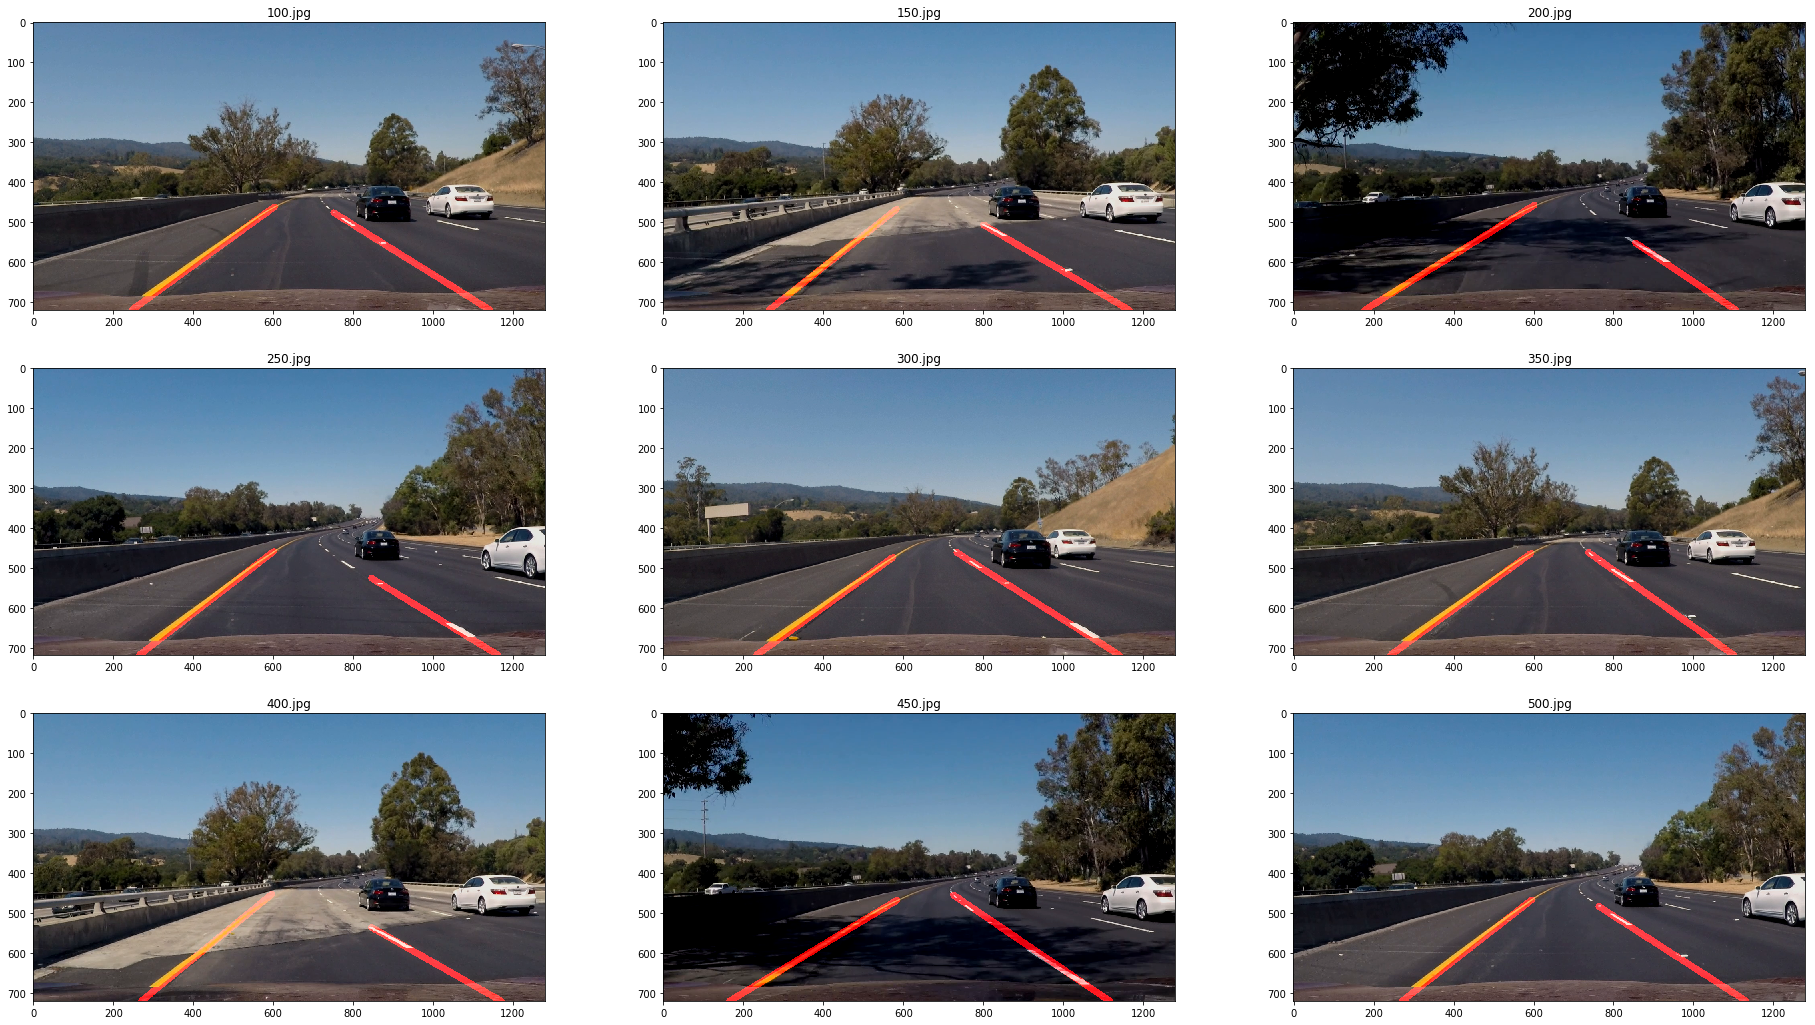

In [108]:
plt.figure(figsize=[32, 18])
i = 1
dir = os.listdir("test_images_challenge/")
output_dir = "test_image_output/"
for file in dir:
    if file != ".DS_Store":
        image = mpimg.imread('test_images_challenge/'+file)
        height = image.shape[0]
        width  = image.shape[1]
        vertices=np.array([[(50,height),(width*0.45,height*0.6),(width*0.55,height*0.6),(width-50,height)]], dtype=np.int32)
        processed_image = process_image(image, 5, 60, 170, vertices, 30, 1, 100, 1)
        mpimg.imsave(output_dir+file, processed_image)
        showimg((3, 3, i), file, processed_image)
        i = i + 1       

In [109]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
initialize_global_var()
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image_caller)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



100%|██████████| 251/251 [00:34<00:00,  8.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 12.1 s, sys: 1.14 s, total: 13.2 s
Wall time: 39.7 s


In [110]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_videos_output/challenge.mp4"))